# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="50" />

# Dynamical model of metabolism, electrophysiology and blood flow in the NGV unit

Copyright (c) 2023 Blue Brain Project/EPFL

Author: Polina Shichkova

## How to use it.
1. Copy this notebook to your Google Drive Account (_File_ > _Save a copy in Drive_) or directly download it (_File_ > _Download .ipynb_) and then upload it to your [Colab](https://colab.research.google.com/). The notebook is provided with the outputs of the cells displayed, so that you can see what to expect from running those cells.
2. Execute (by Ctrl+Enter or ⌘+Enter) the first 4 cells (i.e. until "Check the Installation") to install Julia and needed packages.  This takes some time. Attention, do not run all the cells of the entire notebook at once as reloading page is needed after setup part (see below).
3. Reload this page (Ctrl+R or ⌘+R or F5 key) and continue to run the other cells of the notebook. When you run the notebook for the first time, it is important to run all cells before those generating figures in the order they are provided in the notebook. It is recommended to wait for the cell's execution before running the next one.
4. You can directly modify parameters, initial values of variables and the functions according to your needs and run the simulations of your special version of the model. At this point after you run everything already, you don't need to start from the very beginning for each modification you made, but can work normally with just Julia part of the notebook (i.e. after "Check the Installation"). However, to ensure clean setup, you can do _Runtime_ > _Restart runtime_ or even _Disconnect and delete runtime_. In such case you will need to start from the very beginning of the notebook (i.e. including Julia installation part which is before "Check the Installation").
5. If you encounter problems which cannot be resolved by refreshing the runtime as described above, copy this notebook again and try to start from scratch following this instruction and comments in the code below.


In [ ]:
# This cell is needed to setup the system
# to save the output of this notebook
# on your google drive,
# after executing this cell, follow the instructions
# in the pop-up window

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! ls /content/gdrive

MyDrive


In [ ]:
# in the next cell we switch to Julia and set it up

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.6"
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_NUM_THREADS=20
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime"
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.6.6 on the current Colab Runtime
2025-01-21 08:39:37 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.6/julia-1.6.6-linux-x86_64.tar.gz [113575424/113575424] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.6

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


In [ ]:
# Please save (press Ctrl+S or ⌘+S) and reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
# jump to the next part: 'Check the Installation'

# Check the Installation
Now we have switched to Julia thanks to the cells above!
`versioninfo()` prints your Julia version and some system info

In [ ]:
versioninfo()

Julia Version 1.6.6
Commit b8708f954a (2022-03-28 07:17 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, broadwell)
Environment:
  JULIA_NUM_THREADS = 20


In [ ]:
using BenchmarkTools

# test the installation and performance on GoogleCollab

M = rand(2^10, 2^10)

@btime $M * $M;

  67.115 ms (2 allocations: 8.00 MiB)


In [ ]:
using Pkg; Pkg.status()

      Status `~/.julia/environments/v1.6/Project.toml`
  [6e4b80f9] BenchmarkTools v1.6.0
  [7073ff75] IJulia v1.26.0


In [ ]:
# Now we will install all the needed packages. It takes some time.

In [ ]:
Pkg.add(name="DifferentialEquations", version="7.2.0")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
   Installed CodecZlib ──────────────────────── v0.7.6
   Installed OpenSpecFun_jll ────────────────── v0.5.6+0
   Installed CpuId ──────────────────────────── v0.3.0
   Installed Adapt ──────────────────────────── v3.7.2
   Installed DifferentialEquations ──────────── v7.2.0
   Installed Tables ─────────────────────────── v1.12.0
   Installed ExprTools ──────────────────────── v0.1.10
   Installed TriangularSolve ────────────────── v0.1.20
   Installed NLSolversBase ──────────────────── v7.8.3
   Installed Reexport ───────────────────────── v1.2.2
   Installed OrderedCollections ─────────────── v1.7.0
   Installed CommonSubexpressions ───────────── v0.3.1
   Installed PtrArrays ──────────────────────── v1.3.0
   Installed Parameters ─────────────────────── v0.12.3
   Installed SnoopPrecompile ────────────────── v1.0.3
   Installed UnPack ─────────────────────────── v1.0.2
   Installed GPUArraysCore

In [ ]:
Pkg.add(name="ModelingToolkit", version="8.11.0")

   Resolving package versions...
   Installed BenchmarkTools ───────────────── v1.5.0
   Installed ArrayInterfaceCore ───────────── v0.1.29
   Installed InitialValues ────────────────── v0.3.1
   Installed MultivariatePolynomials ──────── v0.4.7
   Installed CSTParser ────────────────────── v3.4.3
   Installed CompositionsBase ─────────────── v0.1.2
   Installed MicroCollections ─────────────── v0.2.0
   Installed Bijections ───────────────────── v0.1.9
   Installed ArgCheck ─────────────────────── v2.4.0
   Installed ModelingToolkit ──────────────── v8.11.0
   Installed TermInterface ────────────────── v0.2.3
   Installed Crayons ──────────────────────── v4.1.1
   Installed SteadyStateDiffEq ────────────── v1.12.0
   Installed ArrayInterfaceStaticArraysCore ─ v0.1.4
   Installed LayoutPointers ───────────────── v0.1.8
   Installed StochasticDiffEq ─────────────── v6.53.0
   Installed FiniteDiff ───────────────────── v2.17.0
   Installed AbstractAlgebra ──────────────── v0.27.10
   Ins

In [ ]:
Pkg.add(name="Symbolics", version="4.3.0")

   Resolving package versions...
   Installed Static ───────── v0.4.1
   Installed LineSearches ─── v7.1.1
   Installed ArrayInterface ─ v3.2.2
   Installed NaNMath ──────── v0.3.7
   Installed Symbolics ────── v4.3.0
    Updating `~/.julia/environments/v1.6/Project.toml`
  [0c5d862f] + Symbolics v4.3.0
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [c3fe647b] - AbstractAlgebra v0.27.10
  [4fba245c] ↓ ArrayInterface v5.0.8 ⇒ v3.2.2
  [0b43b601] - Groebner v0.2.11
  [d5909c97] - GroupsCore v0.4.2
  [18e54dd8] - IntegerMathUtils v0.1.2
  [984bce1d] - LambertW v0.4.6
  [d3d80556] ↓ LineSearches v7.3.0 ⇒ v7.1.1
  [77ba4419] ↓ NaNMath v1.0.3 ⇒ v0.3.7
  [27ebfcd6] - Primes v0.5.6
  [fb686558] - RandomExtensions v0.4.4
  [aedffcd0] ↓ Static v0.6.6 ⇒ v0.4.1
  [0c5d862f] ↓ Symbolics v4.14.0 ⇒ v4.3.0
Precompiling project...
  ✓ NaNMath
  ✓ Static
  ✓ BitTwiddlingConvenienceFunctions
  ✓ ChainRulesCore
  ✓ CPUSummary
  ✓ ArrayInterface
  ✓ HostCPUFeatures
  ✓ DataStructures
  ✓ ZygoteR

In [ ]:
Pkg.add(name="Plots", version="1.31.1")

   Resolving package versions...
   Installed Measures ───────────────────── v0.3.2
   Installed ColorVectorSpace ───────────── v0.11.0
   Installed Xorg_libXdmcp_jll ──────────── v1.1.5+0
   Installed LLVMOpenMP_jll ─────────────── v18.1.7+0
   Installed Glib_jll ───────────────────── v2.82.4+0
   Installed xkbcommon_jll ──────────────── v1.4.1+2
   Installed Pango_jll ──────────────────── v1.55.5+0
   Installed Ogg_jll ────────────────────── v1.3.5+1
   Installed FriBidi_jll ────────────────── v1.0.16+0
   Installed Libffi_jll ─────────────────── v3.2.2+2
   Installed ColorTypes ─────────────────── v0.12.0
   Installed XML2_jll ───────────────────── v2.13.5+0
   Installed Xorg_xtrans_jll ────────────── v1.5.1+0
   Installed Qt5Base_jll ────────────────── v5.15.3+2
   Installed GeoFormatTypes ─────────────── v0.4.3
   Installed Extents ────────────────────── v0.1.4
   Installed GeometryBasics ─────────────── v0.4.11
   Installed RecipesPipeline ────────────── v0.5.2
   Installed Plots

In [ ]:
Pkg.add(name="JSON")

   Resolving package versions...
    Updating `~/.julia/environments/v1.6/Project.toml`
  [682c06a0] + JSON v0.21.4
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
Precompiling project...
  ✓ ArrayInterface
  ✓ ChainRulesCore
  ✓ CloseOpenIntervals
  ✓ LayoutPointers
  ✓ DataStructures
  ✓ ZygoteRules
  ✓ KrylovKit
  ✓ LogExpFunctions
  ✓ StrideArraysCore
  ✓ LabelledArrays
  ✓ SortingAlgorithms
  ✓ MultivariatePolynomials
  ✓ QuadGK
  ✓ Metatheory
  ✓ JuliaFormatter
  ✓ Graphs
  ✓ RecursiveArrayTools
  ✓ Polyester
  ✓ SpecialFunctions
  ✓ StatsBase
  ✓ VertexSafeGraphs
  ✓ DynamicPolynomials
  ✓ FastBroadcast
  ✓ VectorizationBase
  ✓ LevyArea
  ✓ HypergeometricFunctions
  ✓ DiffRules
  ✓ SciMLBase
  ✓ SLEEFPirates
  ✓ StatsFuns
  ✓ ForwardDiff
  ✓ SymbolicUtils
  ✓ DEDataArrays
  ✓ Distributions
  ✓ SIMDDualNumbers
  ✓ SparseDiffTools
  ✓ NLSolversBase
  ✓ PreallocationTools
  ✓ Plots
  ✓ Symbolics
  ✓ LineSearches
  ✓ NLsolve
  ✓ LoopVectorization
  ✓ TriangularSolve
  ✓ 

In [ ]:
using DifferentialEquations # main pkg
using ModelingToolkit, Symbolics # for performance

using Dates # to print current time

using Plots

import Random
Random.seed!(357819)


[ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
┌ Warning: Module Compat with build ID 412964917751 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Warning: Module Compat with build ID 412964917751 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Warning: Module Compat with build ID 412964917751 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Warning: Module Compat with build ID 412964917751 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that d

MersenneTwister(357819)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
run(`gdown --id 1aucffubVJdmgdHgIKlkS9L8oS4Ctom8t`)

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aucffubVJdmgdHgIKlkS9L8oS4Ctom8t
To: /content/parameters.json
100%|█████████████████████████████████████████████████████████| 17.1k/17.1k [00:00<00:00, 37.1MB/s]


Process(`gdown --id 1aucffubVJdmgdHgIKlkS9L8oS4Ctom8t`, ProcessExited(0))

In [ ]:
#import json
using JSON

# File path for the parameters.json file
json_file = "parameters.json"

# define parameters

# Parameters were collected from the literature and databases
# (data sources are listed in the supplementary file 2 of the paper) and
# optimised as described in the paper.
# Units are consistent with the parameter/variable type and
# the role of those parameters in the equations.
# Vmax type of parameter is mM/s; Km, Ki, Kact are mM;
# membrane potentials are in mV; concentrations are in mM.
# Please refer to the rate equations in case of doubt
# regarding the parameter type.

# Load the parameters from the JSON file
#parameters = load_parameters(json_file)
try
    parameters = JSON.parsefile(json_file)
catch e
    println("Error parsing JSON file: ", e)
    # Optionally: return or exit the program if the error is critical
end

# Create variables corresponding to the dictionary keys
# create_variables_from_dict(parameters)
# Dynamically assign variables from the dictionary
for count1 in 0:1 #the loop must be repeated twice to account for nested variable references
  for (key, value) in parameters
    try
     eval(Meta.parse("$key = eval($value)"))
    catch e
      if (count1>0)
        println("Exception")
      end
      continue
    end
  end
end


0
1


In [ ]:
###########################################
# HERE YOU CAN change ephys and bf stimulus onset and duration
# stimulus and bf activation
ti1 =  200.0
tf1 =  220.0 # or e.g. 230 - increased stim t for ephys and bf

global_par_t_0 = ti1
global_par_t_fin = tf1-ti1

tspanFin = tf1 + 80.

###########################################
# HERE YOU CAN choose age: 1=young, 2=old (reminder: enumeration in jl starts from 1)
age_cat = ["young","aged"][1]
nak_cat_or_full = ["cat","full"][1] # "cat" is default: aging Na/K ATPase catalytic, "full" is to also consider aging of non-catalytic subunits


"cat"

In [ ]:
run(`gdown --id 1pfQBFovZfD_NpUiTYdR-Me4LreqQ7VLU`)

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1pfQBFovZfD_NpUiTYdR-Me4LreqQ7VLU
To: /content/initial_values.json
100%|█████████████████████████████████████████████████████████| 5.36k/5.36k [00:00<00:00, 14.8MB/s]


Process(`gdown --id 1pfQBFovZfD_NpUiTYdR-Me4LreqQ7VLU`, ProcessExited(0))

In [ ]:
# File path for the initial_values.json file
json_file = "initial_values.json"

# define initial_values

# Parameters were collected from the literature and databases
# (data sources are listed in the supplementary file 2 of the paper) and
# optimised as described in the paper.
# Units are consistent with the parameter/variable type and
# the role of those parameters in the equations.
# Vmax type of parameter is mM/s; Km, Ki, Kact are mM;
# membrane potentials are in mV; concentrations are in mM.
# Please refer to the rate equations in case of doubt
# regarding the parameter type.
# initial values of variables

# Please refer to the "Initial values of variables" table on the NGV portal
# for the units, references, full names of variables and
# corresponding IDs in http://bigg.ucsd.edu (where available)

# Load the parameters from the JSON file
try
    initial_values = JSON.parsefile(json_file)
catch e
    println("Error parsing JSON file: ", e)
    # Optionally: return or exit the program if the error is critical
end

# Create variables corresponding to the dictionary keys
#create_variables_from_dict(initial_values)
# Dynamically assign variables from the dictionary
for (key, value) in initial_values
    eval(Meta.parse("$key = $value"))
end

u0_ss = [
  K_x_n0,Mg_x_n0,NADHmito_n0,QH2mito_n0,CytCredmito_n0,O2_n0,ATPmito_n0,ADPmito_n0,ATP_mx_n0,ADP_mx_n0,Pimito_n0,ATP_i_n0,ADP_i_n0,ATP_mi_n0,ADP_mi_n0,Pi_i_n0,MitoMembrPotent_n0,ATP_n0,FUMmito_n0,MALmito_n0,OXAmito_n0,SUCmito_n0,SUCCOAmito_n0,CoAmito_n0,AKGmito_n0,ISOCITmito_n0,CITmito_n0,AcCoAmito_n0,AcAc_n0,AcAcCoA_n0,PYRmito_n0,bHB_n0,bHB_ecs0,bHB_b0,GLUmito_n0,GLU_n0,NADH_n0,K_x_a0,Mg_x_a0,NADHmito_a0,QH2mito_a0,CytCredmito_a0,O2_a0,ATPmito_a0,ADPmito_a0,ATP_mx_a0,ADP_mx_a0,Pimito_a0,ATP_i_a0,ADP_i_a0,ATP_mi_a0,ADP_mi_a0,Pi_i_a0,MitoMembrPotent_a0,ATP_a0,FUMmito_a0,MALmito_a0,OXAmito_a0,SUCmito_a0,SUCCOAmito_a0,CoAmito_a0,AKGmito_a0,ISOCITmito_a0,CITmito_a0,AcCoAmito_a0,PYRmito_a0,GLN_n0,GLN_out0,GLN_a0,GLUT_a0,Va0,Na_a0,K_a0,K_out0,GLUT_syn0,VNeu0,Na_n0,h0,n0,Ca_n0,pgate0,nBK_a0,mGluRboundRatio_a0,IP3_a0,hIP3Ca_a0,Ca_a0,sTRP_a0,vV0,EET_a0,ddHb0,O2cap0,Glc_b0,Glc_t_t0,Glc_ecsBA0,Glc_a0,Glc_ecsAN0,Glc_n0,G6P_n0,G6P_a0,F6P_n0,F6P_a0,FBP_n0,FBP_a0,f26bp_a0,GLY_a0,G1P_a0,GAP_n0,GAP_a0,DHAP_n0,DHAP_a0,BPG13_n0,BPG13_a0,NADH_a0,PG3_n0,PG3_a0,PG2_n0,PG2_a0,PEP_n0,PEP_a0,Pyr_n0,Pyr_a0,Lac_b0,Lac_ecs0,Lac_a0,Lac_n0,NADPH_n0,NADPH_a0,GL6P_n0,GL6P_a0,GO6P_n0,GO6P_a0,RU5P_n0,RU5P_a0,R5P_n0,R5P_a0,X5P_n0,X5P_a0,S7P_n0,S7P_a0,E4P_n0,E4P_a0,GSH_n0,GSH_a0,GSSG_n0,GSSG_a0,PCr_n0,PCr_a0,cAMP_a0,NE_neuromod0,GPa_a0,GPb_a0
]

151-element Vector{Float64}:
 54.88513909303926
  0.6405401937956016
  0.3146584474671007
  0.0155067120830932
  0.1318502545732708
  0.0314865025158087
  0.7487433393982624
  1.8512566606017409
  0.2084517745966104
  1.129008031715835
 17.22873019667985
  1.385172099080793
  0.0572067246036489
  ⋮
  0.0066329544563609
  0.0061388697486627
  1.200006238770546
  4.300000202932421
  0.0119968806147281
  0.0429998985338233
  4.98986852470732
  4.927691727614907
  0.0391827032589541
  0.0
  0.0013314628973952
  0.0686685371026043

In [ ]:
# concentrations cannot be negative, but Vm can,
# so we need indexes of concentration-type variables to
# ensure those are non-negative:
# the solving will be stopped if those reach negative domain

cb_nonneg_idxs = @. [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,72,73,74,75,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151];


In [ ]:
# let's remind ourselves which age-category we have chosen

age_cat

"young"

In [ ]:
# define age-specific parameters and initial values of variables

if age_cat == "young"

    println(age_cat)

    C_Glc_a = 4.6
    u0_ss[92] = 4.555436497117541  # Glc_b
    println("C_Glc_a ",C_Glc_a,"\t Glc_b ",u0_ss[92])

    C_Lac_a = 0.75
    u0_ss[122] = 0.6887631395085969  # Lac_b
    println("C_Lac_a ",C_Lac_a,"\t Lac_b ",u0_ss[122])

    C_bHB_a = 0.3  #  0.3 is default
    println("C_bHB_a ",C_bHB_a)
    u0_ss[34] = 0.2981203841045341  # bHB_b
    u0_ss[33] = 0.0028617229372728  # bHB_ecs

    NADtot_n = NADtot
    NADtot_a = NADtot

    NAD_aging_coeff_n = 1
    NAD_aging_coeff_a = 1

    NAD_aging_coeff_mn = 1
    NAD_aging_coeff_ma = 1

    NADHshuttle_aging_n = 1
    NADHshuttle_aging_a = 1

    syn_aging_coeff = 1

else
    println("AGED")

    C_Glc_a = 5.0 # young value: 4.6
    u0_ss[92] = (C_Glc_a/4.6)*4.555436497117541  # Glc_b
    println("C_Glc_a ",C_Glc_a,"\t Glc_b ",u0_ss[92])

    C_Lac_a = (C_Glc_a/4.6)*0.75 # 0.75
    u0_ss[122] = (C_Glc_a/4.6)*0.6887631395085969   # Lac_b
    println("C_Lac_a ",C_Lac_a,"\t Lac_b ",u0_ss[122])

    C_bHB_a = 0.5*0.3 #1.0 #  0.3
    println("C_bHB_a ",C_bHB_a)
    u0_ss[34] = 0.5*0.2981203841045341  # bHB_b
    u0_ss[33] = 0.5*0.0028617229372728  # bHB_ecs

    # NAD pool decline in aging https://doi.org/10.1016/j.cmet.2018.05.011 https://doi.org/10.1016/j.cels.2021.09.001
    # cyto
    NAD_aging_coeff_n = 0.65
    NAD_aging_coeff_a = 0.5
    # mito
    NAD_aging_coeff_mn = 0.65
    NAD_aging_coeff_ma = 0.5

    NADtot_n = NAD_aging_coeff_mn*0.000726
    NADtot_a = NAD_aging_coeff_ma*0.000726

    NADHshuttle_aging_n = 0.2
    NADHshuttle_aging_a = 0.2

    syn_aging_coeff = 0.5

    #####################
    # Na/K ATPase pump
    #####################

    if nak_cat_or_full == "cat"
        # cat: aging scaling based on changes in expression
        # of catalytic subunits of Na/K ATPase pump

        println(nak_cat_or_full)

        nakFCn = 0.657319693198261 # calc as np.exp(tms_sig_n['coef (age.logFC)']*(24 - 3)) from TMS-Nature2020
        nakFCa = 1.0 # calc as np.exp(tms_sig_a['coef (age.logFC)']*(24 - 3)) from TMS-Nature2020

        kPumpn = nakFCn * 2.2e-6
        kPumpg = nakFCa * 4.5e-7

    elseif nak_cat_or_full == "full"
        # full: aging scaling based on changes in expression
        # of catalytic and regulatory subunits of Na/K ATPase pump

        println(nak_cat_or_full," incl. effects of aging on non-catalytic subunits")

        nakFCn = 0.6105796343077594 # calc as np.exp(tms_sig_n['coef (age.logFC)']*(24 - 3)) from TMS-Nat2020
        nakFCa = 0.8036492619959708 # calc as np.exp(tms_sig_a['coef (age.logFC)']*(24 - 3)) from TMS-Nat2020

        kPumpn = nakFCn * 2.2e-6
        kPumpg = nakFCa * 4.5e-7

    end
end

young
C_Glc_a 4.6	 Glc_b 4.555436497117541
C_Lac_a 0.75	 Lac_b 0.6887631395085969
C_bHB_a 0.3


1

In [ ]:
# HERE with presets you can simulate different predefined conditions specified below;
# you can add your own condition below following the same code structure

default_or_custom_config = ["default","custom"][1] # default: to use default age-specific modifications; custom - to simulate hypo/hyperglycemia, hypoxia, etc

println(default_or_custom_config)


if default_or_custom_config == "custom"

    preset_for_custom = ["1_blood_glc_ini",
                         "2_blood_lac_ini"
                        ][2] # HERE YOU CAN CHOOSE PRESET IDX

    extraTag = string(preset_for_custom,"_")

    #############################################
    # HERE YOU CAN CHOOSE CUSTOM

    if preset_for_custom in [ "1_blood_glc_ini"]

        C_Glc_a_mod = [1.6,2.6,3.6,4.6,5.6,6.6,7.6,8.6,9.6,10.6,11.6,12.6,13.6,14.6][7] # HERE YOU CAN CHOOSE CUSTOM
        extraTag = string(preset_for_custom,"_",string(C_Glc_a_mod))

        if preset_for_custom in [ "1_blood_glc_ini"]
            C_Glc_a = C_Glc_a_mod
            u0_ss[92] = (C_Glc_a/4.6)*4.555436497117541

        end

    end

    if preset_for_custom in [ "2_blood_lac_ini"]

        C_Lac_a_mod = [0.25,0.75,1.0,1.5,2.0,3.0,4.0,5.0, 2.5,2.25][5] # HERE YOU CAN CHOOSE CUSTOM
        extraTag = string(preset_for_custom,"_",string(C_Lac_a_mod))

        if preset_for_custom in [ "2_blood_lac_ini"]
            C_Lac_a = C_Lac_a_mod
            u0_ss[122] = (C_Lac_a/0.75)*0.6887631395085969   # Lac_b

        end

    end

    # HERE YOU CAN add:
    # elseif preset_for_custom in ["your condition"]
        # your changes

elseif default_or_custom_config == "default"
    extraTag = string(default_or_custom_config,"_")
else
    println("UNEXPECTED/UNDEFINED default_or_custom_config")
end




default


"default_"

In [ ]:
###########################################
# HERE YOU CAN CHOOSE SIM SETUP DEPENDING ON STIMULUS TYPE AND DURATION:
# TO HAVE BOTH SYN ACT AND NEmode SET to stim_choice = "NEmodAndSyn"
# OTHERWISE USE stim_choice = "mainSyn" FOR ONLY SYN ACT. "mainSyn_x2" is to simulate 2 intervals of mainSyn separated by rest state.
# OTHER STIM ARE ALSO AVAILABLE, SEE CODE FOR THE DETAILS

stim_choice = ["mainSyn", "NEmodAndSyn", "train_inj"][1]

if stim_choice == "train_inj"

    IinjAmpl = [1.198,2.5,3.0][1]

    println(stim_choice)
    println(IinjAmpl)

    # input current:
    #I[uA/cm2]*area[cm2]*1e3 = nA
    #I[uA/cm2]*area[cm2]*1e3 = nA
    #0.5/(surface*1e-8*1e3) = 1.198 uA/cm2 == 0.5 nA inj

else
    println("Using ",stim_choice)
end

#######################################################
# NEmod PARAMETERS CAN BE CHANGED HERE:
#######################################################

xNEmod = [0.025,0.05,0.1][1]

KdNEmod = 3.0e-4
taune1_neuromod = 0.01 # ms
taune2_neuromod = 100. # ms

tstimNE = ti1  # NE stimulus begins

################################################
# HERE YOU CAN change saveat_dt to 1e-4 seconds below to have high resolution and see individual spikes in time series plots, but
# ATTENTION: output file size will be several Gb in case of saveat_dt == 1e-4,
# so use it only when need such resolution for the figures and delete the output data once it isn't needed

saveat_dt = 1 #1e-4 #1 # 1e-4 # seconds  # 1e-4 only with  --exclusive --mem=0

println("CONFIG: ",age_cat,"\t",default_or_custom_config,"\t",stim_choice,"\t")


# THESE TWO ARE PARAMS FOR SYN ACT AND BF IN CB:
global_par_vn_2_tp = 3. #10. #1.44 # 25.
metglobal_par_t_stim_tp = 2.0

# these are just for initialisation, don't change them here
synInput = 1.0E-12 # ~0.0 but 1e-12 instead for numerical reasons in opt
Iinj0 = 1.0E-12 # ~0.0 but 1e-12 instead for numerical reasons in opt


Using mainSyn
CONFIG: young	default	mainSyn	


1.0e-12

In [ ]:
# In the next cell we have the metabolism-electrophysiology-blood flow system
# defined for two age categories: young and old

In [ ]:
if age_cat == "young"

    function metabolism!(du,u,p,t)

    synInput=p[1] # defined in callback, initial parameter value: 1.0E-12
    Iinj=p[2] # defined in callback, initial parameter value: 1.0E-12
    global_par_t_0 = p[3] # default: 200.0, but can be changed to simulate stimuli starting at different time
    global_par_t_fin = p[4] # default: 220.0, but can be changed to simulate stimuli of different duration

    u_k_m_n	 = 	u[1]
u_mg2_m_n	 = 	u[2]
u_nadh_m_n	 = 	u[3]
u_q10h2_m_n	 = 	u[4]
u_focytC_m_n	 = 	u[5]
u_o2_c_n	 = 	u[6]
u_atp_m_n	 = 	u[7]
u_adp_m_n	 = 	u[8]
u_notBigg_ATP_mx_m_n	 = 	u[9]
u_notBigg_ADP_mx_m_n	 = 	u[10]
u_pi_m_n	 = 	u[11]
u_atp_i_n	 = 	u[12]
u_adp_i_n	 = 	u[13]
u_notBigg_ATP_mi_i_n	 = 	u[14]
u_notBigg_ADP_mi_i_n	 = 	u[15]
u_pi_i_n	 = 	u[16]
u_notBigg_MitoMembrPotent_m_n	 = 	u[17]
u_atp_c_n	 = 	u[18]
u_fum_m_n	 = 	u[19]
u_mal_L_m_n	 = 	u[20]
u_oaa_m_n	 = 	u[21]
u_succ_m_n	 = 	u[22]
u_succoa_m_n	 = 	u[23]
u_coa_m_n	 = 	u[24]
u_akg_m_n	 = 	u[25]
u_icit_m_n	 = 	u[26]
u_cit_m_n	 = 	u[27]
u_accoa_m_n	 = 	u[28]
u_acac_c_n	 = 	u[29]
u_aacoa_m_n	 = 	u[30]
u_pyr_m_n	 = 	u[31]
u_bhb_c_n	 = 	u[32]
u_bhb_e_e	 = 	u[33]
u_bhb_b_b	 = 	u[34]
u_glu_L_m_n	 = 	u[35]
u_glu_L_c_n	 = 	u[36]
u_nadh_c_n	 = 	u[37]
u_k_m_a	 = 	u[38]
u_mg2_m_a	 = 	u[39]
u_nadh_m_a	 = 	u[40]
u_q10h2_m_a	 = 	u[41]
u_focytC_m_a	 = 	u[42]
u_o2_c_a	 = 	u[43]
u_atp_m_a	 = 	u[44]
u_adp_m_a	 = 	u[45]
u_notBigg_ATP_mx_m_a	 = 	u[46]
u_notBigg_ADP_mx_m_a	 = 	u[47]
u_pi_m_a	 = 	u[48]
u_atp_i_a	 = 	u[49]
u_adp_i_a	 = 	u[50]
u_notBigg_ATP_mi_i_a	 = 	u[51]
u_notBigg_ADP_mi_i_a	 = 	u[52]
u_pi_i_a	 = 	u[53]
u_notBigg_MitoMembrPotent_m_a	 = 	u[54]
u_atp_c_a	 = 	u[55]
u_fum_m_a	 = 	u[56]
u_mal_L_m_a	 = 	u[57]
u_oaa_m_a	 = 	u[58]
u_succ_m_a	 = 	u[59]
u_succoa_m_a	 = 	u[60]
u_coa_m_a	 = 	u[61]
u_akg_m_a	 = 	u[62]
u_icit_m_a	 = 	u[63]
u_cit_m_a	 = 	u[64]
u_accoa_m_a	 = 	u[65]
u_pyr_m_a	 = 	u[66]
u_gln_L_c_n	 = 	u[67]
u_gln_L_e_e	 = 	u[68]
u_gln_L_c_a	 = 	u[69]
u_glu_L_c_a	 = 	u[70]
u_notBigg_Va_c_a	 = 	u[71]
u_na1_c_a	 = 	u[72]
u_k_c_a	 = 	u[73]
u_k_e_e	 = 	u[74]
u_glu_L_syn_syn	 = 	u[75]
u_notBigg_VNeu_c_n	 = 	u[76]
u_na1_c_n	 = 	u[77]
u_notBigg_hgate_c_n	 = 	u[78]
u_notBigg_ngate_c_n	 = 	u[79]
u_ca2_c_n	 = 	u[80]
u_notBigg_pgate_c_n	 = 	u[81]
u_notBigg_nBK_c_a	 = 	u[82]
u_notBigg_mGluRboundRatio_c_a	 = 	u[83]
u_notBigg_IP3_c_a	 = 	u[84]
u_notBigg_hIP3Ca_c_a	 = 	u[85]
u_ca2_c_a	 = 	u[86]
u_notBigg_sTRP_c_a	 = 	u[87]
u_notBigg_vV_b_b	 = 	u[88]
u_notBigg_EET_c_a	 = 	u[89]
u_notBigg_ddHb_b_b	 = 	u[90]
u_o2_b_b	 = 	u[91]
u_glc_D_b_b	 = 	u[92]
u_glc_D_ecsEndothelium_ecsEndothelium	 = 	u[93]
u_glc_D_ecsBA_ecsBA	 = 	u[94]
u_glc_D_c_a	 = 	u[95]
u_glc_D_ecsAN_ecsAN	 = 	u[96]
u_glc_D_c_n	 = 	u[97]
u_g6p_c_n	 = 	u[98]
u_g6p_c_a	 = 	u[99]
u_f6p_c_n	 = 	u[100]
u_f6p_c_a	 = 	u[101]
u_fdp_c_n	 = 	u[102]
u_fdp_c_a	 = 	u[103]
u_f26bp_c_a	 = 	u[104]
u_glycogen_c_a	 = 	u[105]
u_g1p_c_a	 = 	u[106]
u_g3p_c_n	 = 	u[107]
u_g3p_c_a	 = 	u[108]
u_dhap_c_n	 = 	u[109]
u_dhap_c_a	 = 	u[110]
u_13dpg_c_n	 = 	u[111]
u_13dpg_c_a	 = 	u[112]
u_nadh_c_a	 = 	u[113]
u_3pg_c_n	 = 	u[114]
u_3pg_c_a	 = 	u[115]
u_2pg_c_n	 = 	u[116]
u_2pg_c_a	 = 	u[117]
u_pep_c_n	 = 	u[118]
u_pep_c_a	 = 	u[119]
u_pyr_c_n	 = 	u[120]
u_pyr_c_a	 = 	u[121]
u_lac_L_b_b	 = 	u[122]
u_lac_L_e_e	 = 	u[123]
u_lac_L_c_a	 = 	u[124]
u_lac_L_c_n	 = 	u[125]
u_nadph_c_n	 = 	u[126]
u_nadph_c_a	 = 	u[127]
u_6pgl_c_n	 = 	u[128]
u_6pgl_c_a	 = 	u[129]
u_6pgc_c_n	 = 	u[130]
u_6pgc_c_a	 = 	u[131]
u_ru5p_D_c_n	 = 	u[132]
u_ru5p_D_c_a	 = 	u[133]
u_r5p_c_n	 = 	u[134]
u_r5p_c_a	 = 	u[135]
u_xu5p_D_c_n	 = 	u[136]
u_xu5p_D_c_a	 = 	u[137]
u_s7p_c_n	 = 	u[138]
u_s7p_c_a	 = 	u[139]
u_e4p_c_n	 = 	u[140]
u_e4p_c_a	 = 	u[141]
u_gthrd_c_n	 = 	u[142]
u_gthrd_c_a	 = 	u[143]
u_gthox_c_n	 = 	u[144]
u_gthox_c_a	 = 	u[145]
u_pcreat_c_n	 = 	u[146]
u_pcreat_c_a	 = 	u[147]
u_camp_c_a	 = 	u[148]
u_nrpphr_e_e	 = 	u[149]
u_notBigg_GPa_c_a	 = 	u[150]
u_notBigg_GPb_c_a	 = 	u[151]


ADP_a = u[55]/2*(-qAK+sqrt(qAK*qAK+4*qAK*(ATDPtot_a/u[55]-1)))
ADP_aM = 1e-3*ADP_a
ADP_i_aM = 1e-3*u[50]
ADP_i_nM = 1e-3*u[13]
ADP_mi_aM = 1e-3*u[52]
ADP_mi_nM = 1e-3*u[15]
ADP_mx_aM = 1e-3*u[47]
ADP_mx_nM = 1e-3*u[10]
ADPmito_aM = 1e-3*u[45]
ADPmito_nM = 1e-3*u[8]
ATP_i_aM = 1e-3*u[49]
ATP_i_nM = 1e-3*u[12];
ATP_mi_aM = 1e-3*u[51]
ATP_mi_nM = 1e-3*u[14];
ATP_mx_aM = 1e-3*u[46]
ATP_mx_nM = 1e-3*u[9];
ATPmito_aM = 1e-3*u[44]
ATPmito_nM = 1e-3*u[7];
C_H_ims_aM = 1e-3*3.981071705487114e-5
C_H_ims_nM = 1e-3*3.981071705487114e-5
C_H_mitomatr_aM = 1e-3*1.82084728579186e-5
C_H_mitomatr_nM = 1e-3*1.82084728579186e-5
ADP_fi_a = ADP_i_aM-ADP_mi_aM
ADP_fi_n = ADP_i_nM-ADP_mi_nM
ADP_fx_a = ADPmito_aM-ADP_mx_aM
ADP_fx_n = ADPmito_nM-ADP_mx_nM
ADP_n = u[18]/2*(-qAK+sqrt(qAK*qAK+4*qAK*(ATDPtot_n/u[18]-1)))
ADP_nM = 1e-3*ADP_n
ATP_fi_a = ATP_i_aM-ATP_mi_aM
ATP_fi_n = ATP_i_nM-ATP_mi_nM
ATP_fx_a = ATPmito_aM-ATP_mx_aM
ATP_fx_n = ATPmito_nM-ATP_mx_nM

ADP_me_a = ((K_DD_a+ADP_aM+Mg_tot)-sqrt((K_DD_a+ADP_aM+Mg_tot)^2-4*(Mg_tot*ADP_aM)))/2;
ADP_me_n = ((K_DD+ADP_nM+Mg_tot)-sqrt((K_DD+ADP_nM+Mg_tot)^2-4*(Mg_tot*ADP_nM)))/2;

Ctot_aM = 1e-3*2.7
Ctot_nM = 1e-3*2.7
CytCredmito_aM = 1e-3*u[42]
CytCredmito_nM = 1e-3*u[5]

Cox_a = Ctot_aM-CytCredmito_aM;
Cox_n = Ctot_nM-CytCredmito_nM;

Isyni = 0
K_n = K_n_Rest+(Na_n_Rest-u[77])
Mg_i_a = Mg_tot-ADP_me_a;
Mg_i_n = Mg_tot-ADP_me_n;
NADHmito_aM = 1e-3*u[40]
NADHmito_nM = 1e-3*u[3]
NAD_x_a = NADtot_a-NADHmito_aM;
NAD_x_n = NADtot_n-NADHmito_nM;
QH2mito_aM = 1e-3*u[41]
QH2mito_nM = 1e-3*u[4]
Qtot_aM = 1e-3*1.35
Qtot_nM = 1e-3*1.35

Q_a = Qtot_aM-QH2mito_aM;
Q_n = Qtot_nM-QH2mito_nM;

V = u[76]
alphah = 0.07*exp(-(V+50)/10)
alpham = -0.1*(V+33)/(exp(-0.1*(V+33))-1)
alphan = -0.01*(V+34)/(exp(-0.1*(V+34))-1)
betah = 1/(exp(-0.1*(V+20))+1)
betam = 4*exp(-(V+58)/12)
betan = 0.125*exp(-(V+44)/25)

j_ug = qAK*qAK+4*qAK*(ATDPtot_a/u[55]-1)
j_un = qAK*qAK+4*qAK*(ATDPtot_n/u[18]-1)
dAMPdATPg = -1+qAK/2-0.5*sqrt(j_ug)+qAK*ATDPtot_a/(u[55]*sqrt(j_ug))
dAMPdATPn = -1+qAK/2-0.5*sqrt(j_un)+qAK*ATDPtot_n/(u[18]*sqrt(j_un))
dG_C1op_a = dG_C1o-1*etcRT*log(C_H_mitomatr_aM/1e-7);
dG_C1op_n = dG_C1o-1*etcRT*log(C_H_mitomatr_nM/1e-7);
dG_C3op_a = dG_C3o+2*etcRT*log(C_H_mitomatr_aM/1e-7);
dG_C3op_n = dG_C3o+2*etcRT*log(C_H_mitomatr_nM/1e-7);
dG_C4op_a = dG_C4o-2*etcRT*log(C_H_mitomatr_aM/1e-7);
dG_C4op_n = dG_C4o-2*etcRT*log(C_H_mitomatr_nM/1e-7);
dG_F1op_a = dG_F1o-1*etcRT*log(C_H_mitomatr_aM/1e-7);
dG_F1op_n = dG_F1o-1*etcRT*log(C_H_mitomatr_nM/1e-7);
dG_H_a = etcF*u[54]+1*etcRT*log(C_H_ims_aM/C_H_mitomatr_aM);
dG_H_n = etcF*u[17]+1*etcRT*log(C_H_ims_nM/C_H_mitomatr_nM);
hinf = alphah/(alphah+betah);
mCa = 1/(1+exp(-(V+20)/9));
minf = alpham/(alpham+betam);
nBKinf = 0.5*(1+tanh((u[71]+EETshift*u[89]-(-0.5*v5BK*tanh((u[86]-Ca3BK)/Ca4BK)+v6BK))/v4BK))
ninf = alphan/(alphan+betan);
p_inf = 1.0/(1.0+exp(-(V+35.0)/10.0));
rTRPVsinf = u[88]
tau_p = tau_max/(3.3*exp((V+35.0)/20.0)+exp(-(V+35.0)/20.0))
tauh = 1/(alphah+betah)*1e-03;
taun = 1/(alphan+betan)*1e-03;
u_adp_c_a = u[55]/2*(-qAK+sqrt(qAK*qAK+4*qAK*(ATDPtot_a/u[55]-1)))
u_adp_c_n = u[18]/2*(-qAK+sqrt(qAK*qAK+4*qAK*(ATDPtot_n/u[18]-1)))
u_h_i_a = 3.981071705487114e-5
u_h_i_n = 3.981071705487114e-5
u_h_m_a = 1.82084728579186e-5
u_h_m_n = 1.82084728579186e-5
u_akg_c_n = 0.2
u_amp_i_a = 0.0
u_amp_i_n = 0.0
u_asp_L_c_n = 1.4
u_asp_L_m_n = 1.4
u_bhb_c_a = 0.002235
u_ca2_m_a = 0.0001
u_ca2_m_n = 0.0001
u_co2_m_a = 1.2
u_h_c_a = 3.981071705534969e-5
u_h_c_n = 3.981071705534969e-5
u_mal_L_c_n = 0.45
u_nad_c_a = NAD_aging_coeff_a*0.212-u[113]
u_nad_c_n = NAD_aging_coeff_n*0.212-u[37]
u_nad_m_a = 1000*NAD_x_a
u_nad_m_n = 1000*NAD_x_n
u_nadp_c_a = 0.0303-u[127]
u_nadp_c_n = 0.0303-u[126]
u_notBigg_Ctot_m_a = 2.7
u_notBigg_Ctot_m_n = 2.7
u_notBigg_GS_c_a = 0.0029999
u_notBigg_PHKa_c_a = 4.0e-7
u_oaa_c_n = 0.01
u_pi_c_a = 20.0
u_pi_c_n = 20.0
u_ppi_c_a = 0.0062
u_udpg_c_a = 0.109
u_utp_c_a = 0.23

EK = RTF*log(u[74]/K_n)
EL = gKpas*EK/(gKpas+gNan)+gNan/(gKpas+gNan)*RTF*log(Na_out/u[77]);
H2PIi_a = (1e-3*u_pi_i_a)*(1e-3*u_h_i_a)/((1e-3*u_h_i_a)+k_dHPi)
H2PIi_n = (1e-3*u_pi_i_n)*(1e-3*u_h_i_n)/((1e-3*u_h_i_n)+k_dHPi)
H2PIx_a = (1e-3*u_pi_m_a)*(1e-3*u_h_m_a)/((1e-3*u_h_m_a)+k_dHPi)
H2PIx_n = (1e-3*u_pi_m_n)*(1e-3*u_h_m_n)/((1e-3*u_h_m_n)+k_dHPi)


ACACT1rm_n(u_aacoa_m_n,u_coa_m_n) = 1*(Vmax_thiolase_f_n*u_coa_m_n*u_aacoa_m_n/(Ki_CoA_thiolase_f_n*Km_AcAcCoA_thiolase_f_n+Km_AcAcCoA_thiolase_f_n*u_coa_m_n+Km_CoA_thiolase_f_n*u_aacoa_m_n+u_coa_m_n*u_aacoa_m_n))
ACONTm_a(u_cit_m_a,u_icit_m_a) = 1*(VmaxAco_a*(u_cit_m_a-u_icit_m_a/KeqAco_na)/(1.0+u_cit_m_a/KmCitAco_a+u_icit_m_a/KmIsoCitAco_a))
ACONTm_n(u_icit_m_n,u_cit_m_n) = 1*(VmaxAco_n*(u_cit_m_n-u_icit_m_n/KeqAco_na)/(1.0+u_cit_m_n/KmCitAco_n+u_icit_m_n/KmIsoCitAco_n))
ADK1m_a(u_atp_i_a,u_adp_i_a,u_amp_i_a) = 1*(x_AK*(K_AK*(1e-3*u_adp_i_a)*(1e-3*u_adp_i_a)-(1e-3*u_amp_i_a)*(1e-3*u_atp_i_a)))
ADK1m_n(u_amp_i_n,u_atp_i_n,u_adp_i_n) = 1*(x_AK*(K_AK*(1e-3*u_adp_i_n)*(1e-3*u_adp_i_n)-(1e-3*u_amp_i_n)*(1e-3*u_atp_i_n)))
ADNCYC_a(u_camp_c_a,u_atp_c_a) = 1*(((VmaxfAC_a*u_atp_c_a/(KmACATP_a*(1+u_camp_c_a/KicAMPAC_a))-VmaxrAC_a*u_camp_c_a/(KmpiAC_a*KmcAMPAC_a))/(1+u_atp_c_a/(KmACATP_a*(1+u_camp_c_a/KicAMPAC_a))+u_camp_c_a/KmcAMPAC_a)))
AKGDm_a(u_coa_m_a,u_nadh_m_a,u_akg_m_a,u_ca2_m_a,u_nad_m_a,u_succoa_m_a,u_atp_m_a,u_adp_m_a) = 1*((VmaxKGDH_a*(1+u_adp_m_a/KiADPmito_KGDH_a)*(u_akg_m_a/Km1KGDHKGDH_a)*(u_coa_m_a/Km_CoA_kgdhKGDH_a)*(u_nad_m_a/KmNADkgdhKGDH_na))/(((u_coa_m_a/Km_CoA_kgdhKGDH_a)*(u_nad_m_a/KmNADkgdhKGDH_na)*(u_akg_m_a/Km1KGDHKGDH_a+(1+u_atp_m_a/KiATPmito_KGDH_a)/(1+u_ca2_m_a/KiCa2KGDH_a)))+((u_akg_m_a/Km1KGDHKGDH_a)*(u_coa_m_a/Km_CoA_kgdhKGDH_a+u_nad_m_a/KmNADkgdhKGDH_na)*(1+u_nadh_m_a/KiNADHKGDHKGDH_na+u_succoa_m_a/Ki_SucCoA_kgdhKGDH_a))))
AKGDm_n(u_coa_m_n,u_nadh_m_n,u_ca2_m_n,u_adp_m_n,u_succoa_m_n,u_nad_m_n,u_atp_m_n,u_akg_m_n) = 1*((VmaxKGDH_n*(1+u_adp_m_n/KiADPmito_KGDH_n)*(u_akg_m_n/Km1KGDHKGDH_n)*(u_coa_m_n/Km_CoA_kgdhKGDH_n)*(u_nad_m_n/KmNADkgdhKGDH_na))/(((u_coa_m_n/Km_CoA_kgdhKGDH_n)*(u_nad_m_n/KmNADkgdhKGDH_na)*(u_akg_m_n/Km1KGDHKGDH_n+(1+u_atp_m_n/KiATPmito_KGDH_n)/(1+u_ca2_m_n/KiCa2KGDH_n)))+((u_akg_m_n/Km1KGDHKGDH_n)*(u_coa_m_n/Km_CoA_kgdhKGDH_n+u_nad_m_n/KmNADkgdhKGDH_na)*(1+u_nadh_m_n/KiNADHKGDHKGDH_na+u_succoa_m_n/Ki_SucCoA_kgdhKGDH_n))))
AKGMALtm_n(u_mal_L_c_n,u_akg_m_n,u_akg_c_n,u_mal_L_m_n) = 1*(Vmaxmakgc_n*(u_mal_L_c_n*u_akg_m_n-u_mal_L_m_n*u_akg_c_n)/((u_mal_L_c_n+Km_mal_mkgc_n)*(u_akg_m_n+Km_akgmito_mkgc_n)+(u_mal_L_m_n+Km_malmito_mkgc_n)*(u_akg_c_n+Km_akg_mkgc_n)))
ASPGLUm_n(u_h_c_n,u_glu_L_c_n,u_asp_L_m_n,u_asp_L_c_n,u_notBigg_MitoMembrPotent_m_n,u_glu_L_m_n,u_h_m_n) = 1*(Vmaxagc_n*(u_asp_L_m_n*u_glu_L_c_n-u_asp_L_c_n*u_glu_L_m_n/((exp(u_notBigg_MitoMembrPotent_m_n)^(F/(R*T)))*(u_h_c_n/u_h_m_n)))/((u_asp_L_m_n+Km_aspmito_agc_n)*(u_glu_L_c_n+Km_glu_agc_n)+(u_asp_L_c_n+Km_asp_agc_n)*(u_glu_L_m_n+Km_glumito_agc_n)))
ASPTA_n(u_glu_L_c_n,u_asp_L_c_n,u_oaa_c_n,u_akg_c_n) = 1*(VfCAAT_n*(u_asp_L_c_n*u_akg_c_n-u_oaa_c_n*u_glu_L_c_n/KeqCAAT_n)/(KmAKG_CAAT_n*u_asp_L_c_n+KmASP_CAAT_n*(1.0+u_akg_c_n/KiAKG_CAAT_n)*u_akg_c_n+u_asp_L_c_n*u_akg_c_n+KmASP_CAAT_n*u_akg_c_n*u_glu_L_c_n/KiGLU_CAAT_n+(KiASP_CAAT_n*KmAKG_CAAT_n/(KmOXA_CAAT_n*KiGLU_CAAT_n))*(KmGLU_CAAT_n*u_asp_L_c_n*u_oaa_c_n/KiASP_CAAT_n+u_oaa_c_n*u_glu_L_c_n+KmGLU_CAAT_n*(1.0+u_akg_c_n/KiAKG_CAAT_n)*u_oaa_c_n+KmOXA_CAAT_n*u_glu_L_c_n)))
ASPTAm_n(u_oaa_m_n,u_akg_m_n,u_glu_L_m_n,u_asp_L_m_n) = 1*(VfAAT_n*(u_asp_L_m_n*u_akg_m_n-u_oaa_m_n*u_glu_L_m_n/KeqAAT_n)/(KmAKG_AAT_n*u_asp_L_m_n+KmASP_AAT_n*(1.0+u_akg_m_n/KiAKG_AAT_n)*u_akg_m_n+u_asp_L_m_n*u_akg_m_n+KmASP_AAT_n*u_akg_m_n*u_glu_L_m_n/KiGLU_AAT_n+(KiASP_AAT_n*KmAKG_AAT_n/(KmOXA_AAT_n*KiGLU_AAT_n))*(KmGLU_AAT_n*u_asp_L_m_n*u_oaa_m_n/KiASP_AAT_n+u_oaa_m_n*u_glu_L_m_n+KmGLU_AAT_n*(1.0+u_akg_m_n/KiAKG_AAT_n)*u_oaa_m_n+KmOXA_AAT_n*u_glu_L_m_n)))
ATPS4mi_a(u_notBigg_ATP_mx_m_a,u_pi_m_a,u_notBigg_ADP_mx_m_a) = 1*(x_F1_a*(exp(-(dG_F1op_a-n_A*dG_H_a)/etcRT)*(K_DD_a/K_DT_a)*(1e-3*u_notBigg_ADP_mx_m_a)*(1e-3*u_pi_m_a)-(1e-3*u_notBigg_ATP_mx_m_a)))
ATPS4mi_n(u_notBigg_ATP_mx_m_n,u_notBigg_ADP_mx_m_n,u_pi_m_n) = 1*(x_F1*(exp(-(dG_F1op_n-n_A*dG_H_n)/etcRT)*(K_DD/K_DT)*(1e-3*u_notBigg_ADP_mx_m_n)*(1e-3*u_pi_m_n)-(1e-3*u_notBigg_ATP_mx_m_n)))
ATPtm_a(u_notBigg_MitoMembrPotent_m_a) = 1*(x_ANT_a*(ADP_fi_a/(ADP_fi_a+ATP_fi_a*exp(-etcF*(0.35*u_notBigg_MitoMembrPotent_m_a)/etcRT))-ADP_fx_a/(ADP_fx_a+ATP_fx_a*exp(-etcF*(-0.65*u_notBigg_MitoMembrPotent_m_a)/etcRT)))*(ADP_fi_a/(ADP_fi_a+k_mADP_a)))
ATPtm_n(u_notBigg_MitoMembrPotent_m_n) = 1*(x_ANT*(ADP_fi_n/(ADP_fi_n+ATP_fi_n*exp(-etcF*(0.35*u_notBigg_MitoMembrPotent_m_n)/etcRT))-ADP_fx_n/(ADP_fx_n+ATP_fx_n*exp(-etcF*(-0.65*u_notBigg_MitoMembrPotent_m_n)/etcRT)))*(ADP_fi_n/(ADP_fi_n+k_mADP)))
BDHm_n(u_acac_c_n,u_bhb_c_n,u_nadh_m_n,u_nad_m_n) = 1*(Vmax_bHBDH_f_n*u_nad_m_n*u_bhb_c_n/(Ki_NAD_B_HBD_f_n*Km_betaHB_BHBD_n+Km_betaHB_BHBD_n*u_nad_m_n+Km_NAD_B_HBD_n*u_bhb_c_n+u_nad_m_n*u_bhb_c_n)-(Vmax_bHBDH_r_n*u_nadh_m_n*u_acac_c_n/(Ki_NADH_BHBD_r_n*Km_AcAc_BHBD_n+Km_AcAc_BHBD_n*u_nadh_m_n+Km_NADH_BHBD_n*u_acac_c_n+u_nadh_m_n*u_acac_c_n)))
BHBt_a(u_bhb_c_a,u_bhb_e_e) = 1*(VmaxMCTbhb_a*(u_bhb_e_e/(u_bhb_e_e+KmMCT1_bHB_a)-u_bhb_c_a/(u_bhb_c_a+KmMCT1_bHB_a)))
BHBt_n(u_bhb_c_n,u_bhb_e_e) = 1*(VmaxMCTbhb_n*(u_bhb_e_e/(u_bhb_e_e+KmMCT2_bHB_n)-u_bhb_c_n/(u_bhb_c_n+KmMCT2_bHB_n)))
CKc_a(u_adp_c_a,u_atp_c_a,u_pcreat_c_a) = 1*(kCKgps*u_pcreat_c_a*u_adp_c_a-KeqCKgpms*kCKgps*(Crtot-u_pcreat_c_a)*u_atp_c_a)
CKc_n(u_pcreat_c_n,u_atp_c_n,u_adp_c_n) = 1*(kCKnps*u_pcreat_c_n*u_adp_c_n-KeqCKnpms*kCKnps*(Crtot-u_pcreat_c_n)*u_atp_c_n)
CSm_a(u_oaa_m_a,u_cit_m_a,u_accoa_m_a,u_coa_m_a) = 1*(VmaxCSmito_a*(u_oaa_m_a/(u_oaa_m_a+KmOxaMito_a*(1.0+u_cit_m_a/KiCitMito_a)))*(u_accoa_m_a/(u_accoa_m_a+KmAcCoAmito_a*(1.0+u_coa_m_a/KiCoA_a))))
CSm_n(u_accoa_m_n,u_oaa_m_n,u_cit_m_n,u_coa_m_n) = 1*(VmaxCSmito_n*(u_oaa_m_n/(u_oaa_m_n+KmOxaMito_n*(1.0+u_cit_m_n/KiCitMito_n)))*(u_accoa_m_n/(u_accoa_m_n+KmAcCoAmito_n*(1.0+u_coa_m_n/KiCoA_n))))
CYOOm2i_a(u_notBigg_Ctot_m_a,u_focytC_m_a,u_notBigg_MitoMembrPotent_m_a,u_o2_c_a) = 1*(x_C4*((1e-3*u_o2_c_a)/((1e-3*u_o2_c_a)+k_O2))*((1e-3*u_focytC_m_a)/(1e-3*u_notBigg_Ctot_m_a))*(exp(-(dG_C4op_a+2*dG_H_a)/(2*etcRT))*(1e-3*u_focytC_m_a)*((1e-3*u_o2_c_a)^0.25)-Cox_a*exp(etcF*u_notBigg_MitoMembrPotent_m_a/etcRT)))
CYOOm2i_n(u_focytC_m_n,u_notBigg_MitoMembrPotent_m_n,u_notBigg_Ctot_m_n,u_o2_c_n) = 1*(x_C4*((1e-3*u_o2_c_n)/((1e-3*u_o2_c_n)+k_O2))*((1e-3*u_focytC_m_n)/(1e-3*u_notBigg_Ctot_m_n))*(exp(-(dG_C4op_n+2*dG_H_n)/(2*etcRT))*(1e-3*u_focytC_m_n)*((1e-3*u_o2_c_n)^0.25)-Cox_n*exp(etcF*u_notBigg_MitoMembrPotent_m_n/etcRT)))
CYOR_u10mi_a(u_focytC_m_a,u_q10h2_m_a,u_pi_m_a,u_notBigg_MitoMembrPotent_m_a) = 1*(x_C3*((1+(1e-3*u_pi_m_a)/k_Pi3)/(1+(1e-3*u_pi_m_a)/k_Pi4))*(exp(-(dG_C3op_a+4*dG_H_a-2*etcF*u_notBigg_MitoMembrPotent_m_a)/(2*etcRT))*Cox_a*(1e-3*u_q10h2_m_a)^0.5-(1e-3*u_focytC_m_a)*Q_a^0.5))
CYOR_u10mi_n(u_focytC_m_n,u_notBigg_MitoMembrPotent_m_n,u_q10h2_m_n,u_pi_m_n) = 1*(x_C3*((1+(1e-3*u_pi_m_n)/k_Pi3)/(1+(1e-3*u_pi_m_n)/k_Pi4))*(exp(-(dG_C3op_n+4*dG_H_n-2*etcF*u_notBigg_MitoMembrPotent_m_n)/(2*etcRT))*Cox_n*(1e-3*u_q10h2_m_n)^0.5-(1e-3*u_focytC_m_n)*Q_n^0.5))
ENO_a(u_2pg_c_a,u_pep_c_a) = 1*(Vmaxenol_a*(u_2pg_c_a-u_pep_c_a/Keqenol_a)/((1+u_2pg_c_a/Kmpg2enol_a)+(1+u_pep_c_a/Km_pep_enol_a)-1))
ENO_n(u_pep_c_n,u_2pg_c_n) = 1*(Vmaxenol_n*(u_2pg_c_n-u_pep_c_n/Keqenol_n)/((1+u_2pg_c_n/Kmpg2enol_n)+(1+u_pep_c_n/Km_pep_enol_n)-1))
FBA_a(u_g3p_c_a,u_fdp_c_a,u_dhap_c_a) = 1*(Vmaxald_a*(u_fdp_c_a-u_g3p_c_a*u_dhap_c_a/Keqald_a)/((1+u_fdp_c_a/KmfbpAld_a)+(1+u_g3p_c_a/KmgapAld_a)*(1+u_dhap_c_a/KmdhapAld_a)-1))
FBA_n(u_fdp_c_n,u_dhap_c_n,u_g3p_c_n) = 1*(Vmaxald_n*(u_fdp_c_n-u_g3p_c_n*u_dhap_c_n/Keqald_n)/((1+u_fdp_c_n/KmfbpAld_n)+(1+u_g3p_c_n/KmgapAld_n)*(1+u_dhap_c_n/KmdhapAld_n)-1))
FUMm_a(u_mal_L_m_a,u_fum_m_a) = 1*(Vmaxfum_a*(u_fum_m_a-u_mal_L_m_a/Keqfummito_na)/(1.0+u_fum_m_a/Km_fummito_a+u_mal_L_m_a/Km_malmito_a))
FUMm_n(u_fum_m_n,u_mal_L_m_n) = 1*(Vmaxfum_n*(u_fum_m_n-u_mal_L_m_n/Keqfummito_na)/(1.0+u_fum_m_n/Km_fummito_n+u_mal_L_m_n/Km_malmito_n))
G6PDH2r_a(u_6pgl_c_a,u_nadp_c_a,u_g6p_c_a,u_nadph_c_a) = 1*(VmaxG6PDH_a*(1/(K_G6P_G6PDH_a*K_NADP_G6PDH_a))*((u_g6p_c_a*u_nadp_c_a-u_6pgl_c_a*u_nadph_c_a/KeqG6PDH_a)/((1+u_g6p_c_a/K_G6P_G6PDH_a)*(1+u_nadp_c_a/K_NADP_G6PDH_a)+(1+u_6pgl_c_a/K_GL6P_G6PDH_a)*(1+u_nadph_c_a/K_NADPH_G6PDH_a)-1)))
G6PDH2r_n(u_g6p_c_n,u_nadph_c_n,u_nadp_c_n,u_6pgl_c_n) = 1*(VmaxG6PDH_n*(1/(K_G6P_G6PDH_n*K_NADP_G6PDH_n))*((u_g6p_c_n*u_nadp_c_n-u_6pgl_c_n*u_nadph_c_n/KeqG6PDH_n)/((1+u_g6p_c_n/K_G6P_G6PDH_n)*(1+u_nadp_c_n/K_NADP_G6PDH_n)+(1+u_6pgl_c_n/K_GL6P_G6PDH_n)*(1+u_nadph_c_n/K_NADPH_G6PDH_n)-1)))
GALUi_a(u_ppi_c_a,u_g1p_c_a,u_udpg_c_a,u_utp_c_a) = 1*((VmaxfUDPGP*u_utp_c_a*u_g1p_c_a/(KutpUDPGP*Kg1pUDPGP)-VmaxrUDPGP*u_ppi_c_a*u_udpg_c_a/(KpiUDPGP*KUDPglucoUDPGP_a))/(1.0+u_g1p_c_a/Kg1pUDPGP+u_utp_c_a/KutpUDPGP+(u_g1p_c_a*u_utp_c_a)/(Kg1pUDPGP*KutpUDPGP)+u_udpg_c_a/KUDPglucoUDPGP_a+u_ppi_c_a/KpiUDPGP+(u_ppi_c_a*u_udpg_c_a)/(KpiUDPGP*KUDPglucoUDPGP_a)))
GAPD_a(u_nadh_c_a,u_nad_c_a,u_pi_c_a,u_13dpg_c_a,u_g3p_c_a) = 1*(Vmaxgapdh_a*(u_nad_c_a*u_g3p_c_a*u_pi_c_a-u_13dpg_c_a*u_nadh_c_a/Keqgapdh_na)/((1+u_nad_c_a/KmnadGpdh_a)*(1+u_g3p_c_a/KmGapGapdh_a)*(1+u_pi_c_a/KmpiGpdh_a)+(1+u_nadh_c_a/KmnadhGapdh_a)*(1+u_13dpg_c_a/KmBPG13Gapdh_a)-1))
GAPD_n(u_nadh_c_n,u_nad_c_n,u_g3p_c_n,u_pi_c_n,u_13dpg_c_n) = 1*(Vmaxgapdh_n*(u_nad_c_n*u_g3p_c_n*u_pi_c_n-u_13dpg_c_n*u_nadh_c_n/Keqgapdh_na)/((1+u_nad_c_n/KmnadGpdh_n)*(1+u_g3p_c_n/KmGapGapdh_n)*(1+u_pi_c_n/KmpiGpdh_n)+(1+u_nadh_c_n/KmnadhGapdh_n)*(1+u_13dpg_c_n/KmBPG13Gapdh_n)-1))
GLCP_a(u_glycogen_c_a,u_notBigg_GPa_c_a,u_camp_c_a,u_notBigg_GPb_c_a) = 1*((u_notBigg_GPa_c_a/(u_notBigg_GPa_c_a+u_notBigg_GPb_c_a))*VmaxGP_a*u_glycogen_c_a*(1/(1+(KmGP_AMP_a^hGPa)/(u_camp_c_a^hGPa))))
GLCS2_a(u_notBigg_GS_c_a,u_udpg_c_a) = 1*(kL2_GS_a*u_notBigg_GS_c_a*u_udpg_c_a/(kmL2_GS_a+u_udpg_c_a))
GLNS_a(u_adp_c_a,u_atp_c_a,u_glu_L_c_a) = 1*(VmaxGLNsynth_a*(u_glu_L_c_a/(KmGLNsynth_a+u_glu_L_c_a))*((1/(u_atp_c_a/u_adp_c_a))/(muGLNsynth_a+(1/(u_atp_c_a/u_adp_c_a)))))
GLNt4_a(u_gln_L_c_a,u_gln_L_e_e) = 1*(TmaxSNAT_GLN_a*(u_gln_L_c_a-u_gln_L_e_e)/(KmSNAT_GLN_a+u_gln_L_c_a))
GLNt4_n(u_gln_L_c_n,u_gln_L_e_e) = 1*(TmaxSNAT_GLN_n*(u_gln_L_e_e-u_gln_L_c_n/coeff_gln_ratio_n_ecs)/(KmSNAT_GLN_n+u_gln_L_c_n))
GLUDxm_a(u_nad_m_a,u_nadh_m_a,u_glu_L_c_a,u_akg_m_a) = 1*(VmGDH_a*(u_nad_m_a*u_glu_L_c_a-u_nadh_m_a*u_akg_m_a/KeqGDH_a)/(KiNAD_GDH_a*KmGLU_GDH_a+KmGLU_GDH_a*u_nad_m_a+KiNAD_GDH_a*u_glu_L_c_a+u_glu_L_c_a*u_nad_m_a+u_glu_L_c_a*u_nad_m_a/KiAKG_GDH_a+KiNAD_GDH_a*KmGLU_GDH_a*u_nadh_m_a/KiNADH_GDH_a+KiNAD_GDH_a*KmGLU_GDH_a*KmNADH_GDH_a*u_akg_m_a/(KiAKG_GDH_a*KiNADH_GDH_a)+KmNADH_GDH_a*u_glu_L_c_a*u_nadh_m_a/KiNADH_GDH_a+KiNAD_GDH_a*KmGLU_GDH_a*KmAKG_GDH_a*u_nadh_m_a/(KiAKG_GDH_a*KiNADH_GDH_a)+KiNAD_GDH_a*KmGLU_GDH_a*KmAKG_GDH_a*u_akg_m_a*u_nadh_m_a/(KiAKG_GDH_a*KiNADH_GDH_a)+u_glu_L_c_a*u_nad_m_a*u_akg_m_a/KiAKG_GDH_a+KiNAD_GDH_a*KmGLU_GDH_a*KmAKG_GDH_a/KiAKG_GDH_a+KiNAD_GDH_a*KmGLU_GDH_a*u_glu_L_c_a*u_nadh_m_a*u_akg_m_a/(KiGLU_GDH_a*KiAKG_GDH_a*KiNADH_GDH_a)+KiNAD_GDH_a*KmGLU_GDH_a*u_akg_m_a*u_nadh_m_a/(KiAKG_GDH_a*KiNADH_GDH_a)+KmNADH_GDH_a*KmGLU_GDH_a*u_akg_m_a*u_nad_m_a/(KiAKG_GDH_a*KiNADH_GDH_a)))
GLUNm_n(u_gln_L_c_n,u_glu_L_m_n) = 1*(VmGLS_n*(u_gln_L_c_n-u_glu_L_m_n/KeqGLS_n)/(KmGLNGLS_n*(1.0+u_glu_L_m_n/KiGLUGLS_n)+u_gln_L_c_n))
GLUt6_a(u_na1_c_a,u_notBigg_Va_c_a,u_k_e_e,u_glu_L_syn_syn,u_k_c_a,u_glu_L_c_a) = 1*(-((1/(2*F*1e-3))*(-alpha_EAAT*exp(-beta_EAAT*(u_notBigg_Va_c_a-((R*T/(2*F*1e-3))*log(((Na_syn_EAAT/u_na1_c_a)^3)*(H_syn_EAAT/H_ast_EAAT)*(u_glu_L_syn_syn/u_glu_L_c_a)*(u_k_c_a/u_k_e_e))))))))
GND_a(u_6pgc_c_a,u_nadp_c_a,u_ru5p_D_c_a,u_nadph_c_a) = 1*(Vmax6PGDH_a*(1/(K_GO6P_6PGDH_a*K_NADP_6PGDH_a))*(u_6pgc_c_a*u_nadp_c_a-u_ru5p_D_c_a*u_nadph_c_a/Keq6PGDH_a)/((1+u_6pgc_c_a/K_GO6P_6PGDH_a)*(1+u_nadp_c_a/K_NADP_6PGDH_a)+(1+u_ru5p_D_c_a/K_RU5P_6PGDH_a)*(1+u_nadph_c_a/K_NADPH_6PGDH_a)-1))
GND_n(u_6pgc_c_n,u_nadph_c_n,u_nadp_c_n,u_ru5p_D_c_n) = 1*(Vmax6PGDH_n*(1/(K_GO6P_6PGDH_n*K_NADP_6PGDH_n))*(u_6pgc_c_n*u_nadp_c_n-u_ru5p_D_c_n*u_nadph_c_n/Keq6PGDH_n)/((1+u_6pgc_c_n/K_GO6P_6PGDH_n)*(1+u_nadp_c_n/K_NADP_6PGDH_n)+(1+u_ru5p_D_c_n/K_RU5P_6PGDH_n)*(1+u_nadph_c_n/K_NADPH_6PGDH_n)-1))
GTHO_a(u_gthox_c_a,u_nadph_c_a) = 1*((Vmf_GSSGR_a*u_gthox_c_a*u_nadph_c_a)/((KmGSSGRGSSG_a+u_gthox_c_a)*(KmGSSGRNADPH_a+u_nadph_c_a)))
GTHO_n(u_nadph_c_n,u_gthox_c_n) = 1*((Vmf_GSSGR_n*u_gthox_c_n*u_nadph_c_n)/((KmGSSGRGSSG_n+u_gthox_c_n)*(KmGSSGRNADPH_n+u_nadph_c_n)))
GTHP_a(u_gthrd_c_a) = 1*(V_GPX_a*u_gthrd_c_a/(u_gthrd_c_a+KmGPXGSH_a))
GTHP_n(u_gthrd_c_n) = 1*(V_GPX_n*u_gthrd_c_n/(u_gthrd_c_n+KmGPXGSH_n))
GTHS_a(u_gthrd_c_a) = 1*(VmaxGSHsyn_a*(glycine_a*glutamylCys_a-u_gthrd_c_a/KeGSHSyn_a)/(Km_glutamylCys_GSHsyn_a*Km_glycine_GSHsyn_a+glutamylCys_a*Km_glutamylCys_GSHsyn_a+glycine_a*Km_glycine_GSHsyn_a*(1+glutamylCys_a/Km_glutamylCys_GSHsyn_a)+u_gthrd_c_a/KmGSHsyn_a))
GTHS_n(u_gthrd_c_n) = 1*(VmaxGSHsyn_n*(glycine_n*glutamylCys_n-u_gthrd_c_n/KeGSHSyn_n)/(Km_glutamylCys_GSHsyn_n*Km_glycine_GSHsyn_n+glutamylCys_n*Km_glutamylCys_GSHsyn_n+glycine_n*Km_glycine_GSHsyn_n*(1+glutamylCys_n/Km_glutamylCys_GSHsyn_n)+u_gthrd_c_n/KmGSHsyn_n))
HEX1_a(u_atp_c_a,u_g6p_c_a,u_glc_D_c_a) = 1*((VmaxHK_a*u_glc_D_c_a/(u_glc_D_c_a+KmHK_a))*(u_atp_c_a/(1+(u_atp_c_a/KIATPhex_a)^nHhexa))*(1/(1+u_g6p_c_a/KiHKG6P_a)))
HEX1_n(u_glc_D_c_n,u_atp_c_n,u_g6p_c_n) = 1*((VmaxHK_n*u_glc_D_c_n/(u_glc_D_c_n+KmHK_n))*(u_atp_c_n/(1+(u_atp_c_n/KIATPhex_n)^nHhexn))*(1/(1+u_g6p_c_n/KiHKG6P_n)))
IBK = gBK*u[82]*(u[71]-EBK)
ICDHxm_a(u_nad_m_a,u_nadh_m_a,u_icit_m_a) = 1*(VmaxIDH_a*(u_nad_m_a/KiNADmito_na)*((u_icit_m_a/KmIsoCitIDHm_a)^nIDH)/(1.0+u_nad_m_a/KiNADmito_na+(KmNADmito_na/KiNADmito_na)*((u_icit_m_a/KmIsoCitIDHm_a)^nIDH)+u_nadh_m_a/KiNADHmito_na+(u_nad_m_a/KiNADmito_na)*((u_icit_m_a/KmIsoCitIDHm_a)^nIDH)+((KmNADmito_na*u_nadh_m_a)/(KiNADmito_na*KiNADHmito_na))*((u_icit_m_a/KmIsoCitIDHm_a)^nIDH)))
ICDHxm_n(u_nadh_m_n,u_icit_m_n,u_nad_m_n) = 1*(VmaxIDH_n*(u_nad_m_n/KiNADmito_na)*((u_icit_m_n/KmIsoCitIDHm_n)^nIDH)/(1.0+u_nad_m_n/KiNADmito_na+(KmNADmito_na/KiNADmito_na)*((u_icit_m_n/KmIsoCitIDHm_n)^nIDH)+u_nadh_m_n/KiNADHmito_na+(u_nad_m_n/KiNADmito_na)*((u_icit_m_n/KmIsoCitIDHm_n)^nIDH)+((KmNADmito_na*u_nadh_m_n)/(KiNADmito_na*KiNADHmito_na))*((u_icit_m_n/KmIsoCitIDHm_n)^nIDH)))
ICa = gCa*mCa^2*(V-ECa);
ICa_pump_a = VCa_pump_a*((u[86]^2)/(u[86]^2+KpCa_pump_a^2))
IIP3_a = ImaxIP3_a*(((u[84]/(u[84]+KIIP3_a))*(u[86]/(u[86]+KCaactIP3_a))*u[85])^3)*(1.0-u[86]/Ca_r_a)
IK = gK*u[79]^4*(V-EK);
IKirAS = gKirS*(u[74]^0.5)*(u[71]-VKirS*log(u[74]/u[73]))
IKirAV = gKirV*(u[74]^0.5)*(u[71]-VKirAV*log(u[74]/u[73]))
IL = gL*(V-EL);
IM = g_M*u[81]*(V-EK)
INa = gNa*minf^3*u[78]*(V-RTF*log(Na_out/u[77]));
ITRP_a = gTRP*(u[71]-VTRP)*u[87]
IleakA = gleakA*(u[71]-VleakA)
Ileak_CaER_a = Pleak_CaER_a*(1.0-u[86]/Ca_r_a)
ImAHP = gmAHP*u[80]/(u[80]+KD)*(V-EK);
Isyne = -synInput*(V-Ee);
JNaK_a = (ImaxNaKa*(u[74]/(u[74]+INaKaKThr))*((u[72]^1.5)/(u[72]^1.5+INaKaNaThr^1.5)))
JdiffK = epsilon*(u[74]-kbath)
LDH_L_a(u_nad_c_a,u_nadh_c_a,u_lac_L_c_a,u_pyr_c_a) = 1*(VmfLDH_a*u_pyr_c_a*u_nadh_c_a-KeLDH_a*VmfLDH_a*u_lac_L_c_a*u_nad_c_a)
LDH_L_n(u_nad_c_n,u_lac_L_c_n,u_nadh_c_n,u_pyr_c_n) = 1*(VmfLDH_n*u_pyr_c_n*u_nadh_c_n-KeLDH_n*VmfLDH_n*u_lac_L_c_n*u_nad_c_n)
L_LACt2r_a(u_lac_L_e_e,u_lac_L_c_a) = 1*(TaLac*(u_lac_L_e_e/(u_lac_L_e_e+Km_Lac_a)-u_lac_L_c_a/(u_lac_L_c_a+Km_Lac_a)))
L_LACt2r_n(u_lac_L_e_e,u_lac_L_c_n) = 1*(TnLac*(u_lac_L_e_e/(u_lac_L_e_e+Km_LacTr_n)-u_lac_L_c_n/(u_lac_L_c_n+Km_LacTr_n)))
MDHm_a(u_nad_m_a,u_oaa_m_a,u_mal_L_m_a,u_nadh_m_a) = 1*(VmaxMDHmito_a*(u_mal_L_m_a*u_nad_m_a-u_oaa_m_a*u_nadh_m_a/Keqmdhmito_na)/((1.0+u_mal_L_m_a/Km_mal_mdh_a)*(1.0+u_nad_m_a/Km_nad_mdh_na)+(1.0+u_oaa_m_a/Km_oxa_mdh_a)*(1.0+u_nadh_m_a/Km_nadh_mdh_na)))
MDHm_n(u_nadh_m_n,u_oaa_m_n,u_nad_m_n,u_mal_L_m_n) = 1*(VmaxMDHmito_n*(u_mal_L_m_n*u_nad_m_n-u_oaa_m_n*u_nadh_m_n/Keqmdhmito_na)/((1.0+u_mal_L_m_n/Km_mal_mdh_n)*(1.0+u_nad_m_n/Km_nad_mdh_na)+(1.0+u_oaa_m_n/Km_oxa_mdh_n)*(1.0+u_nadh_m_n/Km_nadh_mdh_na)))
NADH2_u10mi_a(u_nadh_m_a,u_q10h2_m_a) = 1*(x_C1*(exp(-(dG_C1op_a+4*dG_H_a)/etcRT)*(1e-3*u_nadh_m_a)*Q_a-NAD_x_a*(1e-3*u_q10h2_m_a)))
NADH2_u10mi_n(u_nadh_m_n,u_q10h2_m_n) = 1*(x_C1*(exp(-(dG_C1op_n+4*dG_H_n)/etcRT)*(1e-3*u_nadh_m_n)*Q_n-NAD_x_n*(1e-3*u_q10h2_m_n)))
OCOAT1m_n(u_acac_c_n,u_aacoa_m_n,u_succoa_m_n,u_succ_m_n) = 1*((VmaxfSCOT_n*u_succoa_m_n*u_acac_c_n/(Ki_SucCoA_SCOT_n*Km_AcAc_SCOT_n*(u_succoa_m_n/Ki_SucCoA_SCOT_n+Km_SucCoA_SCOT_n*u_acac_c_n/(Ki_SucCoA_SCOT_n*Km_AcAc_SCOT_n)+u_aacoa_m_n/Ki_AcAcCoA_SCOT_n+Km_AcAcCoA_SCOT_n*u_succ_m_n/(Ki_AcAcCoA_SCOT_n*Km_SUC_SCOT_n)+u_succoa_m_n*u_acac_c_n/(Ki_SucCoA_SCOT_n*Km_AcAc_SCOT_n)+u_succoa_m_n*u_aacoa_m_n/(Ki_SucCoA_SCOT_n*Ki_AcAcCoA_SCOT_n)+Km_SucCoA_SCOT_n*u_acac_c_n*u_succ_m_n/(Ki_SucCoA_SCOT_n*Km_AcAc_SCOT_n*Ki_SUC_SCOT_n)+u_aacoa_m_n*u_succ_m_n/(Ki_AcAcCoA_SCOT_n*Km_SUC_SCOT_n))))-(VmaxrSCOT_n*u_aacoa_m_n*u_succ_m_n/(Ki_AcAcCoA_SCOT_n*Km_SUC_SCOT_n*(u_succoa_m_n/Ki_SucCoA_SCOT_n+Km_SucCoA_SCOT_n*u_acac_c_n/(Ki_SucCoA_SCOT_n*Km_AcAc_SCOT_n)+u_aacoa_m_n/Ki_AcAcCoA_SCOT_n+Km_AcAcCoA_SCOT_n*u_succ_m_n/(Ki_AcAcCoA_SCOT_n*Km_SUC_SCOT_n)+u_succoa_m_n*u_acac_c_n/(Ki_SucCoA_SCOT_n*Km_AcAc_SCOT_n)+u_succoa_m_n*u_aacoa_m_n/(Ki_SucCoA_SCOT_n*Ki_AcAcCoA_SCOT_n)+Km_SucCoA_SCOT_n*u_acac_c_n*u_succ_m_n/(Ki_SucCoA_SCOT_n*Km_AcAc_SCOT_n*Ki_SUC_SCOT_n)+u_aacoa_m_n*u_succ_m_n/(Ki_AcAcCoA_SCOT_n*Km_SUC_SCOT_n)))))
PCm_a(u_co2_m_a,u_oaa_m_a,u_pyr_m_a,u_atp_m_a,u_adp_m_a) = 1*(((u_atp_m_a/u_adp_m_a)/(muPYRCARB_a+(u_atp_m_a/u_adp_m_a)))*VmPYRCARB_a*(u_pyr_m_a*u_co2_m_a-u_oaa_m_a/KeqPYRCARB_a)/(KmPYR_PYRCARB_a*KmCO2_PYRCARB_a+KmPYR_PYRCARB_a*u_co2_m_a+KmCO2_PYRCARB_a*u_pyr_m_a+u_co2_m_a*u_pyr_m_a))
PDE1_a(u_camp_c_a) = 1*(VmaxPDE_a*u_camp_c_a/(Kmcamppde_a+u_camp_c_a))
PDHm_a(u_nad_m_a,u_pyr_m_a,u_coa_m_a) = 1*(VmaxPDHCmito_a*(u_pyr_m_a/(u_pyr_m_a+KmPyrMitoPDH_a))*(u_nad_m_a/(u_nad_m_a+KmNADmitoPDH_na))*(u_coa_m_a/(u_coa_m_a+KmCoAmitoPDH_a)))
PDHm_n(u_pyr_m_n,u_coa_m_n,u_nad_m_n) = 1*(VmaxPDHCmito_n*(u_pyr_m_n/(u_pyr_m_n+KmPyrMitoPDH_n))*(u_nad_m_n/(u_nad_m_n+KmNADmitoPDH_na))*(u_coa_m_n/(u_coa_m_n+KmCoAmitoPDH_n)))
PFK26_a(u_adp_c_a,u_atp_c_a,u_f26bp_c_a,u_f6p_c_a) = 1*(Vmax_PFKII_g*u_f6p_c_a*u_atp_c_a*u_adp_c_a/((u_f6p_c_a+Kmf6pPFKII_g)*(u_atp_c_a+KmatpPFKII_g)*(u_adp_c_a+Km_act_adpPFKII_g))-(Vmax_PFKII_g*u_f26bp_c_a/(u_f26bp_c_a+Km_f26bp_f_26pase_g*(1+u_f6p_c_a/Ki_f6p_f_26_pase_g))))
PFK_a(u_atp_c_a,u_f26bp_c_a,u_f6p_c_a) = 1*(VmaxPFK_a*(u_atp_c_a/(1+(u_atp_c_a/KiPFK_ATP_a)^nPFKa))*(u_f6p_c_a/(u_f6p_c_a+KmPFKF6P_a*(1-KoPFK_f26bp_a*((u_f26bp_c_a^nPFKf26bp_a)/(KmF26BP_PFK_a^nPFKf26bp_a+u_f26bp_c_a^nPFKf26bp_a)))))*(u_f26bp_c_a/(KmF26BP_PFK_a+u_f26bp_c_a)))
PFK_n(u_f6p_c_n,u_atp_c_n) = 1*(VmaxPFK_n*(u_atp_c_n/(1+(u_atp_c_n/KiPFK_ATP_na)^nPFKn))*(u_f6p_c_n/(u_f6p_c_n+KmPFKF6P_n)))
PGI_a(u_g6p_c_a,u_f6p_c_a) = 1*((Vmax_fPGI_a*(u_g6p_c_a/Km_G6P_fPGI_a-0.9*u_f6p_c_a/Km_F6P_rPGI_a))/(1.0+u_g6p_c_a/Km_G6P_fPGI_a+u_f6p_c_a/Km_F6P_rPGI_a))
PGI_n(u_f6p_c_n,u_g6p_c_n) = 1*((Vmax_fPGI_n*(u_g6p_c_n/Km_G6P_fPGI_n-0.9*u_f6p_c_n/Km_F6P_rPGI_n))/(1.0+u_g6p_c_n/Km_G6P_fPGI_n+u_f6p_c_n/Km_F6P_rPGI_n))
PGK_a(u_adp_c_a,u_atp_c_a,u_3pg_c_a,u_13dpg_c_a) = 1*(Vmaxpgk_a*(u_13dpg_c_a*u_adp_c_a-u_3pg_c_a*u_atp_c_a/Keqpgk_na)/((1+u_13dpg_c_a/Kmbpg13pgk_a)*(1+u_adp_c_a/Kmadppgk_a)+(1+u_3pg_c_a/Kmpg3pgk_a)*(1+u_atp_c_a/Kmatppgk_a)-1))
PGK_n(u_13dpg_c_n,u_3pg_c_n,u_atp_c_n,u_adp_c_n) = 1*(Vmaxpgk_n*(u_13dpg_c_n*u_adp_c_n-u_3pg_c_n*u_atp_c_n/Keqpgk_na)/((1+u_13dpg_c_n/Kmbpg13pgk_n)*(1+u_adp_c_n/Kmadppgk_n)+(1+u_3pg_c_n/Kmpg3pgk_n)*(1+u_atp_c_n/Kmatppgk_n)-1))
PGL_a(u_6pgc_c_a,u_6pgl_c_a) = 1*(Vmax6PGL_a*(1/K_GL6P_6PGL_a)*((u_6pgl_c_a-u_6pgc_c_a/Keq6PGL_a)/((1+u_6pgl_c_a/K_GL6P_6PGL_a)+(1+u_6pgc_c_a/K_GO6P_6PGL_a)-1)))
PGL_n(u_6pgc_c_n,u_6pgl_c_n) = 1*(Vmax6PGL_n*(1/K_GL6P_6PGL_n)*((u_6pgl_c_n-u_6pgc_c_n/Keq6PGL_n)/((1+u_6pgl_c_n/K_GL6P_6PGL_n)+(1+u_6pgc_c_n/K_GO6P_6PGL_n)-1)))
PGMT_a(u_g1p_c_a,u_g6p_c_a) = 1*((Vmaxfpglm_a*u_g1p_c_a/KmG1PPGLM_a-((Vmaxfpglm_a*KmG6PPGLM_a)/(KmG1PPGLM_a*KeqPGLM_a))*u_g6p_c_a/KmG6PPGLM_a)/(1.0+u_g1p_c_a/KmG1PPGLM_a+u_g6p_c_a/KmG6PPGLM_a))
PGM_a(u_2pg_c_a,u_3pg_c_a) = 1*(Vmaxpgm_a*(u_3pg_c_a-u_2pg_c_a/Keqpgm_a)/((1+u_3pg_c_a/Kmpg3pgm_a)+(1+u_2pg_c_a/Kmpg2pgm_a)-1))
PGM_n(u_2pg_c_n,u_3pg_c_n) = 1*(Vmaxpgm_n*(u_3pg_c_n-u_2pg_c_n/Keqpgm_n)/((1+u_3pg_c_n/Kmpg3pgm_n)+(1+u_2pg_c_n/Kmpg2pgm_n)-1))
PYK_a(u_adp_c_a,u_atp_c_a,u_pep_c_a) = 1*(Vmaxpk_a*u_pep_c_a*u_adp_c_a/((u_pep_c_a+Km_pep_pk_a)*(u_adp_c_a+Km_adp_pk_a*(1+u_atp_c_a/Ki_ATP_pk_a))))
PYK_n(u_pep_c_n,u_atp_c_n,u_adp_c_n) = 1*(Vmaxpk_n*u_pep_c_n*u_adp_c_n/((u_pep_c_n+Km_pep_pk_n)*(u_adp_c_n+Km_adp_pk_n*(1+u_atp_c_n/Ki_ATP_pk_n))))
PYRt2m_a(u_h_m_a,u_pyr_c_a,u_h_c_a,u_pyr_m_a) = 1*(Vmax_PYRtrcyt2mito_aH*(u_pyr_c_a*u_h_c_a-u_pyr_m_a*u_h_m_a)/((1.0+u_pyr_c_a/KmPyrCytTr_a)*(1.0+u_pyr_m_a/KmPyrMitoTr_a)))
PYRt2m_n(u_h_m_n,u_pyr_m_n,u_h_c_n,u_pyr_c_n) = 1*(Vmax_PYRtrcyt2mito_nH*(u_pyr_c_n*u_h_c_n-u_pyr_m_n*u_h_m_n)/((1.0+u_pyr_c_n/KmPyrCytTr_n)*(1.0+u_pyr_m_n/KmPyrMitoTr_n)))
RPE_a(u_ru5p_D_c_a,u_xu5p_D_c_a) = 1*(VmaxRPE_a*(1/K_RU5P_RPE_a)*(u_ru5p_D_c_a-u_xu5p_D_c_a/KeqRPE_a)/((1+u_ru5p_D_c_a/K_RU5P_RPE_a)+(1+u_xu5p_D_c_a/K_X5P_RPE_a)-1))
RPE_n(u_xu5p_D_c_n,u_ru5p_D_c_n) = 1*(VmaxRPE_n*(1/K_RU5P_RPE_n)*(u_ru5p_D_c_n-u_xu5p_D_c_n/KeqRPE_n)/((1+u_ru5p_D_c_n/K_RU5P_RPE_n)+(1+u_xu5p_D_c_n/K_X5P_RPE_n)-1))
RPI_a(u_r5p_c_a,u_ru5p_D_c_a) = 1*(VmaxRPI_a*(1/K_RU5P_RPI_a)*(u_ru5p_D_c_a-u_r5p_c_a/KeqRPI_a)/((1+u_ru5p_D_c_a/K_RU5P_RPI_a)+(1+u_r5p_c_a/K_R5P_RPI_a)-1))
RPI_n(u_r5p_c_n,u_ru5p_D_c_n) = 1*(VmaxRPI_n*(1/K_RU5P_RPI_n)*(u_ru5p_D_c_n-u_r5p_c_n/KeqRPI_n)/((1+u_ru5p_D_c_n/K_RU5P_RPI_n)+(1+u_r5p_c_n/K_R5P_RPI_n)-1))
SUCOASm_a(u_coa_m_a,u_succoa_m_a,u_atp_m_a,u_succ_m_a,u_pi_m_a,u_adp_m_a) = 1*(VmaxSuccoaATPscs_a*(1+AmaxPscs_a*((u_pi_m_a^npscs_a)/((u_pi_m_a^npscs_a)+(Km_pi_scs_na^npscs_a))))*(u_succoa_m_a*u_adp_m_a*u_pi_m_a-u_succ_m_a*u_coa_m_a*u_atp_m_a/Keqsuccoascs_na)/((1+u_succoa_m_a/Km_succoa_scs_a)*(1+u_adp_m_a/Km_ADPmito_scs_a)*(1+u_pi_m_a/Km_pi_scs_na)+(1+u_succ_m_a/Km_succ_scs_a)*(1+u_coa_m_a/Km_coa_scs_a)*(1+u_atp_m_a/Km_atpmito_scs_a)))
SUCOASm_n(u_coa_m_n,u_succ_m_n,u_pi_m_n,u_adp_m_n,u_succoa_m_n,u_atp_m_n) = 1*(VmaxSuccoaATPscs_n*(1+AmaxPscs_n*((u_pi_m_n^npscs_n)/((u_pi_m_n^npscs_n)+(Km_pi_scs_na^npscs_n))))*(u_succoa_m_n*u_adp_m_n*u_pi_m_n-u_succ_m_n*u_coa_m_n*u_atp_m_n/Keqsuccoascs_na)/((1+u_succoa_m_n/Km_succoa_scs_n)*(1+u_adp_m_n/Km_ADPmito_scs_n)*(1+u_pi_m_n/Km_pi_scs_na)+(1+u_succ_m_n/Km_succ_scs_n)*(1+u_coa_m_n/Km_coa_scs_n)*(1+u_atp_m_n/Km_atpmito_scs_n)))
TALA_a(u_g3p_c_a,u_e4p_c_a,u_s7p_c_a,u_f6p_c_a) = 1*(VmaxTAL_a*(1/(K_GAP_TAL_a*K_S7P_TAL_a))*(u_g3p_c_a*u_s7p_c_a-u_f6p_c_a*u_e4p_c_a/KeqTAL_a)/((1+u_g3p_c_a/K_GAP_TAL_a)*(1+u_s7p_c_a/K_S7P_TAL_a)+(1+u_f6p_c_a/K_F6P_TAL_a)*(1+u_e4p_c_a/K_E4P_TAL_a)-1))
TALA_n(u_f6p_c_n,u_e4p_c_n,u_g3p_c_n,u_s7p_c_n) = 1*(VmaxTAL_n*(1/(K_GAP_TAL_n*K_S7P_TAL_n))*(u_g3p_c_n*u_s7p_c_n-u_f6p_c_n*u_e4p_c_n/KeqTAL_n)/((1+u_g3p_c_n/K_GAP_TAL_n)*(1+u_s7p_c_n/K_S7P_TAL_n)+(1+u_f6p_c_n/K_F6P_TAL_n)*(1+u_e4p_c_n/K_E4P_TAL_n)-1))
TKT1_a(u_r5p_c_a,u_g3p_c_a,u_s7p_c_a,u_xu5p_D_c_a) = 1*(VmaxTKL1_a*(1/(K_X5P_TKL1_a*K_R5P_TKL1_a))*(u_xu5p_D_c_a*u_r5p_c_a-u_g3p_c_a*u_s7p_c_a/KeqTKL1_a)/((1+u_xu5p_D_c_a/K_X5P_TKL1_a)*(1+u_r5p_c_a/K_R5P_TKL1_a)+(1+u_g3p_c_a/K_GAP_TKL1_a)*(1+u_s7p_c_a/K_S7P_TKL1_a)-1))
TKT1_n(u_s7p_c_n,u_r5p_c_n,u_xu5p_D_c_n,u_g3p_c_n) = 1*(VmaxTKL1_n*(1/(K_X5P_TKL1_n*K_R5P_TKL1_n))*(u_xu5p_D_c_n*u_r5p_c_n-u_g3p_c_n*u_s7p_c_n/KeqTKL1_n)/((1+u_xu5p_D_c_n/K_X5P_TKL1_n)*(1+u_r5p_c_n/K_R5P_TKL1_n)+(1+u_g3p_c_n/K_GAP_TKL1_n)*(1+u_s7p_c_n/K_S7P_TKL1_n)-1))
TKT2_a(u_g3p_c_a,u_e4p_c_a,u_xu5p_D_c_a,u_f6p_c_a) = 1*(VmaxTKL2_a*(1/(K_F6P_TKL2_a*K_GAP_TKL2_a))*(u_f6p_c_a*u_g3p_c_a-u_xu5p_D_c_a*u_e4p_c_a/KeqTKL2_a)/((1+u_f6p_c_a/K_F6P_TKL2_a)*(1+u_g3p_c_a/K_GAP_TKL2_a)+(1+u_xu5p_D_c_a/K_X5P_TKL2_a)*(1+u_e4p_c_a/K_E4P_TKL2_a)-1))
TKT2_n(u_f6p_c_n,u_e4p_c_n,u_xu5p_D_c_n,u_g3p_c_n) = 1*(VmaxTKL2_n*(1/(K_F6P_TKL2_n*K_GAP_TKL2_n))*(u_f6p_c_n*u_g3p_c_n-u_xu5p_D_c_n*u_e4p_c_n/KeqTKL2_n)/((1+u_f6p_c_n/K_F6P_TKL2_n)*(1+u_g3p_c_n/K_GAP_TKL2_n)+(1+u_xu5p_D_c_n/K_X5P_TKL2_n)*(1+u_e4p_c_n/K_E4P_TKL2_n)-1))
TPI_a(u_g3p_c_a,u_dhap_c_a) = 1*(Vmaxtpi_a*(u_dhap_c_a-u_g3p_c_a/Keqtpi_a)/(1+u_dhap_c_a/KmdhapTPI_a+u_g3p_c_a/KmgapTPI_a))
TPI_n(u_dhap_c_n,u_g3p_c_n) = 1*(Vmaxtpi_n*(u_dhap_c_n-u_g3p_c_n/Keqtpi_n)/(1+u_dhap_c_n/KmdhapTPI_n+u_g3p_c_n/KmgapTPI_n))
dIPump = F*kPumpn*u[18]*(u[77]-u0_ss[77])/(1+u[18]/KmPump);
dIPump_a = F*kPumpg*u[55]*(u[72]-u0_ss[72])/(1+u[55]/KmPump)
notBigg_FinDyn_W2017(t) = 1*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3)))))))
notBigg_Fout_W2017(t,u_notBigg_vV_b_b) = 1*(global_par_F_0*((u_notBigg_vV_b_b/u0_ss[88])^2+(u_notBigg_vV_b_b/u0_ss[88])^(-0.5)*global_par_tau_v/u0_ss[88]*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3))))))))/(1+global_par_F_0*(u_notBigg_vV_b_b/u0_ss[88])^(-0.5)*global_par_tau_v/u0_ss[88]))
notBigg_JGlc_a2ecsAN(u_glc_D_ecsAN_ecsAN,u_glc_D_c_a) = 1*(TmaxGLCai*(u_glc_D_c_a*(KeG4+u_glc_D_ecsAN_ecsAN)-u_glc_D_ecsAN_ecsAN*(KeG4+u_glc_D_c_a))/(KeG4^2+KeG4*ReGoi4*u_glc_D_c_a+KeG4*ReGio4*u_glc_D_ecsAN_ecsAN+ReGee4*u_glc_D_c_a*u_glc_D_ecsAN_ecsAN))
notBigg_JGlc_be(u_glc_D_ecsEndothelium_ecsEndothelium,u_glc_D_b_b) = 1*(TmaxGLCce*(u_glc_D_b_b*(KeG+u_glc_D_ecsEndothelium_ecsEndothelium)-u_glc_D_ecsEndothelium_ecsEndothelium*(KeG+u_glc_D_b_b))/(KeG^2+KeG*ReGoi*u_glc_D_b_b+KeG*ReGio*u_glc_D_ecsEndothelium_ecsEndothelium+ReGee*u_glc_D_b_b*u_glc_D_ecsEndothelium_ecsEndothelium))
notBigg_JGlc_diffEcs(u_glc_D_ecsBA_ecsBA,u_glc_D_ecsAN_ecsAN) = 1*(kGLCdiff*(u_glc_D_ecsBA_ecsBA-u_glc_D_ecsAN_ecsAN))
notBigg_JGlc_e2ecsBA(u_glc_D_ecsBA_ecsBA,u_glc_D_ecsEndothelium_ecsEndothelium) = 1*(TmaxGLCeb*(u_glc_D_ecsEndothelium_ecsEndothelium*(KeG2+u_glc_D_ecsBA_ecsBA)-u_glc_D_ecsBA_ecsBA*(KeG2+u_glc_D_ecsEndothelium_ecsEndothelium))/(KeG2^2+KeG2*ReGoi2*u_glc_D_ecsEndothelium_ecsEndothelium+KeG2*ReGio2*u_glc_D_ecsBA_ecsBA+ReGee2*u_glc_D_ecsEndothelium_ecsEndothelium*u_glc_D_ecsBA_ecsBA))
notBigg_JGlc_ecsAN2n(u_glc_D_c_n,u_glc_D_ecsAN_ecsAN) = 1*(TmaxGLCin*(u_glc_D_ecsAN_ecsAN*(KeG5+u_glc_D_c_n)-u_glc_D_c_n*(KeG5+u_glc_D_ecsAN_ecsAN))/(KeG5^2+KeG5*ReGoi5*u_glc_D_ecsAN_ecsAN+KeG5*ReGio5*u_glc_D_c_n+ReGee5*u_glc_D_ecsAN_ecsAN*u_glc_D_c_n))
notBigg_JGlc_ecsBA2a(u_glc_D_ecsBA_ecsBA,u_glc_D_c_a) = 1*(TmaxGLCba*(u_glc_D_ecsBA_ecsBA*(KeG3+u_glc_D_c_a)-u_glc_D_c_a*(KeG3+u_glc_D_ecsBA_ecsBA))/(KeG3^2+KeG3*ReGoi3*u_glc_D_ecsBA_ecsBA+KeG3*ReGio3*u_glc_D_c_a+ReGee3*u_glc_D_ecsBA_ecsBA*u_glc_D_c_a))
notBigg_JLacTr_b(u_lac_L_b_b,t) = 1*((2*(C_Lac_a-u_lac_L_b_b)/eto_b)*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3))))))))
notBigg_JO2art2cap(t,u_o2_b_b) = 1*((1/eto_b)*2*(C_O_a-u_o2_b_b)*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3))))))))
notBigg_JO2fromCap2a(u_o2_b_b,u_o2_c_a) = 1*((PScapA*(KO2b*(HbOP/u_o2_b_b-1.)^(-1/param_degree_nh)-u_o2_c_a)))
notBigg_JO2fromCap2n(u_o2_b_b,u_o2_c_n) = 1*((PScapNAratio*PScapA*(KO2b*(HbOP/u_o2_b_b-1.)^(-1/param_degree_nh)-u_o2_c_n)))
notBigg_J_ADP_a(u_adp_c_a,u_adp_i_a) = 1*(gamma*x_A*((1e-3*u_adp_c_a)-(1e-3*u_adp_i_a)))
notBigg_J_ADP_n(u_adp_i_n,u_adp_c_n) = 1*(gamma*x_A*((1e-3*u_adp_c_n)-(1e-3*u_adp_i_n)))
notBigg_J_ATP_a(u_atp_i_a,u_atp_c_a) = 1*(gamma*x_A*((1e-3*u_atp_c_a)-(1e-3*u_atp_i_a)))
notBigg_J_ATP_n(u_atp_c_n,u_atp_i_n) = 1*(gamma*x_A*((1e-3*u_atp_c_n)-(1e-3*u_atp_i_n)))
notBigg_J_Hle_a(u_h_i_a,u_h_m_a,u_notBigg_MitoMembrPotent_m_a) = 1*(x_Hle*u_notBigg_MitoMembrPotent_m_a*((1e-3*u_h_i_a)*exp(etcF*u_notBigg_MitoMembrPotent_m_a/etcRT)-(1e-3*u_h_m_a))/(exp(etcF*u_notBigg_MitoMembrPotent_m_a/etcRT)-1))
notBigg_J_Hle_n(u_h_m_n,u_h_i_n,u_notBigg_MitoMembrPotent_m_n) = 1*(x_Hle*u_notBigg_MitoMembrPotent_m_n*((1e-3*u_h_i_n)*exp(etcF*u_notBigg_MitoMembrPotent_m_n/etcRT)-(1e-3*u_h_m_n))/(exp(etcF*u_notBigg_MitoMembrPotent_m_n/etcRT)-1))
notBigg_J_KH_a(u_h_i_a,u_h_m_a,u_k_m_a) = 1*(x_KH*(K_i*(1e-3*u_h_m_a)-(1e-3*u_k_m_a)*(1e-3*u_h_i_a)))
notBigg_J_KH_n(u_h_m_n,u_h_i_n,u_k_m_n) = 1*(x_KH*(K_i*(1e-3*u_h_m_n)-(1e-3*u_k_m_n)*(1e-3*u_h_i_n)))
notBigg_J_K_a(u_k_m_a,u_notBigg_MitoMembrPotent_m_a) = 1*(x_K*u_notBigg_MitoMembrPotent_m_a*(K_i*exp(etcF*u_notBigg_MitoMembrPotent_m_a/etcRT)-(1e-3*u_k_m_a))/(exp(etcF*u_notBigg_MitoMembrPotent_m_a/etcRT)-1))
notBigg_J_K_n(u_k_m_n,u_notBigg_MitoMembrPotent_m_n) = 1*(x_K*u_notBigg_MitoMembrPotent_m_n*(K_i*exp(etcF*u_notBigg_MitoMembrPotent_m_n/etcRT)-(1e-3*u_k_m_n))/(exp(etcF*u_notBigg_MitoMembrPotent_m_n/etcRT)-1))
notBigg_J_MgADPi_a(u_notBigg_ADP_mi_i_a) = 1*(x_MgA*(ADP_fi_a*Mg_i_a-K_DD_a*(1e-3*u_notBigg_ADP_mi_i_a)))
notBigg_J_MgADPi_n(u_notBigg_ADP_mi_i_n) = 1*(x_MgA*(ADP_fi_n*Mg_i_n-K_DD*(1e-3*u_notBigg_ADP_mi_i_n)))
notBigg_J_MgADPx_a(u_notBigg_ADP_mx_m_a,u_mg2_m_a) = 1*(x_MgA*(ADP_fx_a*(1e-3*u_mg2_m_a)-K_DD_a*(1e-3*u_notBigg_ADP_mx_m_a)))
notBigg_J_MgADPx_n(u_mg2_m_n,u_notBigg_ADP_mx_m_n) = 1*(x_MgA*(ADP_fx_n*(1e-3*u_mg2_m_n)-K_DD*(1e-3*u_notBigg_ADP_mx_m_n)))
notBigg_J_MgATPi_a(u_notBigg_ATP_mi_i_a) = 1*(x_MgA*(ATP_fi_a*Mg_i_a-K_DT_a*(1e-3*u_notBigg_ATP_mi_i_a)))
notBigg_J_MgATPi_n(u_notBigg_ATP_mi_i_n) = 1*(x_MgA*(ATP_fi_n*Mg_i_n-K_DT*(1e-3*u_notBigg_ATP_mi_i_n)))
notBigg_J_MgATPx_a(u_notBigg_ATP_mx_m_a,u_mg2_m_a) = 1*(x_MgA*(ATP_fx_a*(1e-3*u_mg2_m_a)-K_DT_a*(1e-3*u_notBigg_ATP_mx_m_a)))
notBigg_J_MgATPx_n(u_notBigg_ATP_mx_m_n,u_mg2_m_n) = 1*(x_MgA*(ATP_fx_n*(1e-3*u_mg2_m_n)-K_DT*(1e-3*u_notBigg_ATP_mx_m_n)))
notBigg_J_Pi1_a(u_h_i_a,u_h_m_a) = 1*(x_Pi1*((1e-3*u_h_m_a)*H2PIi_a-(1e-3*u_h_i_a)*H2PIx_a)/(H2PIi_a+k_PiH))
notBigg_J_Pi1_n(u_h_m_n,u_h_i_n) = 1*(x_Pi1*((1e-3*u_h_m_n)*H2PIi_n-(1e-3*u_h_i_n)*H2PIx_n)/(H2PIi_n+k_PiH))
notBigg_J_Pi2_a(u_pi_i_a,u_pi_c_a) = 1*(gamma*x_Pi2*(1e-3*u_pi_c_a-(1e-3*u_pi_i_a)))
notBigg_J_Pi2_n(u_pi_i_n,u_pi_c_n) = 1*(gamma*x_Pi2*(1e-3*u_pi_c_n-(1e-3*u_pi_i_n)))
notBigg_JbHBTrArtCap(t,u_bhb_b_b) = 1*((2*(C_bHB_a-u_bhb_b_b)/eto_b)*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3))))))))
notBigg_JdHbin(t,u_o2_b_b) = 1*(2*(C_O_a-u_o2_b_b)*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3))))))))
notBigg_JdHbout(t,u_notBigg_ddHb_b_b,u_notBigg_vV_b_b) = 1*((u_notBigg_ddHb_b_b/u_notBigg_vV_b_b)*(global_par_F_0*((u_notBigg_vV_b_b/u0_ss[88])^2+(u_notBigg_vV_b_b/u0_ss[88])^(-0.5)*global_par_tau_v/u0_ss[88]*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3))))))))/(1+global_par_F_0*(u_notBigg_vV_b_b/u0_ss[88])^(-0.5)*global_par_tau_v/u0_ss[88])))
notBigg_MCT1_LAC_b(u_lac_L_b_b,u_lac_L_e_e) = 1*(TbLac*(u_lac_L_b_b/(u_lac_L_b_b+KbLac)-u_lac_L_e_e/(u_lac_L_e_e+KbLac)))
notBigg_MCT1_bHB_b(u_bhb_e_e,u_bhb_b_b) = 1*(VmaxMCTbhb_b*(u_bhb_b_b/(u_bhb_b_b+KmMCT1_bHB_b)-u_bhb_e_e/(u_bhb_e_e+KmMCT1_bHB_b)))
notBigg_jLacDiff_e(u_lac_L_e_e) = 1*(betaLacDiff*(u0_ss[123]-u_lac_L_e_e))
notBigg_psiNADPHox_a(u_nadph_c_a) = 1*(k1NADPHox_a*u_nadph_c_a)
notBigg_psiNADPHox_n(u_nadph_c_n) = 1*(k1NADPHox_n*u_nadph_c_n)
notBigg_psiPHK_a(u_ca2_c_a,u_glycogen_c_a,u_g1p_c_a,u_notBigg_PHKa_c_a,u_notBigg_GPa_c_a,u_udpg_c_a) = 1*((u_ca2_c_a/cai0_ca_ion)*(((kg5_PHK*u_notBigg_PHKa_c_a*(pt_PHK-u_notBigg_GPa_c_a))/(kmg5_PHK*(1.0+s1_PHK*u_g1p_c_a/kg2_PHK)+(pt_PHK-u_notBigg_GPa_c_a)))-((kg6_PHK*PP1_a0*u_notBigg_GPa_c_a)/(kmg6_PHK/(1+s2_PHK*u_udpg_c_a/kgi_PHK)+u_notBigg_GPa_c_a))-((0.003198/(1+u_glycogen_c_a)+kmind_PHK)*PP1_a0*u_notBigg_GPa_c_a)))
notBigg_trGLC_art_cap(t,u_glc_D_b_b) = 1*((1/eto_b)*(2*(C_Glc_a-u_glc_D_b_b))*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3))))))))
notBigg_vLACgc(u_lac_L_b_b,u_lac_L_c_a) = 1*(TMaxLACgc*(u_lac_L_b_b/(u_lac_L_b_b+KtLACgc)-u_lac_L_c_a/(u_lac_L_c_a+KtLACgc)))
notBigg_vMitoing(u_nadh_m_a,u_pyr_m_a) = 1*(VMaxMitoing*u_pyr_m_a/(u_pyr_m_a+KmMito_a)*(1000*NADtot-u_nadh_m_a)/(1000*NADtot-u_nadh_m_a+KmNADg_jlv))
notBigg_vMitoinn(u_pyr_m_n,u_nadh_m_n) = 1*(VMaxMitoinn*u_pyr_m_n/(u_pyr_m_n+KmMito)*(1000*NADtot-u_nadh_m_n)/(1000*NADtot-u_nadh_m_n+KmNADn_jlv))
notBigg_vMitooutg_a(u_atp_i_a,u_nadh_m_a,u_nad_m_a,u_o2_c_a,u_adp_i_a) = 1*(V_oxphos_a*((1/(u_atp_i_a/u_adp_i_a))/(mu_oxphos_a+(1/(u_atp_i_a/u_adp_i_a))))*((u_nadh_m_a/u_nad_m_a)/(nu_oxphos_a+(u_nadh_m_a/u_nad_m_a)))*(u_o2_c_a/(u_o2_c_a+K_oxphos_a)))
notBigg_vMitooutn_n(u_nadh_m_n,u_nad_m_n,u_o2_c_n,u_adp_i_n,u_atp_i_n) = 1*(V_oxphos_n*((1/(u_atp_i_n/u_adp_i_n))/(mu_oxphos_n+(1/(u_atp_i_n/u_adp_i_n))))*((u_nadh_m_n/u_nad_m_n)/(nu_oxphos_n+(u_nadh_m_n/u_nad_m_n)))*(u_o2_c_n/(u_o2_c_n+K_oxphos_n)))
notBigg_vShuttleg(u_nadh_c_a,u_nadh_m_a) = 1*(TgNADH_jlv*(u_nadh_c_a/(0.212-u_nadh_c_a))/(MgCyto_jlv+(u_nadh_c_a/(0.212-u_nadh_c_a)))*((1000*NADtot-u_nadh_m_a)/u_nadh_m_a)/(MgMito_jlv+((1000*NADtot-u_nadh_m_a)/u_nadh_m_a)))
notBigg_vShuttlen(u_nadh_m_n,u_nadh_c_n) = 1*(TnNADH_jlv*(u_nadh_c_n/(0.212-u_nadh_c_n))/(MnCyto_jlv+(u_nadh_c_n/(0.212-u_nadh_c_n)))*((1000*NADtot-u_nadh_m_n)/u_nadh_m_n)/(MnMito_jlv+((1000*NADtot-u_nadh_m_n)/u_nadh_m_n)))
r0509_a(u_nadh_m_a,u_pi_m_a) = 1*(x_DH_a*(r_DH_a*NAD_x_a-(1e-3*u_nadh_m_a))*((1+(1e-3*u_pi_m_a)/k_Pi1)/(1+(1e-3*u_pi_m_a)/k_Pi2)))
r0509_n(u_nadh_m_n,u_pi_m_n) = 1*(x_DH*(r_DH*NAD_x_n-(1e-3*u_nadh_m_n))*((1+(1e-3*u_pi_m_n)/k_Pi1)/(1+(1e-3*u_pi_m_n)/k_Pi2)))
rateBK_a(u_notBigg_Va_c_a,u_ca2_c_a,u_notBigg_nBK_c_a) = psiBK*cosh((u_notBigg_Va_c_a-(-0.5*v5BK*tanh((u_ca2_c_a-Ca3BK)/Ca4BK)+v6BK))/(2*v4BK))*(nBKinf-u_notBigg_nBK_c_a)
rateIP3a(u_notBigg_mGluRboundRatio_c_a) = rhIP3a*((u_notBigg_mGluRboundRatio_c_a+deltaGlutSyn)/(KGlutSyn+u_notBigg_mGluRboundRatio_c_a+deltaGlutSyn))
rate_EETmod_a(u_ca2_c_a,u_notBigg_EET_c_a) = VprodEET_a*(u_ca2_c_a-CaMinEET_a)-kdeg_EET_a*u_notBigg_EET_c_a
sinfTRPV = (1/(1+exp(-(((rTRPVsinf^(1/3)-r0TRPVsinf^(1/3))/r0TRPVsinf^(1/3))-e2TRPVsinf^(1/3))/kTRPVsinf)))*((1/(1+u[86]/gammaCaaTRPVsinf+Ca_perivasc/gammaCapTRPVsinf))*(u[86]/gammaCaaTRPVsinf+Ca_perivasc/gammaCapTRPVsinf+tanh((u[71]-v1TRPsinf_a)/v2TRPsinf_a)))
vLeakNag = SmVg*gNag/F*(RTF*log(Na_out/u[72])-V)
vLeakNan = SmVn*gNan/F*(RTF*log(Na_out/u[77])-V)
vPumpg = SmVg*kPumpg*u[55]*u[72]/(1+u[55]/KmPump)
vPumpn = SmVn*kPumpn*u[18]*u[77]/(1+u[18]/KmPump)
vgstim = SmVg/F*2/3*glia*synInput
vnstim = SmVn/F*(2/3*Isyne-INa)


du[1] = 0.5*T2Jcorrection*(1000*(notBigg_J_KH_n(u_h_m_n,u_h_i_n,u_k_m_n)+notBigg_J_K_n(u_k_m_n,u_notBigg_MitoMembrPotent_m_n))/W_x)
du[2] = 0.5*T2Jcorrection*(1000*(-notBigg_J_MgATPx_n(u_notBigg_ATP_mx_m_n,u_mg2_m_n)-notBigg_J_MgADPx_n(u_mg2_m_n,u_notBigg_ADP_mx_m_n))/W_x)
du[3] = 6.96*(notBigg_vMitoinn(u_pyr_m_n,u_nadh_m_n)+notBigg_vShuttlen(u_nadh_m_n,u_nadh_c_n)-notBigg_vMitooutn_n(u_nadh_m_n,u_nad_m_n,u_o2_c_n,u_adp_i_n,u_atp_i_n))
du[4] = 0.5*T2Jcorrection*(1000*(+NADH2_u10mi_n(u_nadh_m_n,u_q10h2_m_n)-CYOR_u10mi_n(u_focytC_m_n,u_notBigg_MitoMembrPotent_m_n,u_q10h2_m_n,u_pi_m_n))/W_x)
du[5] = 0.5*T2Jcorrection*(1000*(+2*CYOR_u10mi_n(u_focytC_m_n,u_notBigg_MitoMembrPotent_m_n,u_q10h2_m_n,u_pi_m_n)-2*CYOOm2i_n(u_focytC_m_n,u_notBigg_MitoMembrPotent_m_n,u_notBigg_Ctot_m_n,u_o2_c_n))/W_i)
du[6] = notBigg_JO2fromCap2n(u_o2_b_b,u_o2_c_n)-0.6*notBigg_vMitooutn_n(u_nadh_m_n,u_nad_m_n,u_o2_c_n,u_adp_i_n,u_atp_i_n)
du[7] = 0.5*T2Jcorrection*(1000*(+ATPS4mi_n(u_notBigg_ATP_mx_m_n,u_notBigg_ADP_mx_m_n,u_pi_m_n)-ATPtm_n(u_notBigg_MitoMembrPotent_m_n))/W_x)
du[8] = 0.5*T2Jcorrection*(1000*(-ATPS4mi_n(u_notBigg_ATP_mx_m_n,u_notBigg_ADP_mx_m_n,u_pi_m_n)+ATPtm_n(u_notBigg_MitoMembrPotent_m_n))/W_x)
du[9] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgATPx_n(u_notBigg_ATP_mx_m_n,u_mg2_m_n))/W_x)
du[10] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgADPx_n(u_mg2_m_n,u_notBigg_ADP_mx_m_n))/W_x)
du[11] = 0.5*T2Jcorrection*(1000*(-ATPS4mi_n(u_notBigg_ATP_mx_m_n,u_notBigg_ADP_mx_m_n,u_pi_m_n)+notBigg_J_Pi1_n(u_h_m_n,u_h_i_n))/W_x)
du[12] = 0.5*T2Jcorrection*(1000*(+notBigg_J_ATP_n(u_atp_c_n,u_atp_i_n)+ATPtm_n(u_notBigg_MitoMembrPotent_m_n)+ADK1m_n(u_amp_i_n,u_atp_i_n,u_adp_i_n))/W_i)
du[13] = 0.5*T2Jcorrection*(1000*(+notBigg_J_ADP_n(u_adp_i_n,u_adp_c_n)-ATPtm_n(u_notBigg_MitoMembrPotent_m_n)-2*ADK1m_n(u_amp_i_n,u_atp_i_n,u_adp_i_n))/W_i)
du[14] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgATPi_n(u_notBigg_ATP_mi_i_n))/W_i)
du[15] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgADPi_n(u_notBigg_ADP_mi_i_n))/W_i)
du[16] = 0.5*T2Jcorrection*(1000*(-notBigg_J_Pi1_n(u_h_m_n,u_h_i_n)+notBigg_J_Pi2_n(u_pi_i_n,u_pi_c_n))/W_i)
du[17] = 0.5*T2Jcorrection*(4*NADH2_u10mi_n(u_nadh_m_n,u_q10h2_m_n)+2*CYOR_u10mi_n(u_focytC_m_n,u_notBigg_MitoMembrPotent_m_n,u_q10h2_m_n,u_pi_m_n)+4*CYOOm2i_n(u_focytC_m_n,u_notBigg_MitoMembrPotent_m_n,u_notBigg_Ctot_m_n,u_o2_c_n)-n_A*ATPS4mi_n(u_notBigg_ATP_mx_m_n,u_notBigg_ADP_mx_m_n,u_pi_m_n)-ATPtm_n(u_notBigg_MitoMembrPotent_m_n)-notBigg_J_Hle_n(u_h_m_n,u_h_i_n,u_notBigg_MitoMembrPotent_m_n)-notBigg_J_K_n(u_k_m_n,u_notBigg_MitoMembrPotent_m_n))/CIM
du[18] = (CKc_n(u_pcreat_c_n,u_atp_c_n,u_adp_c_n)+0.5*(1/6.96)*1000*(-notBigg_J_ATP_n(u_atp_c_n,u_atp_i_n))-HEX1_n(u_glc_D_c_n,u_atp_c_n,u_g6p_c_n)-PFK_n(u_f6p_c_n,u_atp_c_n)+PGK_n(u_13dpg_c_n,u_3pg_c_n,u_atp_c_n,u_adp_c_n)+PYK_n(u_pep_c_n,u_atp_c_n,u_adp_c_n)-0.15*vPumpn-vATPasesn)/(1-dAMPdATPn)
du[19] = T2Jcorrection*(0.5*1000*r0509_n(u_nadh_m_n,u_pi_m_n)/W_x-FUMm_n(u_fum_m_n,u_mal_L_m_n))
du[20] = T2Jcorrection*(FUMm_n(u_fum_m_n,u_mal_L_m_n)-MDHm_n(u_nadh_m_n,u_oaa_m_n,u_nad_m_n,u_mal_L_m_n))+6.96*AKGMALtm_n(u_mal_L_c_n,u_akg_m_n,u_akg_c_n,u_mal_L_m_n)
du[21] = T2Jcorrection*(MDHm_n(u_nadh_m_n,u_oaa_m_n,u_nad_m_n,u_mal_L_m_n)-CSm_n(u_accoa_m_n,u_oaa_m_n,u_cit_m_n,u_coa_m_n))+ASPTAm_n(u_oaa_m_n,u_akg_m_n,u_glu_L_m_n,u_asp_L_m_n)
du[22] = T2Jcorrection*(0.5*SUCOASm_n(u_coa_m_n,u_succ_m_n,u_pi_m_n,u_adp_m_n,u_succoa_m_n,u_atp_m_n)-0.5*1000*r0509_n(u_nadh_m_n,u_pi_m_n)/W_x)+0.5*T2Jcorrection*OCOAT1m_n(u_acac_c_n,u_aacoa_m_n,u_succoa_m_n,u_succ_m_n)
du[23] = 0.5*T2Jcorrection*(AKGDm_n(u_coa_m_n,u_nadh_m_n,u_ca2_m_n,u_adp_m_n,u_succoa_m_n,u_nad_m_n,u_atp_m_n,u_akg_m_n)-SUCOASm_n(u_coa_m_n,u_succ_m_n,u_pi_m_n,u_adp_m_n,u_succoa_m_n,u_atp_m_n))-0.5*T2Jcorrection*OCOAT1m_n(u_acac_c_n,u_aacoa_m_n,u_succoa_m_n,u_succ_m_n)
du[24] = T2Jcorrection*(CSm_n(u_accoa_m_n,u_oaa_m_n,u_cit_m_n,u_coa_m_n)-PDHm_n(u_pyr_m_n,u_coa_m_n,u_nad_m_n)-0.5*AKGDm_n(u_coa_m_n,u_nadh_m_n,u_ca2_m_n,u_adp_m_n,u_succoa_m_n,u_nad_m_n,u_atp_m_n,u_akg_m_n)+0.5*SUCOASm_n(u_coa_m_n,u_succ_m_n,u_pi_m_n,u_adp_m_n,u_succoa_m_n,u_atp_m_n)-0.5*ACACT1rm_n(u_aacoa_m_n,u_coa_m_n))
du[25] = 0.5*T2Jcorrection*(ICDHxm_n(u_nadh_m_n,u_icit_m_n,u_nad_m_n)-AKGDm_n(u_coa_m_n,u_nadh_m_n,u_ca2_m_n,u_adp_m_n,u_succoa_m_n,u_nad_m_n,u_atp_m_n,u_akg_m_n))-ASPTAm_n(u_oaa_m_n,u_akg_m_n,u_glu_L_m_n,u_asp_L_m_n)-AKGMALtm_n(u_mal_L_c_n,u_akg_m_n,u_akg_c_n,u_mal_L_m_n)
du[26] = 0.5*T2Jcorrection*(ACONTm_n(u_icit_m_n,u_cit_m_n)-ICDHxm_n(u_nadh_m_n,u_icit_m_n,u_nad_m_n))
du[27] = T2Jcorrection*(CSm_n(u_accoa_m_n,u_oaa_m_n,u_cit_m_n,u_coa_m_n)-0.5*ACONTm_n(u_icit_m_n,u_cit_m_n))
du[28] = T2Jcorrection*(PDHm_n(u_pyr_m_n,u_coa_m_n,u_nad_m_n)-CSm_n(u_accoa_m_n,u_oaa_m_n,u_cit_m_n,u_coa_m_n))+T2Jcorrection*ACACT1rm_n(u_aacoa_m_n,u_coa_m_n)
du[29] = 0.5*T2Jcorrection*(BDHm_n(u_acac_c_n,u_bhb_c_n,u_nadh_m_n,u_nad_m_n)-OCOAT1m_n(u_acac_c_n,u_aacoa_m_n,u_succoa_m_n,u_succ_m_n))
du[30] = 0.5*T2Jcorrection*(OCOAT1m_n(u_acac_c_n,u_aacoa_m_n,u_succoa_m_n,u_succ_m_n)-ACACT1rm_n(u_aacoa_m_n,u_coa_m_n))
du[31] = 6.96*PYRt2m_n(u_h_m_n,u_pyr_m_n,u_h_c_n,u_pyr_c_n)-T2Jcorrection*PDHm_n(u_pyr_m_n,u_coa_m_n,u_nad_m_n)
du[32] = 0.44*BHBt_n(u_bhb_c_n,u_bhb_e_e)-BDHm_n(u_acac_c_n,u_bhb_c_n,u_nadh_m_n,u_nad_m_n)
du[33] = 0.0275*notBigg_MCT1_bHB_b(u_bhb_e_e,u_bhb_b_b)-BHBt_n(u_bhb_c_n,u_bhb_e_e)-BHBt_a(u_bhb_c_a,u_bhb_e_e)
du[34] = notBigg_JbHBTrArtCap(t,u_bhb_b_b)-notBigg_MCT1_bHB_b(u_bhb_e_e,u_bhb_b_b)
du[35] = 0.5*T2Jcorrection*(ASPTAm_n(u_oaa_m_n,u_akg_m_n,u_glu_L_m_n,u_asp_L_m_n)+6.96*ASPGLUm_n(u_h_c_n,u_glu_L_c_n,u_asp_L_m_n,u_asp_L_c_n,u_notBigg_MitoMembrPotent_m_n,u_glu_L_m_n,u_h_m_n)+GLUNm_n(u_gln_L_c_n,u_glu_L_m_n))
du[36] = ASPTA_n(u_glu_L_c_n,u_asp_L_c_n,u_oaa_c_n,u_akg_c_n)-ASPGLUm_n(u_h_c_n,u_glu_L_c_n,u_asp_L_m_n,u_asp_L_c_n,u_notBigg_MitoMembrPotent_m_n,u_glu_L_m_n,u_h_m_n)
du[37] = GAPD_n(u_nadh_c_n,u_nad_c_n,u_g3p_c_n,u_pi_c_n,u_13dpg_c_n)-LDH_L_n(u_nad_c_n,u_lac_L_c_n,u_nadh_c_n,u_pyr_c_n)-notBigg_vShuttlen(u_nadh_m_n,u_nadh_c_n)
du[38] = 0.5*T2Jcorrection*(1000*(notBigg_J_KH_a(u_h_i_a,u_h_m_a,u_k_m_a)+notBigg_J_K_a(u_k_m_a,u_notBigg_MitoMembrPotent_m_a))/W_x)
du[39] = 0.5*T2Jcorrection*(1000*(-notBigg_J_MgATPx_a(u_notBigg_ATP_mx_m_a,u_mg2_m_a)-notBigg_J_MgADPx_a(u_notBigg_ADP_mx_m_a,u_mg2_m_a))/W_x)
du[40] = 6.96*(notBigg_vMitoing(u_nadh_m_a,u_pyr_m_a)+notBigg_vShuttleg(u_nadh_c_a,u_nadh_m_a)-notBigg_vMitooutg_a(u_atp_i_a,u_nadh_m_a,u_nad_m_a,u_o2_c_a,u_adp_i_a))
du[41] = 0.5*T2Jcorrection*(1000*(+NADH2_u10mi_a(u_nadh_m_a,u_q10h2_m_a)-CYOR_u10mi_a(u_focytC_m_a,u_q10h2_m_a,u_pi_m_a,u_notBigg_MitoMembrPotent_m_a))/W_x)
du[42] = 0.5*T2Jcorrection*(1000*(+2*CYOR_u10mi_a(u_focytC_m_a,u_q10h2_m_a,u_pi_m_a,u_notBigg_MitoMembrPotent_m_a)-2*CYOOm2i_a(u_notBigg_Ctot_m_a,u_focytC_m_a,u_notBigg_MitoMembrPotent_m_a,u_o2_c_a))/W_i)
du[43] = notBigg_JO2fromCap2a(u_o2_b_b,u_o2_c_a)-0.6*notBigg_vMitooutg_a(u_atp_i_a,u_nadh_m_a,u_nad_m_a,u_o2_c_a,u_adp_i_a)
du[44] = 0.5*T2Jcorrection*(1000*(+ATPS4mi_a(u_notBigg_ATP_mx_m_a,u_pi_m_a,u_notBigg_ADP_mx_m_a)-ATPtm_a(u_notBigg_MitoMembrPotent_m_a))/W_x)
du[45] = 0.5*T2Jcorrection*(1000*(-ATPS4mi_a(u_notBigg_ATP_mx_m_a,u_pi_m_a,u_notBigg_ADP_mx_m_a)+ATPtm_a(u_notBigg_MitoMembrPotent_m_a))/W_x)
du[46] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgATPx_a(u_notBigg_ATP_mx_m_a,u_mg2_m_a))/W_x)
du[47] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgADPx_a(u_notBigg_ADP_mx_m_a,u_mg2_m_a))/W_x)
du[48] = 0.5*T2Jcorrection*(1000*(-ATPS4mi_a(u_notBigg_ATP_mx_m_a,u_pi_m_a,u_notBigg_ADP_mx_m_a)+notBigg_J_Pi1_a(u_h_i_a,u_h_m_a))/W_x)
du[49] = 0.5*T2Jcorrection*(1000*(+notBigg_J_ATP_a(u_atp_i_a,u_atp_c_a)+ATPtm_a(u_notBigg_MitoMembrPotent_m_a)+ADK1m_a(u_atp_i_a,u_adp_i_a,u_amp_i_a))/W_i)
du[50] = 0.5*T2Jcorrection*(1000*(+notBigg_J_ADP_a(u_adp_c_a,u_adp_i_a)-ATPtm_a(u_notBigg_MitoMembrPotent_m_a)-2*ADK1m_a(u_atp_i_a,u_adp_i_a,u_amp_i_a))/W_i)
du[51] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgATPi_a(u_notBigg_ATP_mi_i_a))/W_i)
du[52] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgADPi_a(u_notBigg_ADP_mi_i_a))/W_i)
du[53] = 0.5*T2Jcorrection*(1000*(-notBigg_J_Pi1_a(u_h_i_a,u_h_m_a)+notBigg_J_Pi2_a(u_pi_i_a,u_pi_c_a))/W_i)
du[54] = 0.5*T2Jcorrection*((4*NADH2_u10mi_a(u_nadh_m_a,u_q10h2_m_a)+2*CYOR_u10mi_a(u_focytC_m_a,u_q10h2_m_a,u_pi_m_a,u_notBigg_MitoMembrPotent_m_a)+4*CYOOm2i_a(u_notBigg_Ctot_m_a,u_focytC_m_a,u_notBigg_MitoMembrPotent_m_a,u_o2_c_a)-n_A*ATPS4mi_a(u_notBigg_ATP_mx_m_a,u_pi_m_a,u_notBigg_ADP_mx_m_a)-ATPtm_a(u_notBigg_MitoMembrPotent_m_a)-notBigg_J_Hle_a(u_h_i_a,u_h_m_a,u_notBigg_MitoMembrPotent_m_a)-notBigg_J_K_a(u_k_m_a,u_notBigg_MitoMembrPotent_m_a))/CIM)
du[55] = (-(u_ca2_c_a/cai0_ca_ion)*(1+xNEmod*(u[149]/(KdNEmod+u[149])))*ADNCYC_a(u_camp_c_a,u_atp_c_a)+CKc_a(u_adp_c_a,u_atp_c_a,u_pcreat_c_a)+0.5*(1/6.96)*1000*(-notBigg_J_ATP_a(u_atp_i_a,u_atp_c_a))-HEX1_a(u_atp_c_a,u_g6p_c_a,u_glc_D_c_a)-PFK_a(u_atp_c_a,u_f26bp_c_a,u_f6p_c_a)-PFK26_a(u_adp_c_a,u_atp_c_a,u_f26bp_c_a,u_f6p_c_a)+PGK_a(u_adp_c_a,u_atp_c_a,u_3pg_c_a,u_13dpg_c_a)+PYK_a(u_adp_c_a,u_atp_c_a,u_pep_c_a)-0.15*(7/4)*vPumpg-vATPasesg)/(1-dAMPdATPg)
du[56] = 0.5*T2Jcorrection*(1000*r0509_a(u_nadh_m_a,u_pi_m_a)/W_x-FUMm_a(u_mal_L_m_a,u_fum_m_a))
du[57] = 0.5*T2Jcorrection*(FUMm_a(u_mal_L_m_a,u_fum_m_a)-MDHm_a(u_nad_m_a,u_oaa_m_a,u_mal_L_m_a,u_nadh_m_a))
du[58] = 0.5*T2Jcorrection*(MDHm_a(u_nad_m_a,u_oaa_m_a,u_mal_L_m_a,u_nadh_m_a)-CSm_a(u_oaa_m_a,u_cit_m_a,u_accoa_m_a,u_coa_m_a)+PCm_a(u_co2_m_a,u_oaa_m_a,u_pyr_m_a,u_atp_m_a,u_adp_m_a))
du[59] = 0.5*T2Jcorrection*(SUCOASm_a(u_coa_m_a,u_succoa_m_a,u_atp_m_a,u_succ_m_a,u_pi_m_a,u_adp_m_a)-1000*r0509_a(u_nadh_m_a,u_pi_m_a)/W_x)
du[60] = 0.5*T2Jcorrection*(AKGDm_a(u_coa_m_a,u_nadh_m_a,u_akg_m_a,u_ca2_m_a,u_nad_m_a,u_succoa_m_a,u_atp_m_a,u_adp_m_a)-SUCOASm_a(u_coa_m_a,u_succoa_m_a,u_atp_m_a,u_succ_m_a,u_pi_m_a,u_adp_m_a))
du[61] = 0.5*T2Jcorrection*(CSm_a(u_oaa_m_a,u_cit_m_a,u_accoa_m_a,u_coa_m_a)-PDHm_a(u_nad_m_a,u_pyr_m_a,u_coa_m_a)-AKGDm_a(u_coa_m_a,u_nadh_m_a,u_akg_m_a,u_ca2_m_a,u_nad_m_a,u_succoa_m_a,u_atp_m_a,u_adp_m_a)+SUCOASm_a(u_coa_m_a,u_succoa_m_a,u_atp_m_a,u_succ_m_a,u_pi_m_a,u_adp_m_a))
du[62] = 0.5*T2Jcorrection*(ICDHxm_a(u_nad_m_a,u_nadh_m_a,u_icit_m_a)-AKGDm_a(u_coa_m_a,u_nadh_m_a,u_akg_m_a,u_ca2_m_a,u_nad_m_a,u_succoa_m_a,u_atp_m_a,u_adp_m_a)+GLUDxm_a(u_nad_m_a,u_nadh_m_a,u_glu_L_c_a,u_akg_m_a))
du[63] = 0.5*T2Jcorrection*(ACONTm_a(u_cit_m_a,u_icit_m_a)-ICDHxm_a(u_nad_m_a,u_nadh_m_a,u_icit_m_a))
du[64] = 0.5*T2Jcorrection*(CSm_a(u_oaa_m_a,u_cit_m_a,u_accoa_m_a,u_coa_m_a)-ACONTm_a(u_cit_m_a,u_icit_m_a))
du[65] = 0.5*T2Jcorrection*(PDHm_a(u_nad_m_a,u_pyr_m_a,u_coa_m_a)-CSm_a(u_oaa_m_a,u_cit_m_a,u_accoa_m_a,u_coa_m_a))
du[66] = 6.96*PYRt2m_a(u_h_m_a,u_pyr_c_a,u_h_c_a,u_pyr_m_a)-T2Jcorrection*(PDHm_a(u_nad_m_a,u_pyr_m_a,u_coa_m_a)+PCm_a(u_co2_m_a,u_oaa_m_a,u_pyr_m_a,u_atp_m_a,u_adp_m_a))
du[67] = T2Jcorrection*(GLNt4_n(u_gln_L_c_n,u_gln_L_e_e)-GLUNm_n(u_gln_L_c_n,u_glu_L_m_n))
du[68] = T2Jcorrection*(-GLNt4_n(u_gln_L_c_n,u_gln_L_e_e)+GLNt4_a(u_gln_L_c_a,u_gln_L_e_e))
du[69] = T2Jcorrection*(-GLNt4_a(u_gln_L_c_a,u_gln_L_e_e)+GLNS_a(u_adp_c_a,u_atp_c_a,u_glu_L_c_a))
du[70] = T2Jcorrection*(0.0266*GLUt6_a(u_na1_c_a,u_notBigg_Va_c_a,u_k_e_e,u_glu_L_syn_syn,u_k_c_a,u_glu_L_c_a)-GLNS_a(u_adp_c_a,u_atp_c_a,u_glu_L_c_a)-GLUDxm_a(u_nad_m_a,u_nadh_m_a,u_glu_L_c_a,u_akg_m_a))
du[71] = (1/4e-4)*(-dIPump_a-IBK-IKirAS-IKirAV-IleakA-ITRP_a)
du[72] = vLeakNag-3*vPumpg+vgstim
du[73] = JNaK_a+(-IleakA-IBK-IKirAS-IKirAV)/(4e-4*843.0*1000.)-RateDecayK_a*(u_k_c_a-u0_ss[73])
du[74] = SmVn/F*(IK+IM)*(eto_n/eto_ecs)-2*vPumpn*(eto_n/eto_ecs)-2*(eto_a/eto_ecs)*vPumpg-JdiffK-((-IleakA-IBK-IKirAS-IKirAV)/(4e-4*843.0*1000.0))
du[75] = 0 # placeholder variable which is defined in cb
du[76] = 1/Cm*(-IL-INa-IK-ICa-ImAHP-dIPump+Isyne+Isyni-IM+Iinj)
du[77] = vLeakNan-3*vPumpn+vnstim
du[78] = phi*(hinf-u_notBigg_hgate_c_n)/tauh
du[79] = phi*(ninf-u_notBigg_ngate_c_n)/taun
du[80] = -SmVn/F*ICa-(u_ca2_c_n-u0_ss[80])/tauCa
du[81] = phi*(p_inf-u_notBigg_pgate_c_n)/tau_p
du[82] = psiBK*cosh((u_notBigg_Va_c_a-(-0.5*v5BK*tanh((u_ca2_c_a-Ca3BK)/Ca4BK)+v6BK))/(2*v4BK))*(nBKinf-u_notBigg_nBK_c_a)
du[83] = 0 # placeholder variable which is defined in cb
du[84] = rhIP3a*((u_notBigg_mGluRboundRatio_c_a+deltaGlutSyn)/(KGlutSyn+u_notBigg_mGluRboundRatio_c_a+deltaGlutSyn))-kdegIP3a*u_notBigg_IP3_c_a
du[85] = konhIP3Ca_a*(khIP3Ca_aINH-(u_ca2_c_a+khIP3Ca_aINH)*u_notBigg_hIP3Ca_c_a)
du[86] = beta_Ca_a*(IIP3_a-ICa_pump_a+Ileak_CaER_a)-0.5*ITRP_a/(4e-4*843.0*1000.)
du[87] = (Ca_perivasc/tauTRPCa_perivasc)*(sinfTRPV-u_notBigg_sTRP_c_a)
du[88] = notBigg_FinDyn_W2017(t)-notBigg_Fout_W2017(t,u_notBigg_vV_b_b)
du[89] = VprodEET_a*(u_ca2_c_a-CaMinEET_a)-kdeg_EET_a*u_notBigg_EET_c_a
du[90] = notBigg_JdHbin(t,u_o2_b_b)-notBigg_JdHbout(t,u_notBigg_ddHb_b_b,u_notBigg_vV_b_b)
du[91] = notBigg_JO2art2cap(t,u_o2_b_b)-(eto_n/eto_b)*notBigg_JO2fromCap2n(u_o2_b_b,u_o2_c_n)-(eto_a/eto_b)*notBigg_JO2fromCap2a(u_o2_b_b,u_o2_c_a)
du[92] = notBigg_trGLC_art_cap(t,u_glc_D_b_b)-notBigg_JGlc_be(u_glc_D_ecsEndothelium_ecsEndothelium,u_glc_D_b_b)
du[93] = 0.32*notBigg_JGlc_be(u_glc_D_ecsEndothelium_ecsEndothelium,u_glc_D_b_b)-notBigg_JGlc_e2ecsBA(u_glc_D_ecsBA_ecsBA,u_glc_D_ecsEndothelium_ecsEndothelium)
du[94] = 1.13*notBigg_JGlc_e2ecsBA(u_glc_D_ecsBA_ecsBA,u_glc_D_ecsEndothelium_ecsEndothelium)-notBigg_JGlc_ecsBA2a(u_glc_D_ecsBA_ecsBA,u_glc_D_c_a)-notBigg_JGlc_diffEcs(u_glc_D_ecsBA_ecsBA,u_glc_D_ecsAN_ecsAN)
du[95] = 0.06*notBigg_JGlc_ecsBA2a(u_glc_D_ecsBA_ecsBA,u_glc_D_c_a)-HEX1_a(u_atp_c_a,u_g6p_c_a,u_glc_D_c_a)-notBigg_JGlc_a2ecsAN(u_glc_D_ecsAN_ecsAN,u_glc_D_c_a)
du[96] = 1.35*notBigg_JGlc_a2ecsAN(u_glc_D_ecsAN_ecsAN,u_glc_D_c_a)-notBigg_JGlc_ecsAN2n(u_glc_D_c_n,u_glc_D_ecsAN_ecsAN)+0.08*notBigg_JGlc_diffEcs(u_glc_D_ecsBA_ecsBA,u_glc_D_ecsAN_ecsAN)
du[97] = 0.41*notBigg_JGlc_ecsAN2n(u_glc_D_c_n,u_glc_D_ecsAN_ecsAN)-HEX1_n(u_glc_D_c_n,u_atp_c_n,u_g6p_c_n)
du[98] = HEX1_n(u_glc_D_c_n,u_atp_c_n,u_g6p_c_n)-PGI_n(u_f6p_c_n,u_g6p_c_n)-G6PDH2r_n(u_g6p_c_n,u_nadph_c_n,u_nadp_c_n,u_6pgl_c_n)
du[99] = HEX1_a(u_atp_c_a,u_g6p_c_a,u_glc_D_c_a)-PGI_a(u_g6p_c_a,u_f6p_c_a)-G6PDH2r_a(u_6pgl_c_a,u_nadp_c_a,u_g6p_c_a,u_nadph_c_a)+PGMT_a(u_g1p_c_a,u_g6p_c_a)
du[100] = PGI_n(u_f6p_c_n,u_g6p_c_n)-PFK_n(u_f6p_c_n,u_atp_c_n)-TKT2_n(u_f6p_c_n,u_e4p_c_n,u_xu5p_D_c_n,u_g3p_c_n)+TALA_n(u_f6p_c_n,u_e4p_c_n,u_g3p_c_n,u_s7p_c_n)
du[101] = PGI_a(u_g6p_c_a,u_f6p_c_a)-PFK_a(u_atp_c_a,u_f26bp_c_a,u_f6p_c_a)-PFK26_a(u_adp_c_a,u_atp_c_a,u_f26bp_c_a,u_f6p_c_a)-TKT2_a(u_g3p_c_a,u_e4p_c_a,u_xu5p_D_c_a,u_f6p_c_a)+TALA_a(u_g3p_c_a,u_e4p_c_a,u_s7p_c_a,u_f6p_c_a)
du[102] = PFK_n(u_f6p_c_n,u_atp_c_n)-FBA_n(u_fdp_c_n,u_dhap_c_n,u_g3p_c_n)
du[103] = PFK_a(u_atp_c_a,u_f26bp_c_a,u_f6p_c_a)-FBA_a(u_g3p_c_a,u_fdp_c_a,u_dhap_c_a)
du[104] = PFK26_a(u_adp_c_a,u_atp_c_a,u_f26bp_c_a,u_f6p_c_a)
du[105] = GLCS2_a(u_notBigg_GS_c_a,u_udpg_c_a)-GLCP_a(u_glycogen_c_a,u_notBigg_GPa_c_a,u_camp_c_a,u_notBigg_GPb_c_a)
du[106] = 10*GLCP_a(u_glycogen_c_a,u_notBigg_GPa_c_a,u_camp_c_a,u_notBigg_GPb_c_a)-PGMT_a(u_g1p_c_a,u_g6p_c_a)-GALUi_a(u_ppi_c_a,u_g1p_c_a,u_udpg_c_a,u_utp_c_a)
du[107] = FBA_n(u_fdp_c_n,u_dhap_c_n,u_g3p_c_n)-GAPD_n(u_nadh_c_n,u_nad_c_n,u_g3p_c_n,u_pi_c_n,u_13dpg_c_n)+TPI_n(u_dhap_c_n,u_g3p_c_n)-TKT2_n(u_f6p_c_n,u_e4p_c_n,u_xu5p_D_c_n,u_g3p_c_n)-TALA_n(u_f6p_c_n,u_e4p_c_n,u_g3p_c_n,u_s7p_c_n)+TKT1_n(u_s7p_c_n,u_r5p_c_n,u_xu5p_D_c_n,u_g3p_c_n)
du[108] = FBA_a(u_g3p_c_a,u_fdp_c_a,u_dhap_c_a)-GAPD_a(u_nadh_c_a,u_nad_c_a,u_pi_c_a,u_13dpg_c_a,u_g3p_c_a)+TPI_a(u_g3p_c_a,u_dhap_c_a)-TKT2_a(u_g3p_c_a,u_e4p_c_a,u_xu5p_D_c_a,u_f6p_c_a)-TALA_a(u_g3p_c_a,u_e4p_c_a,u_s7p_c_a,u_f6p_c_a)+TKT1_a(u_r5p_c_a,u_g3p_c_a,u_s7p_c_a,u_xu5p_D_c_a)
du[109] = FBA_n(u_fdp_c_n,u_dhap_c_n,u_g3p_c_n)-TPI_n(u_dhap_c_n,u_g3p_c_n)
du[110] = FBA_a(u_g3p_c_a,u_fdp_c_a,u_dhap_c_a)-TPI_a(u_g3p_c_a,u_dhap_c_a)
du[111] = GAPD_n(u_nadh_c_n,u_nad_c_n,u_g3p_c_n,u_pi_c_n,u_13dpg_c_n)-PGK_n(u_13dpg_c_n,u_3pg_c_n,u_atp_c_n,u_adp_c_n)
du[112] = GAPD_a(u_nadh_c_a,u_nad_c_a,u_pi_c_a,u_13dpg_c_a,u_g3p_c_a)-PGK_a(u_adp_c_a,u_atp_c_a,u_3pg_c_a,u_13dpg_c_a)
du[113] = GAPD_a(u_nadh_c_a,u_nad_c_a,u_pi_c_a,u_13dpg_c_a,u_g3p_c_a)-LDH_L_a(u_nad_c_a,u_nadh_c_a,u_lac_L_c_a,u_pyr_c_a)-notBigg_vShuttleg(u_nadh_c_a,u_nadh_m_a)
du[114] = PGK_n(u_13dpg_c_n,u_3pg_c_n,u_atp_c_n,u_adp_c_n)-PGM_n(u_2pg_c_n,u_3pg_c_n)
du[115] = PGK_a(u_adp_c_a,u_atp_c_a,u_3pg_c_a,u_13dpg_c_a)-PGM_a(u_2pg_c_a,u_3pg_c_a)
du[116] = PGM_n(u_2pg_c_n,u_3pg_c_n)-ENO_n(u_pep_c_n,u_2pg_c_n)
du[117] = PGM_a(u_2pg_c_a,u_3pg_c_a)-ENO_a(u_2pg_c_a,u_pep_c_a)
du[118] = ENO_n(u_pep_c_n,u_2pg_c_n)-PYK_n(u_pep_c_n,u_atp_c_n,u_adp_c_n)
du[119] = ENO_a(u_2pg_c_a,u_pep_c_a)-PYK_a(u_adp_c_a,u_atp_c_a,u_pep_c_a)
du[120] = PYK_n(u_pep_c_n,u_atp_c_n,u_adp_c_n)-PYRt2m_n(u_h_m_n,u_pyr_m_n,u_h_c_n,u_pyr_c_n)-LDH_L_n(u_nad_c_n,u_lac_L_c_n,u_nadh_c_n,u_pyr_c_n)
du[121] = PYK_a(u_adp_c_a,u_atp_c_a,u_pep_c_a)-PYRt2m_a(u_h_m_a,u_pyr_c_a,u_h_c_a,u_pyr_m_a)-LDH_L_a(u_nad_c_a,u_nadh_c_a,u_lac_L_c_a,u_pyr_c_a)
du[122] = notBigg_JLacTr_b(u_lac_L_b_b,t)-notBigg_MCT1_LAC_b(u_lac_L_b_b,u_lac_L_e_e)-notBigg_vLACgc(u_lac_L_b_b,u_lac_L_c_a)
du[123] = 0.0275*notBigg_MCT1_LAC_b(u_lac_L_b_b,u_lac_L_e_e)-L_LACt2r_a(u_lac_L_e_e,u_lac_L_c_a)-L_LACt2r_n(u_lac_L_e_e,u_lac_L_c_n)+notBigg_jLacDiff_e(u_lac_L_e_e)
du[124] = 0.8*L_LACt2r_a(u_lac_L_e_e,u_lac_L_c_a)+0.022*notBigg_vLACgc(u_lac_L_b_b,u_lac_L_c_a)+LDH_L_a(u_nad_c_a,u_nadh_c_a,u_lac_L_c_a,u_pyr_c_a)
du[125] = 0.44*L_LACt2r_n(u_lac_L_e_e,u_lac_L_c_n)+LDH_L_n(u_nad_c_n,u_lac_L_c_n,u_nadh_c_n,u_pyr_c_n)
du[126] = G6PDH2r_n(u_g6p_c_n,u_nadph_c_n,u_nadp_c_n,u_6pgl_c_n)+GND_n(u_6pgc_c_n,u_nadph_c_n,u_nadp_c_n,u_ru5p_D_c_n)-notBigg_psiNADPHox_n(u_nadph_c_n)-GTHO_n(u_nadph_c_n,u_gthox_c_n)
du[127] = G6PDH2r_a(u_6pgl_c_a,u_nadp_c_a,u_g6p_c_a,u_nadph_c_a)+GND_a(u_6pgc_c_a,u_nadp_c_a,u_ru5p_D_c_a,u_nadph_c_a)-notBigg_psiNADPHox_a(u_nadph_c_a)-GTHO_a(u_gthox_c_a,u_nadph_c_a)
du[128] = G6PDH2r_n(u_g6p_c_n,u_nadph_c_n,u_nadp_c_n,u_6pgl_c_n)-PGL_n(u_6pgc_c_n,u_6pgl_c_n)
du[129] = G6PDH2r_a(u_6pgl_c_a,u_nadp_c_a,u_g6p_c_a,u_nadph_c_a)-PGL_a(u_6pgc_c_a,u_6pgl_c_a)
du[130] = PGL_n(u_6pgc_c_n,u_6pgl_c_n)-GND_n(u_6pgc_c_n,u_nadph_c_n,u_nadp_c_n,u_ru5p_D_c_n)
du[131] = PGL_a(u_6pgc_c_a,u_6pgl_c_a)-GND_a(u_6pgc_c_a,u_nadp_c_a,u_ru5p_D_c_a,u_nadph_c_a)
du[132] = GND_n(u_6pgc_c_n,u_nadph_c_n,u_nadp_c_n,u_ru5p_D_c_n)-RPE_n(u_xu5p_D_c_n,u_ru5p_D_c_n)-RPI_n(u_r5p_c_n,u_ru5p_D_c_n)
du[133] = GND_a(u_6pgc_c_a,u_nadp_c_a,u_ru5p_D_c_a,u_nadph_c_a)-RPE_a(u_ru5p_D_c_a,u_xu5p_D_c_a)-RPI_a(u_r5p_c_a,u_ru5p_D_c_a)
du[134] = RPI_n(u_r5p_c_n,u_ru5p_D_c_n)-TKT1_n(u_s7p_c_n,u_r5p_c_n,u_xu5p_D_c_n,u_g3p_c_n)
du[135] = RPI_a(u_r5p_c_a,u_ru5p_D_c_a)-TKT1_a(u_r5p_c_a,u_g3p_c_a,u_s7p_c_a,u_xu5p_D_c_a)
du[136] = RPE_n(u_xu5p_D_c_n,u_ru5p_D_c_n)-TKT1_n(u_s7p_c_n,u_r5p_c_n,u_xu5p_D_c_n,u_g3p_c_n)+TKT2_n(u_f6p_c_n,u_e4p_c_n,u_xu5p_D_c_n,u_g3p_c_n)
du[137] = RPE_a(u_ru5p_D_c_a,u_xu5p_D_c_a)-TKT1_a(u_r5p_c_a,u_g3p_c_a,u_s7p_c_a,u_xu5p_D_c_a)+TKT2_a(u_g3p_c_a,u_e4p_c_a,u_xu5p_D_c_a,u_f6p_c_a)
du[138] = TKT1_n(u_s7p_c_n,u_r5p_c_n,u_xu5p_D_c_n,u_g3p_c_n)-TALA_n(u_f6p_c_n,u_e4p_c_n,u_g3p_c_n,u_s7p_c_n)
du[139] = TKT1_a(u_r5p_c_a,u_g3p_c_a,u_s7p_c_a,u_xu5p_D_c_a)-TALA_a(u_g3p_c_a,u_e4p_c_a,u_s7p_c_a,u_f6p_c_a)
du[140] = TKT2_n(u_f6p_c_n,u_e4p_c_n,u_xu5p_D_c_n,u_g3p_c_n)+TALA_n(u_f6p_c_n,u_e4p_c_n,u_g3p_c_n,u_s7p_c_n)
du[141] = TKT2_a(u_g3p_c_a,u_e4p_c_a,u_xu5p_D_c_a,u_f6p_c_a)+TALA_a(u_g3p_c_a,u_e4p_c_a,u_s7p_c_a,u_f6p_c_a)
du[142] = 2*(GTHO_n(u_nadph_c_n,u_gthox_c_n)-GTHP_n(u_gthrd_c_n))+GTHS_n(u_gthrd_c_n)
du[143] = 2*(GTHO_a(u_gthox_c_a,u_nadph_c_a)-GTHP_a(u_gthrd_c_a))+GTHS_a(u_gthrd_c_a)
du[144] = -GTHO_n(u_nadph_c_n,u_gthox_c_n)+GTHP_n(u_gthrd_c_n)
du[145] = -GTHO_a(u_gthox_c_a,u_nadph_c_a)+GTHP_a(u_gthrd_c_a)
du[146] = -CKc_n(u_pcreat_c_n,u_atp_c_n,u_adp_c_n)
du[147] = -CKc_a(u_adp_c_a,u_atp_c_a,u_pcreat_c_a)
du[148] = (u_ca2_c_a/cai0_ca_ion)*(1+xNEmod*(u[149]/(KdNEmod+u[149])))*ADNCYC_a(u_camp_c_a,u_atp_c_a)-PDE1_a(u_camp_c_a)
du[149] = 0 # placeholder variable which is defined in cb for sim with NEmod
du[150] = notBigg_psiPHK_a(u_ca2_c_a,u_glycogen_c_a,u_g1p_c_a,u_notBigg_PHKa_c_a,u_notBigg_GPa_c_a,u_udpg_c_a)
du[151] = -notBigg_psiPHK_a(u_ca2_c_a,u_glycogen_c_a,u_g1p_c_a,u_notBigg_PHKa_c_a,u_notBigg_GPa_c_a,u_udpg_c_a)





    end

else
    println("ATTENTION: age_cat is ",age_cat)


    function metabolism!(du,u,p,t)

    synInput=p[1] # defined in callback, initial parameter value: 1.0E-12
    Iinj=p[2] # defined in callback, initial parameter value: 1.0E-12
    global_par_t_0 = p[3] # default: 200.0, but can be changed to simulate stimuli starting at different time
    global_par_t_fin = p[4] # default: 220.0, but can be changed to simulate stimuli of different duration


    u_k_m_n	 = 	u[1]
u_mg2_m_n	 = 	u[2]
u_nadh_m_n	 = 	u[3]
u_q10h2_m_n	 = 	u[4]
u_focytC_m_n	 = 	u[5]
u_o2_c_n	 = 	u[6]
u_atp_m_n	 = 	u[7]
u_adp_m_n	 = 	u[8]
u_notBigg_ATP_mx_m_n	 = 	u[9]
u_notBigg_ADP_mx_m_n	 = 	u[10]
u_pi_m_n	 = 	u[11]
u_atp_i_n	 = 	u[12]
u_adp_i_n	 = 	u[13]
u_notBigg_ATP_mi_i_n	 = 	u[14]
u_notBigg_ADP_mi_i_n	 = 	u[15]
u_pi_i_n	 = 	u[16]
u_notBigg_MitoMembrPotent_m_n	 = 	u[17]
u_atp_c_n	 = 	u[18]
u_fum_m_n	 = 	u[19]
u_mal_L_m_n	 = 	u[20]
u_oaa_m_n	 = 	u[21]
u_succ_m_n	 = 	u[22]
u_succoa_m_n	 = 	u[23]
u_coa_m_n	 = 	u[24]
u_akg_m_n	 = 	u[25]
u_icit_m_n	 = 	u[26]
u_cit_m_n	 = 	u[27]
u_accoa_m_n	 = 	u[28]
u_acac_c_n	 = 	u[29]
u_aacoa_m_n	 = 	u[30]
u_pyr_m_n	 = 	u[31]
u_bhb_c_n	 = 	u[32]
u_bhb_e_e	 = 	u[33]
u_bhb_b_b	 = 	u[34]
u_glu_L_m_n	 = 	u[35]
u_glu_L_c_n	 = 	u[36]
u_nadh_c_n	 = 	u[37]
u_k_m_a	 = 	u[38]
u_mg2_m_a	 = 	u[39]
u_nadh_m_a	 = 	u[40]
u_q10h2_m_a	 = 	u[41]
u_focytC_m_a	 = 	u[42]
u_o2_c_a	 = 	u[43]
u_atp_m_a	 = 	u[44]
u_adp_m_a	 = 	u[45]
u_notBigg_ATP_mx_m_a	 = 	u[46]
u_notBigg_ADP_mx_m_a	 = 	u[47]
u_pi_m_a	 = 	u[48]
u_atp_i_a	 = 	u[49]
u_adp_i_a	 = 	u[50]
u_notBigg_ATP_mi_i_a	 = 	u[51]
u_notBigg_ADP_mi_i_a	 = 	u[52]
u_pi_i_a	 = 	u[53]
u_notBigg_MitoMembrPotent_m_a	 = 	u[54]
u_atp_c_a	 = 	u[55]
u_fum_m_a	 = 	u[56]
u_mal_L_m_a	 = 	u[57]
u_oaa_m_a	 = 	u[58]
u_succ_m_a	 = 	u[59]
u_succoa_m_a	 = 	u[60]
u_coa_m_a	 = 	u[61]
u_akg_m_a	 = 	u[62]
u_icit_m_a	 = 	u[63]
u_cit_m_a	 = 	u[64]
u_accoa_m_a	 = 	u[65]
u_pyr_m_a	 = 	u[66]
u_gln_L_c_n	 = 	u[67]
u_gln_L_e_e	 = 	u[68]
u_gln_L_c_a	 = 	u[69]
u_glu_L_c_a	 = 	u[70]
u_notBigg_Va_c_a	 = 	u[71]
u_na1_c_a	 = 	u[72]
u_k_c_a	 = 	u[73]
u_k_e_e	 = 	u[74]
u_glu_L_syn_syn	 = 	u[75]
u_notBigg_VNeu_c_n	 = 	u[76]
u_na1_c_n	 = 	u[77]
u_notBigg_hgate_c_n	 = 	u[78]
u_notBigg_ngate_c_n	 = 	u[79]
u_ca2_c_n	 = 	u[80]
u_notBigg_pgate_c_n	 = 	u[81]
u_notBigg_nBK_c_a	 = 	u[82]
u_notBigg_mGluRboundRatio_c_a	 = 	u[83]
u_notBigg_IP3_c_a	 = 	u[84]
u_notBigg_hIP3Ca_c_a	 = 	u[85]
u_ca2_c_a	 = 	u[86]
u_notBigg_sTRP_c_a	 = 	u[87]
u_notBigg_vV_b_b	 = 	u[88]
u_notBigg_EET_c_a	 = 	u[89]
u_notBigg_ddHb_b_b	 = 	u[90]
u_o2_b_b	 = 	u[91]
u_glc_D_b_b	 = 	u[92]
u_glc_D_ecsEndothelium_ecsEndothelium	 = 	u[93]
u_glc_D_ecsBA_ecsBA	 = 	u[94]
u_glc_D_c_a	 = 	u[95]
u_glc_D_ecsAN_ecsAN	 = 	u[96]
u_glc_D_c_n	 = 	u[97]
u_g6p_c_n	 = 	u[98]
u_g6p_c_a	 = 	u[99]
u_f6p_c_n	 = 	u[100]
u_f6p_c_a	 = 	u[101]
u_fdp_c_n	 = 	u[102]
u_fdp_c_a	 = 	u[103]
u_f26bp_c_a	 = 	u[104]
u_glycogen_c_a	 = 	u[105]
u_g1p_c_a	 = 	u[106]
u_g3p_c_n	 = 	u[107]
u_g3p_c_a	 = 	u[108]
u_dhap_c_n	 = 	u[109]
u_dhap_c_a	 = 	u[110]
u_13dpg_c_n	 = 	u[111]
u_13dpg_c_a	 = 	u[112]
u_nadh_c_a	 = 	u[113]
u_3pg_c_n	 = 	u[114]
u_3pg_c_a	 = 	u[115]
u_2pg_c_n	 = 	u[116]
u_2pg_c_a	 = 	u[117]
u_pep_c_n	 = 	u[118]
u_pep_c_a	 = 	u[119]
u_pyr_c_n	 = 	u[120]
u_pyr_c_a	 = 	u[121]
u_lac_L_b_b	 = 	u[122]
u_lac_L_e_e	 = 	u[123]
u_lac_L_c_a	 = 	u[124]
u_lac_L_c_n	 = 	u[125]
u_nadph_c_n	 = 	u[126]
u_nadph_c_a	 = 	u[127]
u_6pgl_c_n	 = 	u[128]
u_6pgl_c_a	 = 	u[129]
u_6pgc_c_n	 = 	u[130]
u_6pgc_c_a	 = 	u[131]
u_ru5p_D_c_n	 = 	u[132]
u_ru5p_D_c_a	 = 	u[133]
u_r5p_c_n	 = 	u[134]
u_r5p_c_a	 = 	u[135]
u_xu5p_D_c_n	 = 	u[136]
u_xu5p_D_c_a	 = 	u[137]
u_s7p_c_n	 = 	u[138]
u_s7p_c_a	 = 	u[139]
u_e4p_c_n	 = 	u[140]
u_e4p_c_a	 = 	u[141]
u_gthrd_c_n	 = 	u[142]
u_gthrd_c_a	 = 	u[143]
u_gthox_c_n	 = 	u[144]
u_gthox_c_a	 = 	u[145]
u_pcreat_c_n	 = 	u[146]
u_pcreat_c_a	 = 	u[147]
u_camp_c_a	 = 	u[148]
u_nrpphr_e_e	 = 	u[149]
u_notBigg_GPa_c_a	 = 	u[150]
u_notBigg_GPb_c_a	 = 	u[151]


ADP_a = u[55]/2*(-qAK+sqrt(qAK*qAK+4*qAK*(ATDPtot_a/u[55]-1)))
ADP_aM = 1e-3*ADP_a
ADP_i_aM = 1e-3*u[50]
ADP_i_nM = 1e-3*u[13]
ADP_mi_aM = 1e-3*u[52]
ADP_mi_nM = 1e-3*u[15]
ADP_mx_aM = 1e-3*u[47]
ADP_mx_nM = 1e-3*u[10]
ADPmito_aM = 1e-3*u[45]
ADPmito_nM = 1e-3*u[8]
ATP_i_aM = 1e-3*u[49]
ATP_i_nM = 1e-3*u[12];
ATP_mi_aM = 1e-3*u[51]
ATP_mi_nM = 1e-3*u[14];
ATP_mx_aM = 1e-3*u[46]
ATP_mx_nM = 1e-3*u[9];
ATPmito_aM = 1e-3*u[44]
ATPmito_nM = 1e-3*u[7];
C_H_ims_aM = 1e-3*3.981071705487114e-5
C_H_ims_nM = 1e-3*3.981071705487114e-5
C_H_mitomatr_aM = 1e-3*1.82084728579186e-5
C_H_mitomatr_nM = 1e-3*1.82084728579186e-5
ADP_fi_a = ADP_i_aM-ADP_mi_aM
ADP_fi_n = ADP_i_nM-ADP_mi_nM
ADP_fx_a = ADPmito_aM-ADP_mx_aM
ADP_fx_n = ADPmito_nM-ADP_mx_nM
ADP_n = u[18]/2*(-qAK+sqrt(qAK*qAK+4*qAK*(ATDPtot_n/u[18]-1)))
ADP_nM = 1e-3*ADP_n
ATP_fi_a = ATP_i_aM-ATP_mi_aM
ATP_fi_n = ATP_i_nM-ATP_mi_nM
ATP_fx_a = ATPmito_aM-ATP_mx_aM
ATP_fx_n = ATPmito_nM-ATP_mx_nM

ADP_me_a = ((K_DD_a+ADP_aM+Mg_tot)-sqrt((K_DD_a+ADP_aM+Mg_tot)^2-4*(Mg_tot*ADP_aM)))/2;
ADP_me_n = ((K_DD+ADP_nM+Mg_tot)-sqrt((K_DD+ADP_nM+Mg_tot)^2-4*(Mg_tot*ADP_nM)))/2;

Ctot_aM = 1e-3*2.7
Ctot_nM = 1e-3*2.7
CytCredmito_aM = 1e-3*u[42]
CytCredmito_nM = 1e-3*u[5]

Cox_a = Ctot_aM-CytCredmito_aM;
Cox_n = Ctot_nM-CytCredmito_nM;

Isyni = 0
K_n = K_n_Rest+(Na_n_Rest-u[77])
Mg_i_a = Mg_tot-ADP_me_a;
Mg_i_n = Mg_tot-ADP_me_n;
NADHmito_aM = 1e-3*u[40]
NADHmito_nM = 1e-3*u[3]
NAD_x_a = NADtot_a-NADHmito_aM;
NAD_x_n = NADtot_n-NADHmito_nM;
QH2mito_aM = 1e-3*u[41]
QH2mito_nM = 1e-3*u[4]
Qtot_aM = 1e-3*1.35
Qtot_nM = 1e-3*1.35

Q_a = Qtot_aM-QH2mito_aM;
Q_n = Qtot_nM-QH2mito_nM;

V = u[76]
alphah = 0.07*exp(-(V+50)/10)
alpham = -0.1*(V+33)/(exp(-0.1*(V+33))-1)
alphan = -0.01*(V+34)/(exp(-0.1*(V+34))-1)
betah = 1/(exp(-0.1*(V+20))+1)
betam = 4*exp(-(V+58)/12)
betan = 0.125*exp(-(V+44)/25)

j_ug = qAK*qAK+4*qAK*(ATDPtot_a/u[55]-1)
j_un = qAK*qAK+4*qAK*(ATDPtot_n/u[18]-1)
dAMPdATPg = -1+qAK/2-0.5*sqrt(j_ug)+qAK*ATDPtot_a/(u[55]*sqrt(j_ug))
dAMPdATPn = -1+qAK/2-0.5*sqrt(j_un)+qAK*ATDPtot_n/(u[18]*sqrt(j_un))
dG_C1op_a = dG_C1o-1*etcRT*log(C_H_mitomatr_aM/1e-7);
dG_C1op_n = dG_C1o-1*etcRT*log(C_H_mitomatr_nM/1e-7);
dG_C3op_a = dG_C3o+2*etcRT*log(C_H_mitomatr_aM/1e-7);
dG_C3op_n = dG_C3o+2*etcRT*log(C_H_mitomatr_nM/1e-7);
dG_C4op_a = dG_C4o-2*etcRT*log(C_H_mitomatr_aM/1e-7);
dG_C4op_n = dG_C4o-2*etcRT*log(C_H_mitomatr_nM/1e-7);
dG_F1op_a = dG_F1o-1*etcRT*log(C_H_mitomatr_aM/1e-7);
dG_F1op_n = dG_F1o-1*etcRT*log(C_H_mitomatr_nM/1e-7);
dG_H_a = etcF*u[54]+1*etcRT*log(C_H_ims_aM/C_H_mitomatr_aM);
dG_H_n = etcF*u[17]+1*etcRT*log(C_H_ims_nM/C_H_mitomatr_nM);
hinf = alphah/(alphah+betah);
mCa = 1/(1+exp(-(V+20)/9));
minf = alpham/(alpham+betam);
nBKinf = 0.5*(1+tanh((u[71]+EETshift*u[89]-(-0.5*v5BK*tanh((u[86]-Ca3BK)/Ca4BK)+v6BK))/v4BK))
ninf = alphan/(alphan+betan);
p_inf = 1.0/(1.0+exp(-(V+35.0)/10.0));
rTRPVsinf = u[88]
tau_p = tau_max/(3.3*exp((V+35.0)/20.0)+exp(-(V+35.0)/20.0))
tauh = 1/(alphah+betah)*1e-03;
taun = 1/(alphan+betan)*1e-03;
u_adp_c_a = u[55]/2*(-qAK+sqrt(qAK*qAK+4*qAK*(ATDPtot_a/u[55]-1)))
u_adp_c_n = u[18]/2*(-qAK+sqrt(qAK*qAK+4*qAK*(ATDPtot_n/u[18]-1)))
u_h_i_a = 3.981071705487114e-5
u_h_i_n = 3.981071705487114e-5
u_h_m_a = 1.82084728579186e-5
u_h_m_n = 1.82084728579186e-5
u_akg_c_n = 0.2
u_amp_i_a = 0.0
u_amp_i_n = 0.0
u_asp_L_c_n = 1.4
u_asp_L_m_n = 1.4
u_bhb_c_a = 0.002235
u_ca2_m_a = 0.0001
u_ca2_m_n = 0.0001
u_co2_m_a = 1.2
u_h_c_a = 3.981071705534969e-5
u_h_c_n = 3.981071705534969e-5
u_mal_L_c_n = 0.45
u_nad_c_a = NAD_aging_coeff_a*0.212-u[113]
u_nad_c_n = NAD_aging_coeff_n*0.212-u[37]
u_nad_m_a = 1000*NAD_x_a
u_nad_m_n = 1000*NAD_x_n
u_nadp_c_a = 0.0303-u[127]
u_nadp_c_n = 0.0303-u[126]
u_notBigg_Ctot_m_a = 2.7
u_notBigg_Ctot_m_n = 2.7
u_notBigg_GS_c_a = 0.0029999
u_notBigg_PHKa_c_a = 4.0e-7
u_oaa_c_n = 0.01
u_pi_c_a = 20.0
u_pi_c_n = 20.0
u_ppi_c_a = 0.0062
u_udpg_c_a = 0.109
u_utp_c_a = 0.23

EK = RTF*log(u[74]/K_n)
EL = gKpas*EK/(gKpas+gNan)+gNan/(gKpas+gNan)*RTF*log(Na_out/u[77]);
H2PIi_a = (1e-3*u_pi_i_a)*(1e-3*u_h_i_a)/((1e-3*u_h_i_a)+k_dHPi)
H2PIi_n = (1e-3*u_pi_i_n)*(1e-3*u_h_i_n)/((1e-3*u_h_i_n)+k_dHPi)
H2PIx_a = (1e-3*u_pi_m_a)*(1e-3*u_h_m_a)/((1e-3*u_h_m_a)+k_dHPi)
H2PIx_n = (1e-3*u_pi_m_n)*(1e-3*u_h_m_n)/((1e-3*u_h_m_n)+k_dHPi)


ACACT1rm_n(u_aacoa_m_n,u_coa_m_n) = 0.658540359451706*(Vmax_thiolase_f_n*u_coa_m_n*u_aacoa_m_n/(Ki_CoA_thiolase_f_n*Km_AcAcCoA_thiolase_f_n+Km_AcAcCoA_thiolase_f_n*u_coa_m_n+Km_CoA_thiolase_f_n*u_aacoa_m_n+u_coa_m_n*u_aacoa_m_n))
ACONTm_a(u_cit_m_a,u_icit_m_a) = 0.48342767640154766*(VmaxAco_a*(u_cit_m_a-u_icit_m_a/KeqAco_na)/(1.0+u_cit_m_a/KmCitAco_a+u_icit_m_a/KmIsoCitAco_a))
ACONTm_n(u_icit_m_n,u_cit_m_n) = 0.49879329872120226*(VmaxAco_n*(u_cit_m_n-u_icit_m_n/KeqAco_na)/(1.0+u_cit_m_n/KmCitAco_n+u_icit_m_n/KmIsoCitAco_n))
ADK1m_a(u_atp_i_a,u_adp_i_a,u_amp_i_a) = 1*(x_AK*(K_AK*(1e-3*u_adp_i_a)*(1e-3*u_adp_i_a)-(1e-3*u_amp_i_a)*(1e-3*u_atp_i_a)))
ADK1m_n(u_amp_i_n,u_atp_i_n,u_adp_i_n) = 0.8372574193451378*(x_AK*(K_AK*(1e-3*u_adp_i_n)*(1e-3*u_adp_i_n)-(1e-3*u_amp_i_n)*(1e-3*u_atp_i_n)))
ADNCYC_a(u_camp_c_a,u_atp_c_a) = 1*(((VmaxfAC_a*u_atp_c_a/(KmACATP_a*(1+u_camp_c_a/KicAMPAC_a))-VmaxrAC_a*u_camp_c_a/(KmpiAC_a*KmcAMPAC_a))/(1+u_atp_c_a/(KmACATP_a*(1+u_camp_c_a/KicAMPAC_a))+u_camp_c_a/KmcAMPAC_a)))
AKGDm_a(u_coa_m_a,u_nadh_m_a,u_akg_m_a,u_ca2_m_a,u_nad_m_a,u_succoa_m_a,u_atp_m_a,u_adp_m_a) = 1*((VmaxKGDH_a*(1+u_adp_m_a/KiADPmito_KGDH_a)*(u_akg_m_a/Km1KGDHKGDH_a)*(u_coa_m_a/Km_CoA_kgdhKGDH_a)*(u_nad_m_a/KmNADkgdhKGDH_na))/(((u_coa_m_a/Km_CoA_kgdhKGDH_a)*(u_nad_m_a/KmNADkgdhKGDH_na)*(u_akg_m_a/Km1KGDHKGDH_a+(1+u_atp_m_a/KiATPmito_KGDH_a)/(1+u_ca2_m_a/KiCa2KGDH_a)))+((u_akg_m_a/Km1KGDHKGDH_a)*(u_coa_m_a/Km_CoA_kgdhKGDH_a+u_nad_m_a/KmNADkgdhKGDH_na)*(1+u_nadh_m_a/KiNADHKGDHKGDH_na+u_succoa_m_a/Ki_SucCoA_kgdhKGDH_a))))
AKGDm_n(u_coa_m_n,u_nadh_m_n,u_ca2_m_n,u_adp_m_n,u_succoa_m_n,u_nad_m_n,u_atp_m_n,u_akg_m_n) = 1*((VmaxKGDH_n*(1+u_adp_m_n/KiADPmito_KGDH_n)*(u_akg_m_n/Km1KGDHKGDH_n)*(u_coa_m_n/Km_CoA_kgdhKGDH_n)*(u_nad_m_n/KmNADkgdhKGDH_na))/(((u_coa_m_n/Km_CoA_kgdhKGDH_n)*(u_nad_m_n/KmNADkgdhKGDH_na)*(u_akg_m_n/Km1KGDHKGDH_n+(1+u_atp_m_n/KiATPmito_KGDH_n)/(1+u_ca2_m_n/KiCa2KGDH_n)))+((u_akg_m_n/Km1KGDHKGDH_n)*(u_coa_m_n/Km_CoA_kgdhKGDH_n+u_nad_m_n/KmNADkgdhKGDH_na)*(1+u_nadh_m_n/KiNADHKGDHKGDH_na+u_succoa_m_n/Ki_SucCoA_kgdhKGDH_n))))
AKGMALtm_n(u_mal_L_c_n,u_akg_m_n,u_akg_c_n,u_mal_L_m_n) = 0.5282482511021107*(Vmaxmakgc_n*(u_mal_L_c_n*u_akg_m_n-u_mal_L_m_n*u_akg_c_n)/((u_mal_L_c_n+Km_mal_mkgc_n)*(u_akg_m_n+Km_akgmito_mkgc_n)+(u_mal_L_m_n+Km_malmito_mkgc_n)*(u_akg_c_n+Km_akg_mkgc_n)))
ASPGLUm_n(u_h_c_n,u_glu_L_c_n,u_asp_L_m_n,u_asp_L_c_n,u_notBigg_MitoMembrPotent_m_n,u_glu_L_m_n,u_h_m_n) = 0.4503437195810003*(Vmaxagc_n*(u_asp_L_m_n*u_glu_L_c_n-u_asp_L_c_n*u_glu_L_m_n/((exp(u_notBigg_MitoMembrPotent_m_n)^(F/(R*T)))*(u_h_c_n/u_h_m_n)))/((u_asp_L_m_n+Km_aspmito_agc_n)*(u_glu_L_c_n+Km_glu_agc_n)+(u_asp_L_c_n+Km_asp_agc_n)*(u_glu_L_m_n+Km_glumito_agc_n)))
ASPTA_n(u_glu_L_c_n,u_asp_L_c_n,u_oaa_c_n,u_akg_c_n) = 0.41520656916529813*(VfCAAT_n*(u_asp_L_c_n*u_akg_c_n-u_oaa_c_n*u_glu_L_c_n/KeqCAAT_n)/(KmAKG_CAAT_n*u_asp_L_c_n+KmASP_CAAT_n*(1.0+u_akg_c_n/KiAKG_CAAT_n)*u_akg_c_n+u_asp_L_c_n*u_akg_c_n+KmASP_CAAT_n*u_akg_c_n*u_glu_L_c_n/KiGLU_CAAT_n+(KiASP_CAAT_n*KmAKG_CAAT_n/(KmOXA_CAAT_n*KiGLU_CAAT_n))*(KmGLU_CAAT_n*u_asp_L_c_n*u_oaa_c_n/KiASP_CAAT_n+u_oaa_c_n*u_glu_L_c_n+KmGLU_CAAT_n*(1.0+u_akg_c_n/KiAKG_CAAT_n)*u_oaa_c_n+KmOXA_CAAT_n*u_glu_L_c_n)))
ASPTAm_n(u_oaa_m_n,u_akg_m_n,u_glu_L_m_n,u_asp_L_m_n) = 0.6386234074893378*(VfAAT_n*(u_asp_L_m_n*u_akg_m_n-u_oaa_m_n*u_glu_L_m_n/KeqAAT_n)/(KmAKG_AAT_n*u_asp_L_m_n+KmASP_AAT_n*(1.0+u_akg_m_n/KiAKG_AAT_n)*u_akg_m_n+u_asp_L_m_n*u_akg_m_n+KmASP_AAT_n*u_akg_m_n*u_glu_L_m_n/KiGLU_AAT_n+(KiASP_AAT_n*KmAKG_AAT_n/(KmOXA_AAT_n*KiGLU_AAT_n))*(KmGLU_AAT_n*u_asp_L_m_n*u_oaa_m_n/KiASP_AAT_n+u_oaa_m_n*u_glu_L_m_n+KmGLU_AAT_n*(1.0+u_akg_m_n/KiAKG_AAT_n)*u_oaa_m_n+KmOXA_AAT_n*u_glu_L_m_n)))
ATPS4mi_a(u_notBigg_ATP_mx_m_a,u_pi_m_a,u_notBigg_ADP_mx_m_a) = 0.794495760350036*(x_F1_a*(exp(-(dG_F1op_a-n_A*dG_H_a)/etcRT)*(K_DD_a/K_DT_a)*(1e-3*u_notBigg_ADP_mx_m_a)*(1e-3*u_pi_m_a)-(1e-3*u_notBigg_ATP_mx_m_a)))
ATPS4mi_n(u_notBigg_ATP_mx_m_n,u_notBigg_ADP_mx_m_n,u_pi_m_n) = 0.6503896026734852*(x_F1*(exp(-(dG_F1op_n-n_A*dG_H_n)/etcRT)*(K_DD/K_DT)*(1e-3*u_notBigg_ADP_mx_m_n)*(1e-3*u_pi_m_n)-(1e-3*u_notBigg_ATP_mx_m_n)))
ATPtm_a(u_notBigg_MitoMembrPotent_m_a) = 1*(x_ANT_a*(ADP_fi_a/(ADP_fi_a+ATP_fi_a*exp(-etcF*(0.35*u_notBigg_MitoMembrPotent_m_a)/etcRT))-ADP_fx_a/(ADP_fx_a+ATP_fx_a*exp(-etcF*(-0.65*u_notBigg_MitoMembrPotent_m_a)/etcRT)))*(ADP_fi_a/(ADP_fi_a+k_mADP_a)))
ATPtm_n(u_notBigg_MitoMembrPotent_m_n) = 0.5562045860776595*(x_ANT*(ADP_fi_n/(ADP_fi_n+ATP_fi_n*exp(-etcF*(0.35*u_notBigg_MitoMembrPotent_m_n)/etcRT))-ADP_fx_n/(ADP_fx_n+ATP_fx_n*exp(-etcF*(-0.65*u_notBigg_MitoMembrPotent_m_n)/etcRT)))*(ADP_fi_n/(ADP_fi_n+k_mADP)))
BDHm_n(u_acac_c_n,u_bhb_c_n,u_nadh_m_n,u_nad_m_n) = 0.782663818672594*(Vmax_bHBDH_f_n*u_nad_m_n*u_bhb_c_n/(Ki_NAD_B_HBD_f_n*Km_betaHB_BHBD_n+Km_betaHB_BHBD_n*u_nad_m_n+Km_NAD_B_HBD_n*u_bhb_c_n+u_nad_m_n*u_bhb_c_n)-(Vmax_bHBDH_r_n*u_nadh_m_n*u_acac_c_n/(Ki_NADH_BHBD_r_n*Km_AcAc_BHBD_n+Km_AcAc_BHBD_n*u_nadh_m_n+Km_NADH_BHBD_n*u_acac_c_n+u_nadh_m_n*u_acac_c_n)))
BHBt_a(u_bhb_c_a,u_bhb_e_e) = 0.8508140076567653*(VmaxMCTbhb_a*(u_bhb_e_e/(u_bhb_e_e+KmMCT1_bHB_a)-u_bhb_c_a/(u_bhb_c_a+KmMCT1_bHB_a)))
BHBt_n(u_bhb_c_n,u_bhb_e_e) = 0.45107525815399785*(VmaxMCTbhb_n*(u_bhb_e_e/(u_bhb_e_e+KmMCT2_bHB_n)-u_bhb_c_n/(u_bhb_c_n+KmMCT2_bHB_n)))
CKc_a(u_adp_c_a,u_atp_c_a,u_pcreat_c_a) = 1*(kCKgps*u_pcreat_c_a*u_adp_c_a-KeqCKgpms*kCKgps*(Crtot-u_pcreat_c_a)*u_atp_c_a)
CKc_n(u_pcreat_c_n,u_atp_c_n,u_adp_c_n) = 0.32081154381027266*(kCKnps*u_pcreat_c_n*u_adp_c_n-KeqCKnpms*kCKnps*(Crtot-u_pcreat_c_n)*u_atp_c_n)
CSm_a(u_oaa_m_a,u_cit_m_a,u_accoa_m_a,u_coa_m_a) = 1*(VmaxCSmito_a*(u_oaa_m_a/(u_oaa_m_a+KmOxaMito_a*(1.0+u_cit_m_a/KiCitMito_a)))*(u_accoa_m_a/(u_accoa_m_a+KmAcCoAmito_a*(1.0+u_coa_m_a/KiCoA_a))))
CSm_n(u_accoa_m_n,u_oaa_m_n,u_cit_m_n,u_coa_m_n) = 0.6877116657855111*(VmaxCSmito_n*(u_oaa_m_n/(u_oaa_m_n+KmOxaMito_n*(1.0+u_cit_m_n/KiCitMito_n)))*(u_accoa_m_n/(u_accoa_m_n+KmAcCoAmito_n*(1.0+u_coa_m_n/KiCoA_n))))
CYOOm2i_a(u_notBigg_Ctot_m_a,u_focytC_m_a,u_notBigg_MitoMembrPotent_m_a,u_o2_c_a) = 0.8836779655353504*(x_C4*((1e-3*u_o2_c_a)/((1e-3*u_o2_c_a)+k_O2))*((1e-3*u_focytC_m_a)/(1e-3*u_notBigg_Ctot_m_a))*(exp(-(dG_C4op_a+2*dG_H_a)/(2*etcRT))*(1e-3*u_focytC_m_a)*((1e-3*u_o2_c_a)^0.25)-Cox_a*exp(etcF*u_notBigg_MitoMembrPotent_m_a/etcRT)))
CYOOm2i_n(u_focytC_m_n,u_notBigg_MitoMembrPotent_m_n,u_notBigg_Ctot_m_n,u_o2_c_n) = 0.6922236219048762*(x_C4*((1e-3*u_o2_c_n)/((1e-3*u_o2_c_n)+k_O2))*((1e-3*u_focytC_m_n)/(1e-3*u_notBigg_Ctot_m_n))*(exp(-(dG_C4op_n+2*dG_H_n)/(2*etcRT))*(1e-3*u_focytC_m_n)*((1e-3*u_o2_c_n)^0.25)-Cox_n*exp(etcF*u_notBigg_MitoMembrPotent_m_n/etcRT)))
CYOR_u10mi_a(u_focytC_m_a,u_q10h2_m_a,u_pi_m_a,u_notBigg_MitoMembrPotent_m_a) = 0.7720733909302896*(x_C3*((1+(1e-3*u_pi_m_a)/k_Pi3)/(1+(1e-3*u_pi_m_a)/k_Pi4))*(exp(-(dG_C3op_a+4*dG_H_a-2*etcF*u_notBigg_MitoMembrPotent_m_a)/(2*etcRT))*Cox_a*(1e-3*u_q10h2_m_a)^0.5-(1e-3*u_focytC_m_a)*Q_a^0.5))
CYOR_u10mi_n(u_focytC_m_n,u_notBigg_MitoMembrPotent_m_n,u_q10h2_m_n,u_pi_m_n) = 0.6869109286423211*(x_C3*((1+(1e-3*u_pi_m_n)/k_Pi3)/(1+(1e-3*u_pi_m_n)/k_Pi4))*(exp(-(dG_C3op_n+4*dG_H_n-2*etcF*u_notBigg_MitoMembrPotent_m_n)/(2*etcRT))*Cox_n*(1e-3*u_q10h2_m_n)^0.5-(1e-3*u_focytC_m_n)*Q_n^0.5))
ENO_a(u_2pg_c_a,u_pep_c_a) = 1*(Vmaxenol_a*(u_2pg_c_a-u_pep_c_a/Keqenol_a)/((1+u_2pg_c_a/Kmpg2enol_a)+(1+u_pep_c_a/Km_pep_enol_a)-1))
ENO_n(u_pep_c_n,u_2pg_c_n) = 0.679389216422442*(Vmaxenol_n*(u_2pg_c_n-u_pep_c_n/Keqenol_n)/((1+u_2pg_c_n/Kmpg2enol_n)+(1+u_pep_c_n/Km_pep_enol_n)-1))
FBA_a(u_g3p_c_a,u_fdp_c_a,u_dhap_c_a) = 1.3698862447606868*(Vmaxald_a*(u_fdp_c_a-u_g3p_c_a*u_dhap_c_a/Keqald_a)/((1+u_fdp_c_a/KmfbpAld_a)+(1+u_g3p_c_a/KmgapAld_a)*(1+u_dhap_c_a/KmdhapAld_a)-1))
FBA_n(u_fdp_c_n,u_dhap_c_n,u_g3p_c_n) = 0.7394718950651101*(Vmaxald_n*(u_fdp_c_n-u_g3p_c_n*u_dhap_c_n/Keqald_n)/((1+u_fdp_c_n/KmfbpAld_n)+(1+u_g3p_c_n/KmgapAld_n)*(1+u_dhap_c_n/KmdhapAld_n)-1))
FUMm_a(u_mal_L_m_a,u_fum_m_a) = 0.6995126037645376*(Vmaxfum_a*(u_fum_m_a-u_mal_L_m_a/Keqfummito_na)/(1.0+u_fum_m_a/Km_fummito_a+u_mal_L_m_a/Km_malmito_a))
FUMm_n(u_fum_m_n,u_mal_L_m_n) = 1.1636951264361657*(Vmaxfum_n*(u_fum_m_n-u_mal_L_m_n/Keqfummito_na)/(1.0+u_fum_m_n/Km_fummito_n+u_mal_L_m_n/Km_malmito_n))
G6PDH2r_a(u_6pgl_c_a,u_nadp_c_a,u_g6p_c_a,u_nadph_c_a) = 1*(VmaxG6PDH_a*(1/(K_G6P_G6PDH_a*K_NADP_G6PDH_a))*((u_g6p_c_a*u_nadp_c_a-u_6pgl_c_a*u_nadph_c_a/KeqG6PDH_a)/((1+u_g6p_c_a/K_G6P_G6PDH_a)*(1+u_nadp_c_a/K_NADP_G6PDH_a)+(1+u_6pgl_c_a/K_GL6P_G6PDH_a)*(1+u_nadph_c_a/K_NADPH_G6PDH_a)-1)))
G6PDH2r_n(u_g6p_c_n,u_nadph_c_n,u_nadp_c_n,u_6pgl_c_n) = 0.8669025610198134*(VmaxG6PDH_n*(1/(K_G6P_G6PDH_n*K_NADP_G6PDH_n))*((u_g6p_c_n*u_nadp_c_n-u_6pgl_c_n*u_nadph_c_n/KeqG6PDH_n)/((1+u_g6p_c_n/K_G6P_G6PDH_n)*(1+u_nadp_c_n/K_NADP_G6PDH_n)+(1+u_6pgl_c_n/K_GL6P_G6PDH_n)*(1+u_nadph_c_n/K_NADPH_G6PDH_n)-1)))
GALUi_a(u_ppi_c_a,u_g1p_c_a,u_udpg_c_a,u_utp_c_a) = 0.5592071627317753*((VmaxfUDPGP*u_utp_c_a*u_g1p_c_a/(KutpUDPGP*Kg1pUDPGP)-VmaxrUDPGP*u_ppi_c_a*u_udpg_c_a/(KpiUDPGP*KUDPglucoUDPGP_a))/(1.0+u_g1p_c_a/Kg1pUDPGP+u_utp_c_a/KutpUDPGP+(u_g1p_c_a*u_utp_c_a)/(Kg1pUDPGP*KutpUDPGP)+u_udpg_c_a/KUDPglucoUDPGP_a+u_ppi_c_a/KpiUDPGP+(u_ppi_c_a*u_udpg_c_a)/(KpiUDPGP*KUDPglucoUDPGP_a)))
GAPD_a(u_nadh_c_a,u_nad_c_a,u_pi_c_a,u_13dpg_c_a,u_g3p_c_a) = 1*(Vmaxgapdh_a*(u_nad_c_a*u_g3p_c_a*u_pi_c_a-u_13dpg_c_a*u_nadh_c_a/Keqgapdh_na)/((1+u_nad_c_a/KmnadGpdh_a)*(1+u_g3p_c_a/KmGapGapdh_a)*(1+u_pi_c_a/KmpiGpdh_a)+(1+u_nadh_c_a/KmnadhGapdh_a)*(1+u_13dpg_c_a/KmBPG13Gapdh_a)-1))
GAPD_n(u_nadh_c_n,u_nad_c_n,u_g3p_c_n,u_pi_c_n,u_13dpg_c_n) = 0.671837442539098*(Vmaxgapdh_n*(u_nad_c_n*u_g3p_c_n*u_pi_c_n-u_13dpg_c_n*u_nadh_c_n/Keqgapdh_na)/((1+u_nad_c_n/KmnadGpdh_n)*(1+u_g3p_c_n/KmGapGapdh_n)*(1+u_pi_c_n/KmpiGpdh_n)+(1+u_nadh_c_n/KmnadhGapdh_n)*(1+u_13dpg_c_n/KmBPG13Gapdh_n)-1))
GLCP_a(u_glycogen_c_a,u_notBigg_GPa_c_a,u_camp_c_a,u_notBigg_GPb_c_a) = 1.1256906446836974*((u_notBigg_GPa_c_a/(u_notBigg_GPa_c_a+u_notBigg_GPb_c_a))*VmaxGP_a*u_glycogen_c_a*(1/(1+(KmGP_AMP_a^hGPa)/(u_camp_c_a^hGPa))))
GLCS2_a(u_notBigg_GS_c_a,u_udpg_c_a) = 1*(kL2_GS_a*u_notBigg_GS_c_a*u_udpg_c_a/(kmL2_GS_a+u_udpg_c_a))
GLNS_a(u_adp_c_a,u_atp_c_a,u_glu_L_c_a) = 0.6746220548756291*(VmaxGLNsynth_a*(u_glu_L_c_a/(KmGLNsynth_a+u_glu_L_c_a))*((1/(u_atp_c_a/u_adp_c_a))/(muGLNsynth_a+(1/(u_atp_c_a/u_adp_c_a)))))
GLNt4_a(u_gln_L_c_a,u_gln_L_e_e) = 1*(TmaxSNAT_GLN_a*(u_gln_L_c_a-u_gln_L_e_e)/(KmSNAT_GLN_a+u_gln_L_c_a))
GLNt4_n(u_gln_L_c_n,u_gln_L_e_e) = 0.5978404130935905*(TmaxSNAT_GLN_n*(u_gln_L_e_e-u_gln_L_c_n/coeff_gln_ratio_n_ecs)/(KmSNAT_GLN_n+u_gln_L_c_n))
GLUDxm_a(u_nad_m_a,u_nadh_m_a,u_glu_L_c_a,u_akg_m_a) = 0.6314857335088516*(VmGDH_a*(u_nad_m_a*u_glu_L_c_a-u_nadh_m_a*u_akg_m_a/KeqGDH_a)/(KiNAD_GDH_a*KmGLU_GDH_a+KmGLU_GDH_a*u_nad_m_a+KiNAD_GDH_a*u_glu_L_c_a+u_glu_L_c_a*u_nad_m_a+u_glu_L_c_a*u_nad_m_a/KiAKG_GDH_a+KiNAD_GDH_a*KmGLU_GDH_a*u_nadh_m_a/KiNADH_GDH_a+KiNAD_GDH_a*KmGLU_GDH_a*KmNADH_GDH_a*u_akg_m_a/(KiAKG_GDH_a*KiNADH_GDH_a)+KmNADH_GDH_a*u_glu_L_c_a*u_nadh_m_a/KiNADH_GDH_a+KiNAD_GDH_a*KmGLU_GDH_a*KmAKG_GDH_a*u_nadh_m_a/(KiAKG_GDH_a*KiNADH_GDH_a)+KiNAD_GDH_a*KmGLU_GDH_a*KmAKG_GDH_a*u_akg_m_a*u_nadh_m_a/(KiAKG_GDH_a*KiNADH_GDH_a)+u_glu_L_c_a*u_nad_m_a*u_akg_m_a/KiAKG_GDH_a+KiNAD_GDH_a*KmGLU_GDH_a*KmAKG_GDH_a/KiAKG_GDH_a+KiNAD_GDH_a*KmGLU_GDH_a*u_glu_L_c_a*u_nadh_m_a*u_akg_m_a/(KiGLU_GDH_a*KiAKG_GDH_a*KiNADH_GDH_a)+KiNAD_GDH_a*KmGLU_GDH_a*u_akg_m_a*u_nadh_m_a/(KiAKG_GDH_a*KiNADH_GDH_a)+KmNADH_GDH_a*KmGLU_GDH_a*u_akg_m_a*u_nad_m_a/(KiAKG_GDH_a*KiNADH_GDH_a)))
GLUNm_n(u_gln_L_c_n,u_glu_L_m_n) = 0.8547630950925981*(VmGLS_n*(u_gln_L_c_n-u_glu_L_m_n/KeqGLS_n)/(KmGLNGLS_n*(1.0+u_glu_L_m_n/KiGLUGLS_n)+u_gln_L_c_n))
GLUt6_a(u_na1_c_a,u_notBigg_Va_c_a,u_k_e_e,u_glu_L_syn_syn,u_k_c_a,u_glu_L_c_a) = 0.6342335524337793*(-((1/(2*F*1e-3))*(-alpha_EAAT*exp(-beta_EAAT*(u_notBigg_Va_c_a-((R*T/(2*F*1e-3))*log(((Na_syn_EAAT/u_na1_c_a)^3)*(H_syn_EAAT/H_ast_EAAT)*(u_glu_L_syn_syn/u_glu_L_c_a)*(u_k_c_a/u_k_e_e))))))))
GND_a(u_6pgc_c_a,u_nadp_c_a,u_ru5p_D_c_a,u_nadph_c_a) = 1*(Vmax6PGDH_a*(1/(K_GO6P_6PGDH_a*K_NADP_6PGDH_a))*(u_6pgc_c_a*u_nadp_c_a-u_ru5p_D_c_a*u_nadph_c_a/Keq6PGDH_a)/((1+u_6pgc_c_a/K_GO6P_6PGDH_a)*(1+u_nadp_c_a/K_NADP_6PGDH_a)+(1+u_ru5p_D_c_a/K_RU5P_6PGDH_a)*(1+u_nadph_c_a/K_NADPH_6PGDH_a)-1))
GND_n(u_6pgc_c_n,u_nadph_c_n,u_nadp_c_n,u_ru5p_D_c_n) = 1*(Vmax6PGDH_n*(1/(K_GO6P_6PGDH_n*K_NADP_6PGDH_n))*(u_6pgc_c_n*u_nadp_c_n-u_ru5p_D_c_n*u_nadph_c_n/Keq6PGDH_n)/((1+u_6pgc_c_n/K_GO6P_6PGDH_n)*(1+u_nadp_c_n/K_NADP_6PGDH_n)+(1+u_ru5p_D_c_n/K_RU5P_6PGDH_n)*(1+u_nadph_c_n/K_NADPH_6PGDH_n)-1))
GTHO_a(u_gthox_c_a,u_nadph_c_a) = 1*((Vmf_GSSGR_a*u_gthox_c_a*u_nadph_c_a)/((KmGSSGRGSSG_a+u_gthox_c_a)*(KmGSSGRNADPH_a+u_nadph_c_a)))
GTHO_n(u_nadph_c_n,u_gthox_c_n) = 0.7763893628874204*((Vmf_GSSGR_n*u_gthox_c_n*u_nadph_c_n)/((KmGSSGRGSSG_n+u_gthox_c_n)*(KmGSSGRNADPH_n+u_nadph_c_n)))
GTHP_a(u_gthrd_c_a) = 1.0418536417455824*(V_GPX_a*u_gthrd_c_a/(u_gthrd_c_a+KmGPXGSH_a))
GTHP_n(u_gthrd_c_n) = 1.405052609349276*(V_GPX_n*u_gthrd_c_n/(u_gthrd_c_n+KmGPXGSH_n))
GTHS_a(u_gthrd_c_a) = 1*(VmaxGSHsyn_a*(glycine_a*glutamylCys_a-u_gthrd_c_a/KeGSHSyn_a)/(Km_glutamylCys_GSHsyn_a*Km_glycine_GSHsyn_a+glutamylCys_a*Km_glutamylCys_GSHsyn_a+glycine_a*Km_glycine_GSHsyn_a*(1+glutamylCys_a/Km_glutamylCys_GSHsyn_a)+u_gthrd_c_a/KmGSHsyn_a))
GTHS_n(u_gthrd_c_n) = 0.7800038574228693*(VmaxGSHsyn_n*(glycine_n*glutamylCys_n-u_gthrd_c_n/KeGSHSyn_n)/(Km_glutamylCys_GSHsyn_n*Km_glycine_GSHsyn_n+glutamylCys_n*Km_glutamylCys_GSHsyn_n+glycine_n*Km_glycine_GSHsyn_n*(1+glutamylCys_n/Km_glutamylCys_GSHsyn_n)+u_gthrd_c_n/KmGSHsyn_n))
HEX1_a(u_atp_c_a,u_g6p_c_a,u_glc_D_c_a) = 1*((VmaxHK_a*u_glc_D_c_a/(u_glc_D_c_a+KmHK_a))*(u_atp_c_a/(1+(u_atp_c_a/KIATPhex_a)^nHhexa))*(1/(1+u_g6p_c_a/KiHKG6P_a)))
HEX1_n(u_glc_D_c_n,u_atp_c_n,u_g6p_c_n) = 0.8609297660662427*((VmaxHK_n*u_glc_D_c_n/(u_glc_D_c_n+KmHK_n))*(u_atp_c_n/(1+(u_atp_c_n/KIATPhex_n)^nHhexn))*(1/(1+u_g6p_c_n/KiHKG6P_n)))
IBK = gBK*u[82]*(u[71]-EBK)
ICDHxm_a(u_nad_m_a,u_nadh_m_a,u_icit_m_a) = 0.7197104602792509*(VmaxIDH_a*(u_nad_m_a/KiNADmito_na)*((u_icit_m_a/KmIsoCitIDHm_a)^nIDH)/(1.0+u_nad_m_a/KiNADmito_na+(KmNADmito_na/KiNADmito_na)*((u_icit_m_a/KmIsoCitIDHm_a)^nIDH)+u_nadh_m_a/KiNADHmito_na+(u_nad_m_a/KiNADmito_na)*((u_icit_m_a/KmIsoCitIDHm_a)^nIDH)+((KmNADmito_na*u_nadh_m_a)/(KiNADmito_na*KiNADHmito_na))*((u_icit_m_a/KmIsoCitIDHm_a)^nIDH)))
ICDHxm_n(u_nadh_m_n,u_icit_m_n,u_nad_m_n) = 0.5415622934096079*(VmaxIDH_n*(u_nad_m_n/KiNADmito_na)*((u_icit_m_n/KmIsoCitIDHm_n)^nIDH)/(1.0+u_nad_m_n/KiNADmito_na+(KmNADmito_na/KiNADmito_na)*((u_icit_m_n/KmIsoCitIDHm_n)^nIDH)+u_nadh_m_n/KiNADHmito_na+(u_nad_m_n/KiNADmito_na)*((u_icit_m_n/KmIsoCitIDHm_n)^nIDH)+((KmNADmito_na*u_nadh_m_n)/(KiNADmito_na*KiNADHmito_na))*((u_icit_m_n/KmIsoCitIDHm_n)^nIDH)))
ICa = gCa*mCa^2*(V-ECa);
ICa_pump_a = VCa_pump_a*((u[86]^2)/(u[86]^2+KpCa_pump_a^2))
IIP3_a = ImaxIP3_a*(((u[84]/(u[84]+KIIP3_a))*(u[86]/(u[86]+KCaactIP3_a))*u[85])^3)*(1.0-u[86]/Ca_r_a)
IK = gK*u[79]^4*(V-EK);
IKirAS = gKirS*(u[74]^0.5)*(u[71]-VKirS*log(u[74]/u[73]))
IKirAV = gKirV*(u[74]^0.5)*(u[71]-VKirAV*log(u[74]/u[73]))
IL = gL*(V-EL);
IM = g_M*u[81]*(V-EK)
INa = gNa*minf^3*u[78]*(V-RTF*log(Na_out/u[77]));
ITRP_a = gTRP*(u[71]-VTRP)*u[87]
IleakA = gleakA*(u[71]-VleakA)
Ileak_CaER_a = Pleak_CaER_a*(1.0-u[86]/Ca_r_a)
ImAHP = gmAHP*u[80]/(u[80]+KD)*(V-EK);
Isyne = -synInput*(V-Ee);
JNaK_a = (ImaxNaKa*(u[74]/(u[74]+INaKaKThr))*((u[72]^1.5)/(u[72]^1.5+INaKaNaThr^1.5)))
JdiffK = epsilon*(u[74]-kbath)
LDH_L_a(u_nad_c_a,u_nadh_c_a,u_lac_L_c_a,u_pyr_c_a) = 1.3088752137510924*(VmfLDH_a*u_pyr_c_a*u_nadh_c_a-KeLDH_a*VmfLDH_a*u_lac_L_c_a*u_nad_c_a)
LDH_L_n(u_nad_c_n,u_lac_L_c_n,u_nadh_c_n,u_pyr_c_n) = 0.5689693706174375*(VmfLDH_n*u_pyr_c_n*u_nadh_c_n-KeLDH_n*VmfLDH_n*u_lac_L_c_n*u_nad_c_n)
L_LACt2r_a(u_lac_L_e_e,u_lac_L_c_a) = 0.8508140076567653*(TaLac*(u_lac_L_e_e/(u_lac_L_e_e+Km_Lac_a)-u_lac_L_c_a/(u_lac_L_c_a+Km_Lac_a)))
L_LACt2r_n(u_lac_L_e_e,u_lac_L_c_n) = 0.45107525815399785*(TnLac*(u_lac_L_e_e/(u_lac_L_e_e+Km_LacTr_n)-u_lac_L_c_n/(u_lac_L_c_n+Km_LacTr_n)))
MDHm_a(u_nad_m_a,u_oaa_m_a,u_mal_L_m_a,u_nadh_m_a) = 1.2266010315633475*(VmaxMDHmito_a*(u_mal_L_m_a*u_nad_m_a-u_oaa_m_a*u_nadh_m_a/Keqmdhmito_na)/((1.0+u_mal_L_m_a/Km_mal_mdh_a)*(1.0+u_nad_m_a/Km_nad_mdh_na)+(1.0+u_oaa_m_a/Km_oxa_mdh_a)*(1.0+u_nadh_m_a/Km_nadh_mdh_na)))
MDHm_n(u_nadh_m_n,u_oaa_m_n,u_nad_m_n,u_mal_L_m_n) = 0.5096316013244485*(VmaxMDHmito_n*(u_mal_L_m_n*u_nad_m_n-u_oaa_m_n*u_nadh_m_n/Keqmdhmito_na)/((1.0+u_mal_L_m_n/Km_mal_mdh_n)*(1.0+u_nad_m_n/Km_nad_mdh_na)+(1.0+u_oaa_m_n/Km_oxa_mdh_n)*(1.0+u_nadh_m_n/Km_nadh_mdh_na)))
NADH2_u10mi_a(u_nadh_m_a,u_q10h2_m_a) = 0.8604610299528399*(x_C1*(exp(-(dG_C1op_a+4*dG_H_a)/etcRT)*(1e-3*u_nadh_m_a)*Q_a-NAD_x_a*(1e-3*u_q10h2_m_a)))
NADH2_u10mi_n(u_nadh_m_n,u_q10h2_m_n) = 0.7759912793200542*(x_C1*(exp(-(dG_C1op_n+4*dG_H_n)/etcRT)*(1e-3*u_nadh_m_n)*Q_n-NAD_x_n*(1e-3*u_q10h2_m_n)))
OCOAT1m_n(u_acac_c_n,u_aacoa_m_n,u_succoa_m_n,u_succ_m_n) = 0.655876728418445*((VmaxfSCOT_n*u_succoa_m_n*u_acac_c_n/(Ki_SucCoA_SCOT_n*Km_AcAc_SCOT_n*(u_succoa_m_n/Ki_SucCoA_SCOT_n+Km_SucCoA_SCOT_n*u_acac_c_n/(Ki_SucCoA_SCOT_n*Km_AcAc_SCOT_n)+u_aacoa_m_n/Ki_AcAcCoA_SCOT_n+Km_AcAcCoA_SCOT_n*u_succ_m_n/(Ki_AcAcCoA_SCOT_n*Km_SUC_SCOT_n)+u_succoa_m_n*u_acac_c_n/(Ki_SucCoA_SCOT_n*Km_AcAc_SCOT_n)+u_succoa_m_n*u_aacoa_m_n/(Ki_SucCoA_SCOT_n*Ki_AcAcCoA_SCOT_n)+Km_SucCoA_SCOT_n*u_acac_c_n*u_succ_m_n/(Ki_SucCoA_SCOT_n*Km_AcAc_SCOT_n*Ki_SUC_SCOT_n)+u_aacoa_m_n*u_succ_m_n/(Ki_AcAcCoA_SCOT_n*Km_SUC_SCOT_n))))-(VmaxrSCOT_n*u_aacoa_m_n*u_succ_m_n/(Ki_AcAcCoA_SCOT_n*Km_SUC_SCOT_n*(u_succoa_m_n/Ki_SucCoA_SCOT_n+Km_SucCoA_SCOT_n*u_acac_c_n/(Ki_SucCoA_SCOT_n*Km_AcAc_SCOT_n)+u_aacoa_m_n/Ki_AcAcCoA_SCOT_n+Km_AcAcCoA_SCOT_n*u_succ_m_n/(Ki_AcAcCoA_SCOT_n*Km_SUC_SCOT_n)+u_succoa_m_n*u_acac_c_n/(Ki_SucCoA_SCOT_n*Km_AcAc_SCOT_n)+u_succoa_m_n*u_aacoa_m_n/(Ki_SucCoA_SCOT_n*Ki_AcAcCoA_SCOT_n)+Km_SucCoA_SCOT_n*u_acac_c_n*u_succ_m_n/(Ki_SucCoA_SCOT_n*Km_AcAc_SCOT_n*Ki_SUC_SCOT_n)+u_aacoa_m_n*u_succ_m_n/(Ki_AcAcCoA_SCOT_n*Km_SUC_SCOT_n)))))
PCm_a(u_co2_m_a,u_oaa_m_a,u_pyr_m_a,u_atp_m_a,u_adp_m_a) = 1*(((u_atp_m_a/u_adp_m_a)/(muPYRCARB_a+(u_atp_m_a/u_adp_m_a)))*VmPYRCARB_a*(u_pyr_m_a*u_co2_m_a-u_oaa_m_a/KeqPYRCARB_a)/(KmPYR_PYRCARB_a*KmCO2_PYRCARB_a+KmPYR_PYRCARB_a*u_co2_m_a+KmCO2_PYRCARB_a*u_pyr_m_a+u_co2_m_a*u_pyr_m_a))
PDE1_a(u_camp_c_a) = 1*(VmaxPDE_a*u_camp_c_a/(Kmcamppde_a+u_camp_c_a))
PDHm_a(u_nad_m_a,u_pyr_m_a,u_coa_m_a) = 0.6203100331393553*(VmaxPDHCmito_a*(u_pyr_m_a/(u_pyr_m_a+KmPyrMitoPDH_a))*(u_nad_m_a/(u_nad_m_a+KmNADmitoPDH_na))*(u_coa_m_a/(u_coa_m_a+KmCoAmitoPDH_a)))
PDHm_n(u_pyr_m_n,u_coa_m_n,u_nad_m_n) = 0.6028430831681391*(VmaxPDHCmito_n*(u_pyr_m_n/(u_pyr_m_n+KmPyrMitoPDH_n))*(u_nad_m_n/(u_nad_m_n+KmNADmitoPDH_na))*(u_coa_m_n/(u_coa_m_n+KmCoAmitoPDH_n)))
PFK26_a(u_adp_c_a,u_atp_c_a,u_f26bp_c_a,u_f6p_c_a) = 1*(Vmax_PFKII_g*u_f6p_c_a*u_atp_c_a*u_adp_c_a/((u_f6p_c_a+Kmf6pPFKII_g)*(u_atp_c_a+KmatpPFKII_g)*(u_adp_c_a+Km_act_adpPFKII_g))-(Vmax_PFKII_g*u_f26bp_c_a/(u_f26bp_c_a+Km_f26bp_f_26pase_g*(1+u_f6p_c_a/Ki_f6p_f_26_pase_g))))
PFK_a(u_atp_c_a,u_f26bp_c_a,u_f6p_c_a) = 0.6004550301335743*(VmaxPFK_a*(u_atp_c_a/(1+(u_atp_c_a/KiPFK_ATP_a)^nPFKa))*(u_f6p_c_a/(u_f6p_c_a+KmPFKF6P_a*(1-KoPFK_f26bp_a*((u_f26bp_c_a^nPFKf26bp_a)/(KmF26BP_PFK_a^nPFKf26bp_a+u_f26bp_c_a^nPFKf26bp_a)))))*(u_f26bp_c_a/(KmF26BP_PFK_a+u_f26bp_c_a)))
PFK_n(u_f6p_c_n,u_atp_c_n) = 0.7458451538827402*(VmaxPFK_n*(u_atp_c_n/(1+(u_atp_c_n/KiPFK_ATP_na)^nPFKn))*(u_f6p_c_n/(u_f6p_c_n+KmPFKF6P_n)))
PGI_a(u_g6p_c_a,u_f6p_c_a) = 1*((Vmax_fPGI_a*(u_g6p_c_a/Km_G6P_fPGI_a-0.9*u_f6p_c_a/Km_F6P_rPGI_a))/(1.0+u_g6p_c_a/Km_G6P_fPGI_a+u_f6p_c_a/Km_F6P_rPGI_a))
PGI_n(u_f6p_c_n,u_g6p_c_n) = 0.5976049296442596*((Vmax_fPGI_n*(u_g6p_c_n/Km_G6P_fPGI_n-0.9*u_f6p_c_n/Km_F6P_rPGI_n))/(1.0+u_g6p_c_n/Km_G6P_fPGI_n+u_f6p_c_n/Km_F6P_rPGI_n))
PGK_a(u_adp_c_a,u_atp_c_a,u_3pg_c_a,u_13dpg_c_a) = 1*(Vmaxpgk_a*(u_13dpg_c_a*u_adp_c_a-u_3pg_c_a*u_atp_c_a/Keqpgk_na)/((1+u_13dpg_c_a/Kmbpg13pgk_a)*(1+u_adp_c_a/Kmadppgk_a)+(1+u_3pg_c_a/Kmpg3pgk_a)*(1+u_atp_c_a/Kmatppgk_a)-1))
PGK_n(u_13dpg_c_n,u_3pg_c_n,u_atp_c_n,u_adp_c_n) = 0.5962295972157015*(Vmaxpgk_n*(u_13dpg_c_n*u_adp_c_n-u_3pg_c_n*u_atp_c_n/Keqpgk_na)/((1+u_13dpg_c_n/Kmbpg13pgk_n)*(1+u_adp_c_n/Kmadppgk_n)+(1+u_3pg_c_n/Kmpg3pgk_n)*(1+u_atp_c_n/Kmatppgk_n)-1))
PGL_a(u_6pgc_c_a,u_6pgl_c_a) = 1*(Vmax6PGL_a*(1/K_GL6P_6PGL_a)*((u_6pgl_c_a-u_6pgc_c_a/Keq6PGL_a)/((1+u_6pgl_c_a/K_GL6P_6PGL_a)+(1+u_6pgc_c_a/K_GO6P_6PGL_a)-1)))
PGL_n(u_6pgc_c_n,u_6pgl_c_n) = 1*(Vmax6PGL_n*(1/K_GL6P_6PGL_n)*((u_6pgl_c_n-u_6pgc_c_n/Keq6PGL_n)/((1+u_6pgl_c_n/K_GL6P_6PGL_n)+(1+u_6pgc_c_n/K_GO6P_6PGL_n)-1)))
PGMT_a(u_g1p_c_a,u_g6p_c_a) = 1*((Vmaxfpglm_a*u_g1p_c_a/KmG1PPGLM_a-((Vmaxfpglm_a*KmG6PPGLM_a)/(KmG1PPGLM_a*KeqPGLM_a))*u_g6p_c_a/KmG6PPGLM_a)/(1.0+u_g1p_c_a/KmG1PPGLM_a+u_g6p_c_a/KmG6PPGLM_a))
PGM_a(u_2pg_c_a,u_3pg_c_a) = 0.8316195374288835*(Vmaxpgm_a*(u_3pg_c_a-u_2pg_c_a/Keqpgm_a)/((1+u_3pg_c_a/Kmpg3pgm_a)+(1+u_2pg_c_a/Kmpg2pgm_a)-1))
PGM_n(u_2pg_c_n,u_3pg_c_n) = 0.709656099612707*(Vmaxpgm_n*(u_3pg_c_n-u_2pg_c_n/Keqpgm_n)/((1+u_3pg_c_n/Kmpg3pgm_n)+(1+u_2pg_c_n/Kmpg2pgm_n)-1))
PYK_a(u_adp_c_a,u_atp_c_a,u_pep_c_a) = 1*(Vmaxpk_a*u_pep_c_a*u_adp_c_a/((u_pep_c_a+Km_pep_pk_a)*(u_adp_c_a+Km_adp_pk_a*(1+u_atp_c_a/Ki_ATP_pk_a))))
PYK_n(u_pep_c_n,u_atp_c_n,u_adp_c_n) = 1*(Vmaxpk_n*u_pep_c_n*u_adp_c_n/((u_pep_c_n+Km_pep_pk_n)*(u_adp_c_n+Km_adp_pk_n*(1+u_atp_c_n/Ki_ATP_pk_n))))
PYRt2m_a(u_h_m_a,u_pyr_c_a,u_h_c_a,u_pyr_m_a) = 1.1210261302822038*(Vmax_PYRtrcyt2mito_aH*(u_pyr_c_a*u_h_c_a-u_pyr_m_a*u_h_m_a)/((1.0+u_pyr_c_a/KmPyrCytTr_a)*(1.0+u_pyr_m_a/KmPyrMitoTr_a)))
PYRt2m_n(u_h_m_n,u_pyr_m_n,u_h_c_n,u_pyr_c_n) = 1.1810410492580787*(Vmax_PYRtrcyt2mito_nH*(u_pyr_c_n*u_h_c_n-u_pyr_m_n*u_h_m_n)/((1.0+u_pyr_c_n/KmPyrCytTr_n)*(1.0+u_pyr_m_n/KmPyrMitoTr_n)))
RPE_a(u_ru5p_D_c_a,u_xu5p_D_c_a) = 1*(VmaxRPE_a*(1/K_RU5P_RPE_a)*(u_ru5p_D_c_a-u_xu5p_D_c_a/KeqRPE_a)/((1+u_ru5p_D_c_a/K_RU5P_RPE_a)+(1+u_xu5p_D_c_a/K_X5P_RPE_a)-1))
RPE_n(u_xu5p_D_c_n,u_ru5p_D_c_n) = 0.7983535280369903*(VmaxRPE_n*(1/K_RU5P_RPE_n)*(u_ru5p_D_c_n-u_xu5p_D_c_n/KeqRPE_n)/((1+u_ru5p_D_c_n/K_RU5P_RPE_n)+(1+u_xu5p_D_c_n/K_X5P_RPE_n)-1))
RPI_a(u_r5p_c_a,u_ru5p_D_c_a) = 1*(VmaxRPI_a*(1/K_RU5P_RPI_a)*(u_ru5p_D_c_a-u_r5p_c_a/KeqRPI_a)/((1+u_ru5p_D_c_a/K_RU5P_RPI_a)+(1+u_r5p_c_a/K_R5P_RPI_a)-1))
RPI_n(u_r5p_c_n,u_ru5p_D_c_n) = 1*(VmaxRPI_n*(1/K_RU5P_RPI_n)*(u_ru5p_D_c_n-u_r5p_c_n/KeqRPI_n)/((1+u_ru5p_D_c_n/K_RU5P_RPI_n)+(1+u_r5p_c_n/K_R5P_RPI_n)-1))
SUCOASm_a(u_coa_m_a,u_succoa_m_a,u_atp_m_a,u_succ_m_a,u_pi_m_a,u_adp_m_a) = 1.3146510580492397*(VmaxSuccoaATPscs_a*(1+AmaxPscs_a*((u_pi_m_a^npscs_a)/((u_pi_m_a^npscs_a)+(Km_pi_scs_na^npscs_a))))*(u_succoa_m_a*u_adp_m_a*u_pi_m_a-u_succ_m_a*u_coa_m_a*u_atp_m_a/Keqsuccoascs_na)/((1+u_succoa_m_a/Km_succoa_scs_a)*(1+u_adp_m_a/Km_ADPmito_scs_a)*(1+u_pi_m_a/Km_pi_scs_na)+(1+u_succ_m_a/Km_succ_scs_a)*(1+u_coa_m_a/Km_coa_scs_a)*(1+u_atp_m_a/Km_atpmito_scs_a)))
SUCOASm_n(u_coa_m_n,u_succ_m_n,u_pi_m_n,u_adp_m_n,u_succoa_m_n,u_atp_m_n) = 0.5710172713175269*(VmaxSuccoaATPscs_n*(1+AmaxPscs_n*((u_pi_m_n^npscs_n)/((u_pi_m_n^npscs_n)+(Km_pi_scs_na^npscs_n))))*(u_succoa_m_n*u_adp_m_n*u_pi_m_n-u_succ_m_n*u_coa_m_n*u_atp_m_n/Keqsuccoascs_na)/((1+u_succoa_m_n/Km_succoa_scs_n)*(1+u_adp_m_n/Km_ADPmito_scs_n)*(1+u_pi_m_n/Km_pi_scs_na)+(1+u_succ_m_n/Km_succ_scs_n)*(1+u_coa_m_n/Km_coa_scs_n)*(1+u_atp_m_n/Km_atpmito_scs_n)))
TALA_a(u_g3p_c_a,u_e4p_c_a,u_s7p_c_a,u_f6p_c_a) = 1.2205175303641989*(VmaxTAL_a*(1/(K_GAP_TAL_a*K_S7P_TAL_a))*(u_g3p_c_a*u_s7p_c_a-u_f6p_c_a*u_e4p_c_a/KeqTAL_a)/((1+u_g3p_c_a/K_GAP_TAL_a)*(1+u_s7p_c_a/K_S7P_TAL_a)+(1+u_f6p_c_a/K_F6P_TAL_a)*(1+u_e4p_c_a/K_E4P_TAL_a)-1))
TALA_n(u_f6p_c_n,u_e4p_c_n,u_g3p_c_n,u_s7p_c_n) = 0.6639992687235359*(VmaxTAL_n*(1/(K_GAP_TAL_n*K_S7P_TAL_n))*(u_g3p_c_n*u_s7p_c_n-u_f6p_c_n*u_e4p_c_n/KeqTAL_n)/((1+u_g3p_c_n/K_GAP_TAL_n)*(1+u_s7p_c_n/K_S7P_TAL_n)+(1+u_f6p_c_n/K_F6P_TAL_n)*(1+u_e4p_c_n/K_E4P_TAL_n)-1))
TKT1_a(u_r5p_c_a,u_g3p_c_a,u_s7p_c_a,u_xu5p_D_c_a) = 0.8850284030244852*(VmaxTKL1_a*(1/(K_X5P_TKL1_a*K_R5P_TKL1_a))*(u_xu5p_D_c_a*u_r5p_c_a-u_g3p_c_a*u_s7p_c_a/KeqTKL1_a)/((1+u_xu5p_D_c_a/K_X5P_TKL1_a)*(1+u_r5p_c_a/K_R5P_TKL1_a)+(1+u_g3p_c_a/K_GAP_TKL1_a)*(1+u_s7p_c_a/K_S7P_TKL1_a)-1))
TKT1_n(u_s7p_c_n,u_r5p_c_n,u_xu5p_D_c_n,u_g3p_c_n) = 0.8883490961108477*(VmaxTKL1_n*(1/(K_X5P_TKL1_n*K_R5P_TKL1_n))*(u_xu5p_D_c_n*u_r5p_c_n-u_g3p_c_n*u_s7p_c_n/KeqTKL1_n)/((1+u_xu5p_D_c_n/K_X5P_TKL1_n)*(1+u_r5p_c_n/K_R5P_TKL1_n)+(1+u_g3p_c_n/K_GAP_TKL1_n)*(1+u_s7p_c_n/K_S7P_TKL1_n)-1))
TKT2_a(u_g3p_c_a,u_e4p_c_a,u_xu5p_D_c_a,u_f6p_c_a) = 0.8850284030244852*(VmaxTKL2_a*(1/(K_F6P_TKL2_a*K_GAP_TKL2_a))*(u_f6p_c_a*u_g3p_c_a-u_xu5p_D_c_a*u_e4p_c_a/KeqTKL2_a)/((1+u_f6p_c_a/K_F6P_TKL2_a)*(1+u_g3p_c_a/K_GAP_TKL2_a)+(1+u_xu5p_D_c_a/K_X5P_TKL2_a)*(1+u_e4p_c_a/K_E4P_TKL2_a)-1))
TKT2_n(u_f6p_c_n,u_e4p_c_n,u_xu5p_D_c_n,u_g3p_c_n) = 0.8883490961108477*(VmaxTKL2_n*(1/(K_F6P_TKL2_n*K_GAP_TKL2_n))*(u_f6p_c_n*u_g3p_c_n-u_xu5p_D_c_n*u_e4p_c_n/KeqTKL2_n)/((1+u_f6p_c_n/K_F6P_TKL2_n)*(1+u_g3p_c_n/K_GAP_TKL2_n)+(1+u_xu5p_D_c_n/K_X5P_TKL2_n)*(1+u_e4p_c_n/K_E4P_TKL2_n)-1))
TPI_a(u_g3p_c_a,u_dhap_c_a) = 1*(Vmaxtpi_a*(u_dhap_c_a-u_g3p_c_a/Keqtpi_a)/(1+u_dhap_c_a/KmdhapTPI_a+u_g3p_c_a/KmgapTPI_a))
TPI_n(u_dhap_c_n,u_g3p_c_n) = 0.43581417628746805*(Vmaxtpi_n*(u_dhap_c_n-u_g3p_c_n/Keqtpi_n)/(1+u_dhap_c_n/KmdhapTPI_n+u_g3p_c_n/KmgapTPI_n))
dIPump = F*kPumpn*u[18]*(u[77]-u0_ss[77])/(1+u[18]/KmPump);
dIPump_a = F*kPumpg*u[55]*(u[72]-u0_ss[72])/(1+u[55]/KmPump)
notBigg_FinDyn_W2017(t) = 1*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3)))))))
notBigg_Fout_W2017(t,u_notBigg_vV_b_b) = 1*(global_par_F_0*((u_notBigg_vV_b_b/u0_ss[88])^2+(u_notBigg_vV_b_b/u0_ss[88])^(-0.5)*global_par_tau_v/u0_ss[88]*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3))))))))/(1+global_par_F_0*(u_notBigg_vV_b_b/u0_ss[88])^(-0.5)*global_par_tau_v/u0_ss[88]))
notBigg_JGlc_a2ecsAN(u_glc_D_ecsAN_ecsAN,u_glc_D_c_a) = 1*(TmaxGLCai*(u_glc_D_c_a*(KeG4+u_glc_D_ecsAN_ecsAN)-u_glc_D_ecsAN_ecsAN*(KeG4+u_glc_D_c_a))/(KeG4^2+KeG4*ReGoi4*u_glc_D_c_a+KeG4*ReGio4*u_glc_D_ecsAN_ecsAN+ReGee4*u_glc_D_c_a*u_glc_D_ecsAN_ecsAN))
notBigg_JGlc_be(u_glc_D_ecsEndothelium_ecsEndothelium,u_glc_D_b_b) = 0.3904811708729737*(TmaxGLCce*(u_glc_D_b_b*(KeG+u_glc_D_ecsEndothelium_ecsEndothelium)-u_glc_D_ecsEndothelium_ecsEndothelium*(KeG+u_glc_D_b_b))/(KeG^2+KeG*ReGoi*u_glc_D_b_b+KeG*ReGio*u_glc_D_ecsEndothelium_ecsEndothelium+ReGee*u_glc_D_b_b*u_glc_D_ecsEndothelium_ecsEndothelium))
notBigg_JGlc_diffEcs(u_glc_D_ecsBA_ecsBA,u_glc_D_ecsAN_ecsAN) = 1*(kGLCdiff*(u_glc_D_ecsBA_ecsBA-u_glc_D_ecsAN_ecsAN))
notBigg_JGlc_e2ecsBA(u_glc_D_ecsBA_ecsBA,u_glc_D_ecsEndothelium_ecsEndothelium) = 0.3904811708729737*(TmaxGLCeb*(u_glc_D_ecsEndothelium_ecsEndothelium*(KeG2+u_glc_D_ecsBA_ecsBA)-u_glc_D_ecsBA_ecsBA*(KeG2+u_glc_D_ecsEndothelium_ecsEndothelium))/(KeG2^2+KeG2*ReGoi2*u_glc_D_ecsEndothelium_ecsEndothelium+KeG2*ReGio2*u_glc_D_ecsBA_ecsBA+ReGee2*u_glc_D_ecsEndothelium_ecsEndothelium*u_glc_D_ecsBA_ecsBA))
notBigg_JGlc_ecsAN2n(u_glc_D_c_n,u_glc_D_ecsAN_ecsAN) = 0.7897515941368937*(TmaxGLCin*(u_glc_D_ecsAN_ecsAN*(KeG5+u_glc_D_c_n)-u_glc_D_c_n*(KeG5+u_glc_D_ecsAN_ecsAN))/(KeG5^2+KeG5*ReGoi5*u_glc_D_ecsAN_ecsAN+KeG5*ReGio5*u_glc_D_c_n+ReGee5*u_glc_D_ecsAN_ecsAN*u_glc_D_c_n))
notBigg_JGlc_ecsBA2a(u_glc_D_ecsBA_ecsBA,u_glc_D_c_a) = 1*(TmaxGLCba*(u_glc_D_ecsBA_ecsBA*(KeG3+u_glc_D_c_a)-u_glc_D_c_a*(KeG3+u_glc_D_ecsBA_ecsBA))/(KeG3^2+KeG3*ReGoi3*u_glc_D_ecsBA_ecsBA+KeG3*ReGio3*u_glc_D_c_a+ReGee3*u_glc_D_ecsBA_ecsBA*u_glc_D_c_a))
notBigg_JLacTr_b(u_lac_L_b_b,t) = 1*((2*(C_Lac_a-u_lac_L_b_b)/eto_b)*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3))))))))
notBigg_JO2art2cap(t,u_o2_b_b) = 1*((1/eto_b)*2*(C_O_a-u_o2_b_b)*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3))))))))
notBigg_JO2fromCap2a(u_o2_b_b,u_o2_c_a) = 1*((PScapA*(KO2b*(HbOP/u_o2_b_b-1.)^(-1/param_degree_nh)-u_o2_c_a)))
notBigg_JO2fromCap2n(u_o2_b_b,u_o2_c_n) = 1*((PScapNAratio*PScapA*(KO2b*(HbOP/u_o2_b_b-1.)^(-1/param_degree_nh)-u_o2_c_n)))
notBigg_J_ADP_a(u_adp_c_a,u_adp_i_a) = 1*(gamma*x_A*((1e-3*u_adp_c_a)-(1e-3*u_adp_i_a)))
notBigg_J_ADP_n(u_adp_i_n,u_adp_c_n) = 1*(gamma*x_A*((1e-3*u_adp_c_n)-(1e-3*u_adp_i_n)))
notBigg_J_ATP_a(u_atp_i_a,u_atp_c_a) = 1*(gamma*x_A*((1e-3*u_atp_c_a)-(1e-3*u_atp_i_a)))
notBigg_J_ATP_n(u_atp_c_n,u_atp_i_n) = 1*(gamma*x_A*((1e-3*u_atp_c_n)-(1e-3*u_atp_i_n)))
notBigg_J_Hle_a(u_h_i_a,u_h_m_a,u_notBigg_MitoMembrPotent_m_a) = 1*(x_Hle*u_notBigg_MitoMembrPotent_m_a*((1e-3*u_h_i_a)*exp(etcF*u_notBigg_MitoMembrPotent_m_a/etcRT)-(1e-3*u_h_m_a))/(exp(etcF*u_notBigg_MitoMembrPotent_m_a/etcRT)-1))
notBigg_J_Hle_n(u_h_m_n,u_h_i_n,u_notBigg_MitoMembrPotent_m_n) = 1*(x_Hle*u_notBigg_MitoMembrPotent_m_n*((1e-3*u_h_i_n)*exp(etcF*u_notBigg_MitoMembrPotent_m_n/etcRT)-(1e-3*u_h_m_n))/(exp(etcF*u_notBigg_MitoMembrPotent_m_n/etcRT)-1))
notBigg_J_KH_a(u_h_i_a,u_h_m_a,u_k_m_a) = 1*(x_KH*(K_i*(1e-3*u_h_m_a)-(1e-3*u_k_m_a)*(1e-3*u_h_i_a)))
notBigg_J_KH_n(u_h_m_n,u_h_i_n,u_k_m_n) = 1*(x_KH*(K_i*(1e-3*u_h_m_n)-(1e-3*u_k_m_n)*(1e-3*u_h_i_n)))
notBigg_J_K_a(u_k_m_a,u_notBigg_MitoMembrPotent_m_a) = 1*(x_K*u_notBigg_MitoMembrPotent_m_a*(K_i*exp(etcF*u_notBigg_MitoMembrPotent_m_a/etcRT)-(1e-3*u_k_m_a))/(exp(etcF*u_notBigg_MitoMembrPotent_m_a/etcRT)-1))
notBigg_J_K_n(u_k_m_n,u_notBigg_MitoMembrPotent_m_n) = 1*(x_K*u_notBigg_MitoMembrPotent_m_n*(K_i*exp(etcF*u_notBigg_MitoMembrPotent_m_n/etcRT)-(1e-3*u_k_m_n))/(exp(etcF*u_notBigg_MitoMembrPotent_m_n/etcRT)-1))
notBigg_J_MgADPi_a(u_notBigg_ADP_mi_i_a) = 1*(x_MgA*(ADP_fi_a*Mg_i_a-K_DD_a*(1e-3*u_notBigg_ADP_mi_i_a)))
notBigg_J_MgADPi_n(u_notBigg_ADP_mi_i_n) = 1*(x_MgA*(ADP_fi_n*Mg_i_n-K_DD*(1e-3*u_notBigg_ADP_mi_i_n)))
notBigg_J_MgADPx_a(u_notBigg_ADP_mx_m_a,u_mg2_m_a) = 1*(x_MgA*(ADP_fx_a*(1e-3*u_mg2_m_a)-K_DD_a*(1e-3*u_notBigg_ADP_mx_m_a)))
notBigg_J_MgADPx_n(u_mg2_m_n,u_notBigg_ADP_mx_m_n) = 1*(x_MgA*(ADP_fx_n*(1e-3*u_mg2_m_n)-K_DD*(1e-3*u_notBigg_ADP_mx_m_n)))
notBigg_J_MgATPi_a(u_notBigg_ATP_mi_i_a) = 1*(x_MgA*(ATP_fi_a*Mg_i_a-K_DT_a*(1e-3*u_notBigg_ATP_mi_i_a)))
notBigg_J_MgATPi_n(u_notBigg_ATP_mi_i_n) = 1*(x_MgA*(ATP_fi_n*Mg_i_n-K_DT*(1e-3*u_notBigg_ATP_mi_i_n)))
notBigg_J_MgATPx_a(u_notBigg_ATP_mx_m_a,u_mg2_m_a) = 1*(x_MgA*(ATP_fx_a*(1e-3*u_mg2_m_a)-K_DT_a*(1e-3*u_notBigg_ATP_mx_m_a)))
notBigg_J_MgATPx_n(u_notBigg_ATP_mx_m_n,u_mg2_m_n) = 1*(x_MgA*(ATP_fx_n*(1e-3*u_mg2_m_n)-K_DT*(1e-3*u_notBigg_ATP_mx_m_n)))
notBigg_J_Pi1_a(u_h_i_a,u_h_m_a) = 1*(x_Pi1*((1e-3*u_h_m_a)*H2PIi_a-(1e-3*u_h_i_a)*H2PIx_a)/(H2PIi_a+k_PiH))
notBigg_J_Pi1_n(u_h_m_n,u_h_i_n) = 1*(x_Pi1*((1e-3*u_h_m_n)*H2PIi_n-(1e-3*u_h_i_n)*H2PIx_n)/(H2PIi_n+k_PiH))
notBigg_J_Pi2_a(u_pi_i_a,u_pi_c_a) = 1*(gamma*x_Pi2*(1e-3*u_pi_c_a-(1e-3*u_pi_i_a)))
notBigg_J_Pi2_n(u_pi_i_n,u_pi_c_n) = 1*(gamma*x_Pi2*(1e-3*u_pi_c_n-(1e-3*u_pi_i_n)))
notBigg_JbHBTrArtCap(t,u_bhb_b_b) = 1*((2*(C_bHB_a-u_bhb_b_b)/eto_b)*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3))))))))
notBigg_JdHbin(t,u_o2_b_b) = 1*(2*(C_O_a-u_o2_b_b)*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3))))))))
notBigg_JdHbout(t,u_notBigg_ddHb_b_b,u_notBigg_vV_b_b) = 1*((u_notBigg_ddHb_b_b/u_notBigg_vV_b_b)*(global_par_F_0*((u_notBigg_vV_b_b/u0_ss[88])^2+(u_notBigg_vV_b_b/u0_ss[88])^(-0.5)*global_par_tau_v/u0_ss[88]*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3))))))))/(1+global_par_F_0*(u_notBigg_vV_b_b/u0_ss[88])^(-0.5)*global_par_tau_v/u0_ss[88])))
notBigg_MCT1_LAC_b(u_lac_L_b_b,u_lac_L_e_e) = 0.713341257512879*(TbLac*(u_lac_L_b_b/(u_lac_L_b_b+KbLac)-u_lac_L_e_e/(u_lac_L_e_e+KbLac)))
notBigg_MCT1_bHB_b(u_bhb_e_e,u_bhb_b_b) = 0.713341257512879*(VmaxMCTbhb_b*(u_bhb_b_b/(u_bhb_b_b+KmMCT1_bHB_b)-u_bhb_e_e/(u_bhb_e_e+KmMCT1_bHB_b)))
notBigg_jLacDiff_e(u_lac_L_e_e) = 1*(betaLacDiff*(u0_ss[123]-u_lac_L_e_e))
notBigg_psiNADPHox_a(u_nadph_c_a) = 1*(k1NADPHox_a*u_nadph_c_a)
notBigg_psiNADPHox_n(u_nadph_c_n) = 1*(k1NADPHox_n*u_nadph_c_n)
notBigg_psiPHK_a(u_ca2_c_a,u_glycogen_c_a,u_g1p_c_a,u_notBigg_PHKa_c_a,u_notBigg_GPa_c_a,u_udpg_c_a) = 0.6024486647140077*((u_ca2_c_a/cai0_ca_ion)*(((kg5_PHK*u_notBigg_PHKa_c_a*(pt_PHK-u_notBigg_GPa_c_a))/(kmg5_PHK*(1.0+s1_PHK*u_g1p_c_a/kg2_PHK)+(pt_PHK-u_notBigg_GPa_c_a)))-((kg6_PHK*PP1_a0*u_notBigg_GPa_c_a)/(kmg6_PHK/(1+s2_PHK*u_udpg_c_a/kgi_PHK)+u_notBigg_GPa_c_a))-((0.003198/(1+u_glycogen_c_a)+kmind_PHK)*PP1_a0*u_notBigg_GPa_c_a)))
notBigg_trGLC_art_cap(t,u_glc_D_b_b) = 1*((1/eto_b)*(2*(C_Glc_a-u_glc_D_b_b))*(global_par_F_0*(1+global_par_delta_F*(1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1-3))))-1/(1+exp((-4.59186)*(t-(global_par_t_0+global_par_t_1+global_par_t_fin+3))))))))
notBigg_vLACgc(u_lac_L_b_b,u_lac_L_c_a) = 0.8508140076567653*(TMaxLACgc*(u_lac_L_b_b/(u_lac_L_b_b+KtLACgc)-u_lac_L_c_a/(u_lac_L_c_a+KtLACgc)))
notBigg_vMitoing(u_nadh_m_a,u_pyr_m_a) = 1*(VMaxMitoing*u_pyr_m_a/(u_pyr_m_a+KmMito_a)*(1000*NADtot_a-u_nadh_m_a)/(1000*NADtot_a-u_nadh_m_a+KmNADg_jlv))
notBigg_vMitoinn(u_pyr_m_n,u_nadh_m_n) = 1*(VMaxMitoinn*u_pyr_m_n/(u_pyr_m_n+KmMito)*(1000*NADtot_n-u_nadh_m_n)/(1000*NADtot_n-u_nadh_m_n+KmNADn_jlv))
notBigg_vMitooutg_a(u_atp_i_a,u_nadh_m_a,u_nad_m_a,u_o2_c_a,u_adp_i_a) = 1*(V_oxphos_a*((1/(u_atp_i_a/u_adp_i_a))/(mu_oxphos_a+(1/(u_atp_i_a/u_adp_i_a))))*((u_nadh_m_a/u_nad_m_a)/(nu_oxphos_a+(u_nadh_m_a/u_nad_m_a)))*(u_o2_c_a/(u_o2_c_a+K_oxphos_a)))
notBigg_vMitooutn_n(u_nadh_m_n,u_nad_m_n,u_o2_c_n,u_adp_i_n,u_atp_i_n) = 1*(V_oxphos_n*((1/(u_atp_i_n/u_adp_i_n))/(mu_oxphos_n+(1/(u_atp_i_n/u_adp_i_n))))*((u_nadh_m_n/u_nad_m_n)/(nu_oxphos_n+(u_nadh_m_n/u_nad_m_n)))*(u_o2_c_n/(u_o2_c_n+K_oxphos_n)))
notBigg_vShuttleg(u_nadh_c_a,u_nadh_m_a) = NADHshuttle_aging_a*(TgNADH_jlv*(u_nadh_c_a/(NAD_aging_coeff_a*0.212-u_nadh_c_a))/(MgCyto_jlv+(u_nadh_c_a/(NAD_aging_coeff_a*0.212-u_nadh_c_a)))*((1000*NADtot_a-u_nadh_m_a)/u_nadh_m_a)/(MgMito_jlv+((1000*NADtot_a-u_nadh_m_a)/u_nadh_m_a)))
notBigg_vShuttlen(u_nadh_m_n,u_nadh_c_n) = NADHshuttle_aging_n*(TnNADH_jlv*(u_nadh_c_n/(NAD_aging_coeff_n*0.212-u_nadh_c_n))/(MnCyto_jlv+(u_nadh_c_n/(NAD_aging_coeff_n*0.212-u_nadh_c_n)))*((1000*NADtot_n-u_nadh_m_n)/u_nadh_m_n)/(MnMito_jlv+((1000*NADtot_n-u_nadh_m_n)/u_nadh_m_n)))
r0509_a(u_nadh_m_a,u_pi_m_a) = 0.8263357313080135*(x_DH_a*(r_DH_a*NAD_x_a-(1e-3*u_nadh_m_a))*((1+(1e-3*u_pi_m_a)/k_Pi1)/(1+(1e-3*u_pi_m_a)/k_Pi2)))
r0509_n(u_nadh_m_n,u_pi_m_n) = 0.4393861083874181*(x_DH*(r_DH*NAD_x_n-(1e-3*u_nadh_m_n))*((1+(1e-3*u_pi_m_n)/k_Pi1)/(1+(1e-3*u_pi_m_n)/k_Pi2)))
rateBK_a(u_notBigg_Va_c_a,u_ca2_c_a,u_notBigg_nBK_c_a) = psiBK*cosh((u_notBigg_Va_c_a-(-0.5*v5BK*tanh((u_ca2_c_a-Ca3BK)/Ca4BK)+v6BK))/(2*v4BK))*(nBKinf-u_notBigg_nBK_c_a)
rateIP3a(u_notBigg_mGluRboundRatio_c_a) = rhIP3a*((u_notBigg_mGluRboundRatio_c_a+deltaGlutSyn)/(KGlutSyn+u_notBigg_mGluRboundRatio_c_a+deltaGlutSyn))
rate_EETmod_a(u_ca2_c_a,u_notBigg_EET_c_a) = VprodEET_a*(u_ca2_c_a-CaMinEET_a)-kdeg_EET_a*u_notBigg_EET_c_a
sinfTRPV = (1/(1+exp(-(((rTRPVsinf^(1/3)-r0TRPVsinf^(1/3))/r0TRPVsinf^(1/3))-e2TRPVsinf^(1/3))/kTRPVsinf)))*((1/(1+u[86]/gammaCaaTRPVsinf+Ca_perivasc/gammaCapTRPVsinf))*(u[86]/gammaCaaTRPVsinf+Ca_perivasc/gammaCapTRPVsinf+tanh((u[71]-v1TRPsinf_a)/v2TRPsinf_a)))
vLeakNag = SmVg*gNag/F*(RTF*log(Na_out/u[72])-V)
vLeakNan = SmVn*gNan/F*(RTF*log(Na_out/u[77])-V)
vPumpg = SmVg*kPumpg*u[55]*u[72]/(1+u[55]/KmPump)
vPumpn = SmVn*kPumpn*u[18]*u[77]/(1+u[18]/KmPump)
vgstim = SmVg/F*2/3*glia*synInput
vnstim = SmVn/F*(2/3*Isyne-INa)


du[1] = 0.5*T2Jcorrection*(1000*(notBigg_J_KH_n(u_h_m_n,u_h_i_n,u_k_m_n)+notBigg_J_K_n(u_k_m_n,u_notBigg_MitoMembrPotent_m_n))/W_x)
du[2] = 0.5*T2Jcorrection*(1000*(-notBigg_J_MgATPx_n(u_notBigg_ATP_mx_m_n,u_mg2_m_n)-notBigg_J_MgADPx_n(u_mg2_m_n,u_notBigg_ADP_mx_m_n))/W_x)
du[3] = 6.96*(notBigg_vMitoinn(u_pyr_m_n,u_nadh_m_n)+notBigg_vShuttlen(u_nadh_m_n,u_nadh_c_n)-notBigg_vMitooutn_n(u_nadh_m_n,u_nad_m_n,u_o2_c_n,u_adp_i_n,u_atp_i_n))
du[4] = 0.5*T2Jcorrection*(1000*(+NADH2_u10mi_n(u_nadh_m_n,u_q10h2_m_n)-CYOR_u10mi_n(u_focytC_m_n,u_notBigg_MitoMembrPotent_m_n,u_q10h2_m_n,u_pi_m_n))/W_x)
du[5] = 0.5*T2Jcorrection*(1000*(+2*CYOR_u10mi_n(u_focytC_m_n,u_notBigg_MitoMembrPotent_m_n,u_q10h2_m_n,u_pi_m_n)-2*CYOOm2i_n(u_focytC_m_n,u_notBigg_MitoMembrPotent_m_n,u_notBigg_Ctot_m_n,u_o2_c_n))/W_i)
du[6] = notBigg_JO2fromCap2n(u_o2_b_b,u_o2_c_n)-0.6*notBigg_vMitooutn_n(u_nadh_m_n,u_nad_m_n,u_o2_c_n,u_adp_i_n,u_atp_i_n)
du[7] = 0.5*T2Jcorrection*(1000*(+ATPS4mi_n(u_notBigg_ATP_mx_m_n,u_notBigg_ADP_mx_m_n,u_pi_m_n)-ATPtm_n(u_notBigg_MitoMembrPotent_m_n))/W_x)
du[8] = 0.5*T2Jcorrection*(1000*(-ATPS4mi_n(u_notBigg_ATP_mx_m_n,u_notBigg_ADP_mx_m_n,u_pi_m_n)+ATPtm_n(u_notBigg_MitoMembrPotent_m_n))/W_x)
du[9] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgATPx_n(u_notBigg_ATP_mx_m_n,u_mg2_m_n))/W_x)
du[10] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgADPx_n(u_mg2_m_n,u_notBigg_ADP_mx_m_n))/W_x)
du[11] = 0.5*T2Jcorrection*(1000*(-ATPS4mi_n(u_notBigg_ATP_mx_m_n,u_notBigg_ADP_mx_m_n,u_pi_m_n)+notBigg_J_Pi1_n(u_h_m_n,u_h_i_n))/W_x)
du[12] = 0.5*T2Jcorrection*(1000*(+notBigg_J_ATP_n(u_atp_c_n,u_atp_i_n)+ATPtm_n(u_notBigg_MitoMembrPotent_m_n)+ADK1m_n(u_amp_i_n,u_atp_i_n,u_adp_i_n))/W_i)
du[13] = 0.5*T2Jcorrection*(1000*(+notBigg_J_ADP_n(u_adp_i_n,u_adp_c_n)-ATPtm_n(u_notBigg_MitoMembrPotent_m_n)-2*ADK1m_n(u_amp_i_n,u_atp_i_n,u_adp_i_n))/W_i)
du[14] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgATPi_n(u_notBigg_ATP_mi_i_n))/W_i)
du[15] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgADPi_n(u_notBigg_ADP_mi_i_n))/W_i)
du[16] = 0.5*T2Jcorrection*(1000*(-notBigg_J_Pi1_n(u_h_m_n,u_h_i_n)+notBigg_J_Pi2_n(u_pi_i_n,u_pi_c_n))/W_i)
du[17] = 0.5*T2Jcorrection*(4*NADH2_u10mi_n(u_nadh_m_n,u_q10h2_m_n)+2*CYOR_u10mi_n(u_focytC_m_n,u_notBigg_MitoMembrPotent_m_n,u_q10h2_m_n,u_pi_m_n)+4*CYOOm2i_n(u_focytC_m_n,u_notBigg_MitoMembrPotent_m_n,u_notBigg_Ctot_m_n,u_o2_c_n)-n_A*ATPS4mi_n(u_notBigg_ATP_mx_m_n,u_notBigg_ADP_mx_m_n,u_pi_m_n)-ATPtm_n(u_notBigg_MitoMembrPotent_m_n)-notBigg_J_Hle_n(u_h_m_n,u_h_i_n,u_notBigg_MitoMembrPotent_m_n)-notBigg_J_K_n(u_k_m_n,u_notBigg_MitoMembrPotent_m_n))/CIM
du[18] = (CKc_n(u_pcreat_c_n,u_atp_c_n,u_adp_c_n)+0.5*(1/6.96)*1000*(-notBigg_J_ATP_n(u_atp_c_n,u_atp_i_n))-HEX1_n(u_glc_D_c_n,u_atp_c_n,u_g6p_c_n)-PFK_n(u_f6p_c_n,u_atp_c_n)+PGK_n(u_13dpg_c_n,u_3pg_c_n,u_atp_c_n,u_adp_c_n)+PYK_n(u_pep_c_n,u_atp_c_n,u_adp_c_n)-0.15*vPumpn-vATPasesn)/(1-dAMPdATPn)
du[19] = T2Jcorrection*(0.5*1000*r0509_n(u_nadh_m_n,u_pi_m_n)/W_x-FUMm_n(u_fum_m_n,u_mal_L_m_n))
du[20] = T2Jcorrection*(FUMm_n(u_fum_m_n,u_mal_L_m_n)-MDHm_n(u_nadh_m_n,u_oaa_m_n,u_nad_m_n,u_mal_L_m_n))+6.96*AKGMALtm_n(u_mal_L_c_n,u_akg_m_n,u_akg_c_n,u_mal_L_m_n)
du[21] = T2Jcorrection*(MDHm_n(u_nadh_m_n,u_oaa_m_n,u_nad_m_n,u_mal_L_m_n)-CSm_n(u_accoa_m_n,u_oaa_m_n,u_cit_m_n,u_coa_m_n))+ASPTAm_n(u_oaa_m_n,u_akg_m_n,u_glu_L_m_n,u_asp_L_m_n)
du[22] = T2Jcorrection*(0.5*SUCOASm_n(u_coa_m_n,u_succ_m_n,u_pi_m_n,u_adp_m_n,u_succoa_m_n,u_atp_m_n)-0.5*1000*r0509_n(u_nadh_m_n,u_pi_m_n)/W_x)+0.5*T2Jcorrection*OCOAT1m_n(u_acac_c_n,u_aacoa_m_n,u_succoa_m_n,u_succ_m_n)
du[23] = 0.5*T2Jcorrection*(AKGDm_n(u_coa_m_n,u_nadh_m_n,u_ca2_m_n,u_adp_m_n,u_succoa_m_n,u_nad_m_n,u_atp_m_n,u_akg_m_n)-SUCOASm_n(u_coa_m_n,u_succ_m_n,u_pi_m_n,u_adp_m_n,u_succoa_m_n,u_atp_m_n))-0.5*T2Jcorrection*OCOAT1m_n(u_acac_c_n,u_aacoa_m_n,u_succoa_m_n,u_succ_m_n)
du[24] = T2Jcorrection*(CSm_n(u_accoa_m_n,u_oaa_m_n,u_cit_m_n,u_coa_m_n)-PDHm_n(u_pyr_m_n,u_coa_m_n,u_nad_m_n)-0.5*AKGDm_n(u_coa_m_n,u_nadh_m_n,u_ca2_m_n,u_adp_m_n,u_succoa_m_n,u_nad_m_n,u_atp_m_n,u_akg_m_n)+0.5*SUCOASm_n(u_coa_m_n,u_succ_m_n,u_pi_m_n,u_adp_m_n,u_succoa_m_n,u_atp_m_n)-0.5*ACACT1rm_n(u_aacoa_m_n,u_coa_m_n))
du[25] = 0.5*T2Jcorrection*(ICDHxm_n(u_nadh_m_n,u_icit_m_n,u_nad_m_n)-AKGDm_n(u_coa_m_n,u_nadh_m_n,u_ca2_m_n,u_adp_m_n,u_succoa_m_n,u_nad_m_n,u_atp_m_n,u_akg_m_n))-ASPTAm_n(u_oaa_m_n,u_akg_m_n,u_glu_L_m_n,u_asp_L_m_n)-AKGMALtm_n(u_mal_L_c_n,u_akg_m_n,u_akg_c_n,u_mal_L_m_n)
du[26] = 0.5*T2Jcorrection*(ACONTm_n(u_icit_m_n,u_cit_m_n)-ICDHxm_n(u_nadh_m_n,u_icit_m_n,u_nad_m_n))
du[27] = T2Jcorrection*(CSm_n(u_accoa_m_n,u_oaa_m_n,u_cit_m_n,u_coa_m_n)-0.5*ACONTm_n(u_icit_m_n,u_cit_m_n))
du[28] = T2Jcorrection*(PDHm_n(u_pyr_m_n,u_coa_m_n,u_nad_m_n)-CSm_n(u_accoa_m_n,u_oaa_m_n,u_cit_m_n,u_coa_m_n))+T2Jcorrection*ACACT1rm_n(u_aacoa_m_n,u_coa_m_n)
du[29] = 0.5*T2Jcorrection*(BDHm_n(u_acac_c_n,u_bhb_c_n,u_nadh_m_n,u_nad_m_n)-OCOAT1m_n(u_acac_c_n,u_aacoa_m_n,u_succoa_m_n,u_succ_m_n))
du[30] = 0.5*T2Jcorrection*(OCOAT1m_n(u_acac_c_n,u_aacoa_m_n,u_succoa_m_n,u_succ_m_n)-ACACT1rm_n(u_aacoa_m_n,u_coa_m_n))
du[31] = 6.96*PYRt2m_n(u_h_m_n,u_pyr_m_n,u_h_c_n,u_pyr_c_n)-T2Jcorrection*PDHm_n(u_pyr_m_n,u_coa_m_n,u_nad_m_n)
du[32] = 0.44*BHBt_n(u_bhb_c_n,u_bhb_e_e)-BDHm_n(u_acac_c_n,u_bhb_c_n,u_nadh_m_n,u_nad_m_n)
du[33] = 0.0275*notBigg_MCT1_bHB_b(u_bhb_e_e,u_bhb_b_b)-BHBt_n(u_bhb_c_n,u_bhb_e_e)-BHBt_a(u_bhb_c_a,u_bhb_e_e)
du[34] = notBigg_JbHBTrArtCap(t,u_bhb_b_b)-notBigg_MCT1_bHB_b(u_bhb_e_e,u_bhb_b_b)
du[35] = 0.5*T2Jcorrection*(ASPTAm_n(u_oaa_m_n,u_akg_m_n,u_glu_L_m_n,u_asp_L_m_n)+6.96*ASPGLUm_n(u_h_c_n,u_glu_L_c_n,u_asp_L_m_n,u_asp_L_c_n,u_notBigg_MitoMembrPotent_m_n,u_glu_L_m_n,u_h_m_n)+GLUNm_n(u_gln_L_c_n,u_glu_L_m_n))
du[36] = ASPTA_n(u_glu_L_c_n,u_asp_L_c_n,u_oaa_c_n,u_akg_c_n)-ASPGLUm_n(u_h_c_n,u_glu_L_c_n,u_asp_L_m_n,u_asp_L_c_n,u_notBigg_MitoMembrPotent_m_n,u_glu_L_m_n,u_h_m_n)
du[37] = GAPD_n(u_nadh_c_n,u_nad_c_n,u_g3p_c_n,u_pi_c_n,u_13dpg_c_n)-LDH_L_n(u_nad_c_n,u_lac_L_c_n,u_nadh_c_n,u_pyr_c_n)-notBigg_vShuttlen(u_nadh_m_n,u_nadh_c_n)
du[38] = 0.5*T2Jcorrection*(1000*(notBigg_J_KH_a(u_h_i_a,u_h_m_a,u_k_m_a)+notBigg_J_K_a(u_k_m_a,u_notBigg_MitoMembrPotent_m_a))/W_x)
du[39] = 0.5*T2Jcorrection*(1000*(-notBigg_J_MgATPx_a(u_notBigg_ATP_mx_m_a,u_mg2_m_a)-notBigg_J_MgADPx_a(u_notBigg_ADP_mx_m_a,u_mg2_m_a))/W_x)
du[40] = 6.96*(notBigg_vMitoing(u_nadh_m_a,u_pyr_m_a)+notBigg_vShuttleg(u_nadh_c_a,u_nadh_m_a)-notBigg_vMitooutg_a(u_atp_i_a,u_nadh_m_a,u_nad_m_a,u_o2_c_a,u_adp_i_a))
du[41] = 0.5*T2Jcorrection*(1000*(+NADH2_u10mi_a(u_nadh_m_a,u_q10h2_m_a)-CYOR_u10mi_a(u_focytC_m_a,u_q10h2_m_a,u_pi_m_a,u_notBigg_MitoMembrPotent_m_a))/W_x)
du[42] = 0.5*T2Jcorrection*(1000*(+2*CYOR_u10mi_a(u_focytC_m_a,u_q10h2_m_a,u_pi_m_a,u_notBigg_MitoMembrPotent_m_a)-2*CYOOm2i_a(u_notBigg_Ctot_m_a,u_focytC_m_a,u_notBigg_MitoMembrPotent_m_a,u_o2_c_a))/W_i)
du[43] = notBigg_JO2fromCap2a(u_o2_b_b,u_o2_c_a)-0.6*notBigg_vMitooutg_a(u_atp_i_a,u_nadh_m_a,u_nad_m_a,u_o2_c_a,u_adp_i_a)
du[44] = 0.5*T2Jcorrection*(1000*(+ATPS4mi_a(u_notBigg_ATP_mx_m_a,u_pi_m_a,u_notBigg_ADP_mx_m_a)-ATPtm_a(u_notBigg_MitoMembrPotent_m_a))/W_x)
du[45] = 0.5*T2Jcorrection*(1000*(-ATPS4mi_a(u_notBigg_ATP_mx_m_a,u_pi_m_a,u_notBigg_ADP_mx_m_a)+ATPtm_a(u_notBigg_MitoMembrPotent_m_a))/W_x)
du[46] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgATPx_a(u_notBigg_ATP_mx_m_a,u_mg2_m_a))/W_x)
du[47] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgADPx_a(u_notBigg_ADP_mx_m_a,u_mg2_m_a))/W_x)
du[48] = 0.5*T2Jcorrection*(1000*(-ATPS4mi_a(u_notBigg_ATP_mx_m_a,u_pi_m_a,u_notBigg_ADP_mx_m_a)+notBigg_J_Pi1_a(u_h_i_a,u_h_m_a))/W_x)
du[49] = 0.5*T2Jcorrection*(1000*(+notBigg_J_ATP_a(u_atp_i_a,u_atp_c_a)+ATPtm_a(u_notBigg_MitoMembrPotent_m_a)+ADK1m_a(u_atp_i_a,u_adp_i_a,u_amp_i_a))/W_i)
du[50] = 0.5*T2Jcorrection*(1000*(+notBigg_J_ADP_a(u_adp_c_a,u_adp_i_a)-ATPtm_a(u_notBigg_MitoMembrPotent_m_a)-2*ADK1m_a(u_atp_i_a,u_adp_i_a,u_amp_i_a))/W_i)
du[51] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgATPi_a(u_notBigg_ATP_mi_i_a))/W_i)
du[52] = 0.5*T2Jcorrection*(1000*(notBigg_J_MgADPi_a(u_notBigg_ADP_mi_i_a))/W_i)
du[53] = 0.5*T2Jcorrection*(1000*(-notBigg_J_Pi1_a(u_h_i_a,u_h_m_a)+notBigg_J_Pi2_a(u_pi_i_a,u_pi_c_a))/W_i)
du[54] = 0.5*T2Jcorrection*((4*NADH2_u10mi_a(u_nadh_m_a,u_q10h2_m_a)+2*CYOR_u10mi_a(u_focytC_m_a,u_q10h2_m_a,u_pi_m_a,u_notBigg_MitoMembrPotent_m_a)+4*CYOOm2i_a(u_notBigg_Ctot_m_a,u_focytC_m_a,u_notBigg_MitoMembrPotent_m_a,u_o2_c_a)-n_A*ATPS4mi_a(u_notBigg_ATP_mx_m_a,u_pi_m_a,u_notBigg_ADP_mx_m_a)-ATPtm_a(u_notBigg_MitoMembrPotent_m_a)-notBigg_J_Hle_a(u_h_i_a,u_h_m_a,u_notBigg_MitoMembrPotent_m_a)-notBigg_J_K_a(u_k_m_a,u_notBigg_MitoMembrPotent_m_a))/CIM)
du[55] = (-(u_ca2_c_a/cai0_ca_ion)*(1+xNEmod*(u[149]/(KdNEmod+u[149])))*ADNCYC_a(u_camp_c_a,u_atp_c_a)+CKc_a(u_adp_c_a,u_atp_c_a,u_pcreat_c_a)+0.5*(1/6.96)*1000*(-notBigg_J_ATP_a(u_atp_i_a,u_atp_c_a))-HEX1_a(u_atp_c_a,u_g6p_c_a,u_glc_D_c_a)-PFK_a(u_atp_c_a,u_f26bp_c_a,u_f6p_c_a)-PFK26_a(u_adp_c_a,u_atp_c_a,u_f26bp_c_a,u_f6p_c_a)+PGK_a(u_adp_c_a,u_atp_c_a,u_3pg_c_a,u_13dpg_c_a)+PYK_a(u_adp_c_a,u_atp_c_a,u_pep_c_a)-0.15*(7/4)*vPumpg-vATPasesg)/(1-dAMPdATPg)
du[56] = 0.5*T2Jcorrection*(1000*r0509_a(u_nadh_m_a,u_pi_m_a)/W_x-FUMm_a(u_mal_L_m_a,u_fum_m_a))
du[57] = 0.5*T2Jcorrection*(FUMm_a(u_mal_L_m_a,u_fum_m_a)-MDHm_a(u_nad_m_a,u_oaa_m_a,u_mal_L_m_a,u_nadh_m_a))
du[58] = 0.5*T2Jcorrection*(MDHm_a(u_nad_m_a,u_oaa_m_a,u_mal_L_m_a,u_nadh_m_a)-CSm_a(u_oaa_m_a,u_cit_m_a,u_accoa_m_a,u_coa_m_a)+PCm_a(u_co2_m_a,u_oaa_m_a,u_pyr_m_a,u_atp_m_a,u_adp_m_a))
du[59] = 0.5*T2Jcorrection*(SUCOASm_a(u_coa_m_a,u_succoa_m_a,u_atp_m_a,u_succ_m_a,u_pi_m_a,u_adp_m_a)-1000*r0509_a(u_nadh_m_a,u_pi_m_a)/W_x)
du[60] = 0.5*T2Jcorrection*(AKGDm_a(u_coa_m_a,u_nadh_m_a,u_akg_m_a,u_ca2_m_a,u_nad_m_a,u_succoa_m_a,u_atp_m_a,u_adp_m_a)-SUCOASm_a(u_coa_m_a,u_succoa_m_a,u_atp_m_a,u_succ_m_a,u_pi_m_a,u_adp_m_a))
du[61] = 0.5*T2Jcorrection*(CSm_a(u_oaa_m_a,u_cit_m_a,u_accoa_m_a,u_coa_m_a)-PDHm_a(u_nad_m_a,u_pyr_m_a,u_coa_m_a)-AKGDm_a(u_coa_m_a,u_nadh_m_a,u_akg_m_a,u_ca2_m_a,u_nad_m_a,u_succoa_m_a,u_atp_m_a,u_adp_m_a)+SUCOASm_a(u_coa_m_a,u_succoa_m_a,u_atp_m_a,u_succ_m_a,u_pi_m_a,u_adp_m_a))
du[62] = 0.5*T2Jcorrection*(ICDHxm_a(u_nad_m_a,u_nadh_m_a,u_icit_m_a)-AKGDm_a(u_coa_m_a,u_nadh_m_a,u_akg_m_a,u_ca2_m_a,u_nad_m_a,u_succoa_m_a,u_atp_m_a,u_adp_m_a)+GLUDxm_a(u_nad_m_a,u_nadh_m_a,u_glu_L_c_a,u_akg_m_a))
du[63] = 0.5*T2Jcorrection*(ACONTm_a(u_cit_m_a,u_icit_m_a)-ICDHxm_a(u_nad_m_a,u_nadh_m_a,u_icit_m_a))
du[64] = 0.5*T2Jcorrection*(CSm_a(u_oaa_m_a,u_cit_m_a,u_accoa_m_a,u_coa_m_a)-ACONTm_a(u_cit_m_a,u_icit_m_a))
du[65] = 0.5*T2Jcorrection*(PDHm_a(u_nad_m_a,u_pyr_m_a,u_coa_m_a)-CSm_a(u_oaa_m_a,u_cit_m_a,u_accoa_m_a,u_coa_m_a))
du[66] = 6.96*PYRt2m_a(u_h_m_a,u_pyr_c_a,u_h_c_a,u_pyr_m_a)-T2Jcorrection*(PDHm_a(u_nad_m_a,u_pyr_m_a,u_coa_m_a)+PCm_a(u_co2_m_a,u_oaa_m_a,u_pyr_m_a,u_atp_m_a,u_adp_m_a))
du[67] = T2Jcorrection*(GLNt4_n(u_gln_L_c_n,u_gln_L_e_e)-GLUNm_n(u_gln_L_c_n,u_glu_L_m_n))
du[68] = T2Jcorrection*(-GLNt4_n(u_gln_L_c_n,u_gln_L_e_e)+GLNt4_a(u_gln_L_c_a,u_gln_L_e_e))
du[69] = T2Jcorrection*(-GLNt4_a(u_gln_L_c_a,u_gln_L_e_e)+GLNS_a(u_adp_c_a,u_atp_c_a,u_glu_L_c_a))
du[70] = T2Jcorrection*(0.0266*GLUt6_a(u_na1_c_a,u_notBigg_Va_c_a,u_k_e_e,u_glu_L_syn_syn,u_k_c_a,u_glu_L_c_a)-GLNS_a(u_adp_c_a,u_atp_c_a,u_glu_L_c_a)-GLUDxm_a(u_nad_m_a,u_nadh_m_a,u_glu_L_c_a,u_akg_m_a))
du[71] = (1/4e-4)*(-dIPump_a-IBK-IKirAS-IKirAV-IleakA-ITRP_a)
du[72] = vLeakNag-3*vPumpg+vgstim
du[73] = JNaK_a+(-IleakA-IBK-IKirAS-IKirAV)/(4e-4*843.0*1000.)-RateDecayK_a*(u_k_c_a-u0_ss[73])
du[74] = SmVn/F*(IK+IM)*(eto_n/eto_ecs)-2*vPumpn*(eto_n/eto_ecs)-2*(eto_a/eto_ecs)*vPumpg-JdiffK-((-IleakA-IBK-IKirAS-IKirAV)/(4e-4*843.0*1000.0))
du[75] = 0 # placeholder variable which is defined in cb
du[76] = 1/Cm*(-IL-INa-IK-ICa-ImAHP-dIPump+Isyne+Isyni-IM+Iinj)
du[77] = vLeakNan-3*vPumpn+vnstim
du[78] = phi*(hinf-u_notBigg_hgate_c_n)/tauh
du[79] = phi*(ninf-u_notBigg_ngate_c_n)/taun
du[80] = -SmVn/F*ICa-(u_ca2_c_n-u0_ss[80])/tauCa
du[81] = phi*(p_inf-u_notBigg_pgate_c_n)/tau_p
du[82] = psiBK*cosh((u_notBigg_Va_c_a-(-0.5*v5BK*tanh((u_ca2_c_a-Ca3BK)/Ca4BK)+v6BK))/(2*v4BK))*(nBKinf-u_notBigg_nBK_c_a)
du[83] = 0 # placeholder variable which is defined in cb
du[84] = rhIP3a*((u_notBigg_mGluRboundRatio_c_a+deltaGlutSyn)/(KGlutSyn+u_notBigg_mGluRboundRatio_c_a+deltaGlutSyn))-kdegIP3a*u_notBigg_IP3_c_a
du[85] = konhIP3Ca_a*(khIP3Ca_aINH-(u_ca2_c_a+khIP3Ca_aINH)*u_notBigg_hIP3Ca_c_a)
du[86] = beta_Ca_a*(IIP3_a-ICa_pump_a+Ileak_CaER_a)-0.5*ITRP_a/(4e-4*843.0*1000.)
du[87] = (Ca_perivasc/tauTRPCa_perivasc)*(sinfTRPV-u_notBigg_sTRP_c_a)
du[88] = notBigg_FinDyn_W2017(t)-notBigg_Fout_W2017(t,u_notBigg_vV_b_b)
du[89] = VprodEET_a*(u_ca2_c_a-CaMinEET_a)-kdeg_EET_a*u_notBigg_EET_c_a
du[90] = notBigg_JdHbin(t,u_o2_b_b)-notBigg_JdHbout(t,u_notBigg_ddHb_b_b,u_notBigg_vV_b_b)
du[91] = notBigg_JO2art2cap(t,u_o2_b_b)-(eto_n/eto_b)*notBigg_JO2fromCap2n(u_o2_b_b,u_o2_c_n)-(eto_a/eto_b)*notBigg_JO2fromCap2a(u_o2_b_b,u_o2_c_a)
du[92] = notBigg_trGLC_art_cap(t,u_glc_D_b_b)-notBigg_JGlc_be(u_glc_D_ecsEndothelium_ecsEndothelium,u_glc_D_b_b)
du[93] = 0.32*notBigg_JGlc_be(u_glc_D_ecsEndothelium_ecsEndothelium,u_glc_D_b_b)-notBigg_JGlc_e2ecsBA(u_glc_D_ecsBA_ecsBA,u_glc_D_ecsEndothelium_ecsEndothelium)
du[94] = 1.13*notBigg_JGlc_e2ecsBA(u_glc_D_ecsBA_ecsBA,u_glc_D_ecsEndothelium_ecsEndothelium)-notBigg_JGlc_ecsBA2a(u_glc_D_ecsBA_ecsBA,u_glc_D_c_a)-notBigg_JGlc_diffEcs(u_glc_D_ecsBA_ecsBA,u_glc_D_ecsAN_ecsAN)
du[95] = 0.06*notBigg_JGlc_ecsBA2a(u_glc_D_ecsBA_ecsBA,u_glc_D_c_a)-HEX1_a(u_atp_c_a,u_g6p_c_a,u_glc_D_c_a)-notBigg_JGlc_a2ecsAN(u_glc_D_ecsAN_ecsAN,u_glc_D_c_a)
du[96] = 1.35*notBigg_JGlc_a2ecsAN(u_glc_D_ecsAN_ecsAN,u_glc_D_c_a)-notBigg_JGlc_ecsAN2n(u_glc_D_c_n,u_glc_D_ecsAN_ecsAN)+0.08*notBigg_JGlc_diffEcs(u_glc_D_ecsBA_ecsBA,u_glc_D_ecsAN_ecsAN)
du[97] = 0.41*notBigg_JGlc_ecsAN2n(u_glc_D_c_n,u_glc_D_ecsAN_ecsAN)-HEX1_n(u_glc_D_c_n,u_atp_c_n,u_g6p_c_n)
du[98] = HEX1_n(u_glc_D_c_n,u_atp_c_n,u_g6p_c_n)-PGI_n(u_f6p_c_n,u_g6p_c_n)-G6PDH2r_n(u_g6p_c_n,u_nadph_c_n,u_nadp_c_n,u_6pgl_c_n)
du[99] = HEX1_a(u_atp_c_a,u_g6p_c_a,u_glc_D_c_a)-PGI_a(u_g6p_c_a,u_f6p_c_a)-G6PDH2r_a(u_6pgl_c_a,u_nadp_c_a,u_g6p_c_a,u_nadph_c_a)+PGMT_a(u_g1p_c_a,u_g6p_c_a)
du[100] = PGI_n(u_f6p_c_n,u_g6p_c_n)-PFK_n(u_f6p_c_n,u_atp_c_n)-TKT2_n(u_f6p_c_n,u_e4p_c_n,u_xu5p_D_c_n,u_g3p_c_n)+TALA_n(u_f6p_c_n,u_e4p_c_n,u_g3p_c_n,u_s7p_c_n)
du[101] = PGI_a(u_g6p_c_a,u_f6p_c_a)-PFK_a(u_atp_c_a,u_f26bp_c_a,u_f6p_c_a)-PFK26_a(u_adp_c_a,u_atp_c_a,u_f26bp_c_a,u_f6p_c_a)-TKT2_a(u_g3p_c_a,u_e4p_c_a,u_xu5p_D_c_a,u_f6p_c_a)+TALA_a(u_g3p_c_a,u_e4p_c_a,u_s7p_c_a,u_f6p_c_a)
du[102] = PFK_n(u_f6p_c_n,u_atp_c_n)-FBA_n(u_fdp_c_n,u_dhap_c_n,u_g3p_c_n)
du[103] = PFK_a(u_atp_c_a,u_f26bp_c_a,u_f6p_c_a)-FBA_a(u_g3p_c_a,u_fdp_c_a,u_dhap_c_a)
du[104] = PFK26_a(u_adp_c_a,u_atp_c_a,u_f26bp_c_a,u_f6p_c_a)
du[105] = GLCS2_a(u_notBigg_GS_c_a,u_udpg_c_a)-GLCP_a(u_glycogen_c_a,u_notBigg_GPa_c_a,u_camp_c_a,u_notBigg_GPb_c_a)
du[106] = 10*GLCP_a(u_glycogen_c_a,u_notBigg_GPa_c_a,u_camp_c_a,u_notBigg_GPb_c_a)-PGMT_a(u_g1p_c_a,u_g6p_c_a)-GALUi_a(u_ppi_c_a,u_g1p_c_a,u_udpg_c_a,u_utp_c_a)
du[107] = FBA_n(u_fdp_c_n,u_dhap_c_n,u_g3p_c_n)-GAPD_n(u_nadh_c_n,u_nad_c_n,u_g3p_c_n,u_pi_c_n,u_13dpg_c_n)+TPI_n(u_dhap_c_n,u_g3p_c_n)-TKT2_n(u_f6p_c_n,u_e4p_c_n,u_xu5p_D_c_n,u_g3p_c_n)-TALA_n(u_f6p_c_n,u_e4p_c_n,u_g3p_c_n,u_s7p_c_n)+TKT1_n(u_s7p_c_n,u_r5p_c_n,u_xu5p_D_c_n,u_g3p_c_n)
du[108] = FBA_a(u_g3p_c_a,u_fdp_c_a,u_dhap_c_a)-GAPD_a(u_nadh_c_a,u_nad_c_a,u_pi_c_a,u_13dpg_c_a,u_g3p_c_a)+TPI_a(u_g3p_c_a,u_dhap_c_a)-TKT2_a(u_g3p_c_a,u_e4p_c_a,u_xu5p_D_c_a,u_f6p_c_a)-TALA_a(u_g3p_c_a,u_e4p_c_a,u_s7p_c_a,u_f6p_c_a)+TKT1_a(u_r5p_c_a,u_g3p_c_a,u_s7p_c_a,u_xu5p_D_c_a)
du[109] = FBA_n(u_fdp_c_n,u_dhap_c_n,u_g3p_c_n)-TPI_n(u_dhap_c_n,u_g3p_c_n)
du[110] = FBA_a(u_g3p_c_a,u_fdp_c_a,u_dhap_c_a)-TPI_a(u_g3p_c_a,u_dhap_c_a)
du[111] = GAPD_n(u_nadh_c_n,u_nad_c_n,u_g3p_c_n,u_pi_c_n,u_13dpg_c_n)-PGK_n(u_13dpg_c_n,u_3pg_c_n,u_atp_c_n,u_adp_c_n)
du[112] = GAPD_a(u_nadh_c_a,u_nad_c_a,u_pi_c_a,u_13dpg_c_a,u_g3p_c_a)-PGK_a(u_adp_c_a,u_atp_c_a,u_3pg_c_a,u_13dpg_c_a)
du[113] = GAPD_a(u_nadh_c_a,u_nad_c_a,u_pi_c_a,u_13dpg_c_a,u_g3p_c_a)-LDH_L_a(u_nad_c_a,u_nadh_c_a,u_lac_L_c_a,u_pyr_c_a)-notBigg_vShuttleg(u_nadh_c_a,u_nadh_m_a)
du[114] = PGK_n(u_13dpg_c_n,u_3pg_c_n,u_atp_c_n,u_adp_c_n)-PGM_n(u_2pg_c_n,u_3pg_c_n)
du[115] = PGK_a(u_adp_c_a,u_atp_c_a,u_3pg_c_a,u_13dpg_c_a)-PGM_a(u_2pg_c_a,u_3pg_c_a)
du[116] = PGM_n(u_2pg_c_n,u_3pg_c_n)-ENO_n(u_pep_c_n,u_2pg_c_n)
du[117] = PGM_a(u_2pg_c_a,u_3pg_c_a)-ENO_a(u_2pg_c_a,u_pep_c_a)
du[118] = ENO_n(u_pep_c_n,u_2pg_c_n)-PYK_n(u_pep_c_n,u_atp_c_n,u_adp_c_n)
du[119] = ENO_a(u_2pg_c_a,u_pep_c_a)-PYK_a(u_adp_c_a,u_atp_c_a,u_pep_c_a)
du[120] = PYK_n(u_pep_c_n,u_atp_c_n,u_adp_c_n)-PYRt2m_n(u_h_m_n,u_pyr_m_n,u_h_c_n,u_pyr_c_n)-LDH_L_n(u_nad_c_n,u_lac_L_c_n,u_nadh_c_n,u_pyr_c_n)
du[121] = PYK_a(u_adp_c_a,u_atp_c_a,u_pep_c_a)-PYRt2m_a(u_h_m_a,u_pyr_c_a,u_h_c_a,u_pyr_m_a)-LDH_L_a(u_nad_c_a,u_nadh_c_a,u_lac_L_c_a,u_pyr_c_a)
du[122] = notBigg_JLacTr_b(u_lac_L_b_b,t)-notBigg_MCT1_LAC_b(u_lac_L_b_b,u_lac_L_e_e)-notBigg_vLACgc(u_lac_L_b_b,u_lac_L_c_a)
du[123] = 0.0275*notBigg_MCT1_LAC_b(u_lac_L_b_b,u_lac_L_e_e)-L_LACt2r_a(u_lac_L_e_e,u_lac_L_c_a)-L_LACt2r_n(u_lac_L_e_e,u_lac_L_c_n)+notBigg_jLacDiff_e(u_lac_L_e_e)
du[124] = 0.8*L_LACt2r_a(u_lac_L_e_e,u_lac_L_c_a)+0.022*notBigg_vLACgc(u_lac_L_b_b,u_lac_L_c_a)+LDH_L_a(u_nad_c_a,u_nadh_c_a,u_lac_L_c_a,u_pyr_c_a)
du[125] = 0.44*L_LACt2r_n(u_lac_L_e_e,u_lac_L_c_n)+LDH_L_n(u_nad_c_n,u_lac_L_c_n,u_nadh_c_n,u_pyr_c_n)
du[126] = G6PDH2r_n(u_g6p_c_n,u_nadph_c_n,u_nadp_c_n,u_6pgl_c_n)+GND_n(u_6pgc_c_n,u_nadph_c_n,u_nadp_c_n,u_ru5p_D_c_n)-notBigg_psiNADPHox_n(u_nadph_c_n)-GTHO_n(u_nadph_c_n,u_gthox_c_n)
du[127] = G6PDH2r_a(u_6pgl_c_a,u_nadp_c_a,u_g6p_c_a,u_nadph_c_a)+GND_a(u_6pgc_c_a,u_nadp_c_a,u_ru5p_D_c_a,u_nadph_c_a)-notBigg_psiNADPHox_a(u_nadph_c_a)-GTHO_a(u_gthox_c_a,u_nadph_c_a)
du[128] = G6PDH2r_n(u_g6p_c_n,u_nadph_c_n,u_nadp_c_n,u_6pgl_c_n)-PGL_n(u_6pgc_c_n,u_6pgl_c_n)
du[129] = G6PDH2r_a(u_6pgl_c_a,u_nadp_c_a,u_g6p_c_a,u_nadph_c_a)-PGL_a(u_6pgc_c_a,u_6pgl_c_a)
du[130] = PGL_n(u_6pgc_c_n,u_6pgl_c_n)-GND_n(u_6pgc_c_n,u_nadph_c_n,u_nadp_c_n,u_ru5p_D_c_n)
du[131] = PGL_a(u_6pgc_c_a,u_6pgl_c_a)-GND_a(u_6pgc_c_a,u_nadp_c_a,u_ru5p_D_c_a,u_nadph_c_a)
du[132] = GND_n(u_6pgc_c_n,u_nadph_c_n,u_nadp_c_n,u_ru5p_D_c_n)-RPE_n(u_xu5p_D_c_n,u_ru5p_D_c_n)-RPI_n(u_r5p_c_n,u_ru5p_D_c_n)
du[133] = GND_a(u_6pgc_c_a,u_nadp_c_a,u_ru5p_D_c_a,u_nadph_c_a)-RPE_a(u_ru5p_D_c_a,u_xu5p_D_c_a)-RPI_a(u_r5p_c_a,u_ru5p_D_c_a)
du[134] = RPI_n(u_r5p_c_n,u_ru5p_D_c_n)-TKT1_n(u_s7p_c_n,u_r5p_c_n,u_xu5p_D_c_n,u_g3p_c_n)
du[135] = RPI_a(u_r5p_c_a,u_ru5p_D_c_a)-TKT1_a(u_r5p_c_a,u_g3p_c_a,u_s7p_c_a,u_xu5p_D_c_a)
du[136] = RPE_n(u_xu5p_D_c_n,u_ru5p_D_c_n)-TKT1_n(u_s7p_c_n,u_r5p_c_n,u_xu5p_D_c_n,u_g3p_c_n)+TKT2_n(u_f6p_c_n,u_e4p_c_n,u_xu5p_D_c_n,u_g3p_c_n)
du[137] = RPE_a(u_ru5p_D_c_a,u_xu5p_D_c_a)-TKT1_a(u_r5p_c_a,u_g3p_c_a,u_s7p_c_a,u_xu5p_D_c_a)+TKT2_a(u_g3p_c_a,u_e4p_c_a,u_xu5p_D_c_a,u_f6p_c_a)
du[138] = TKT1_n(u_s7p_c_n,u_r5p_c_n,u_xu5p_D_c_n,u_g3p_c_n)-TALA_n(u_f6p_c_n,u_e4p_c_n,u_g3p_c_n,u_s7p_c_n)
du[139] = TKT1_a(u_r5p_c_a,u_g3p_c_a,u_s7p_c_a,u_xu5p_D_c_a)-TALA_a(u_g3p_c_a,u_e4p_c_a,u_s7p_c_a,u_f6p_c_a)
du[140] = TKT2_n(u_f6p_c_n,u_e4p_c_n,u_xu5p_D_c_n,u_g3p_c_n)+TALA_n(u_f6p_c_n,u_e4p_c_n,u_g3p_c_n,u_s7p_c_n)
du[141] = TKT2_a(u_g3p_c_a,u_e4p_c_a,u_xu5p_D_c_a,u_f6p_c_a)+TALA_a(u_g3p_c_a,u_e4p_c_a,u_s7p_c_a,u_f6p_c_a)
du[142] = 2*(GTHO_n(u_nadph_c_n,u_gthox_c_n)-GTHP_n(u_gthrd_c_n))+GTHS_n(u_gthrd_c_n)
du[143] = 2*(GTHO_a(u_gthox_c_a,u_nadph_c_a)-GTHP_a(u_gthrd_c_a))+GTHS_a(u_gthrd_c_a)
du[144] = -GTHO_n(u_nadph_c_n,u_gthox_c_n)+GTHP_n(u_gthrd_c_n)
du[145] = -GTHO_a(u_gthox_c_a,u_nadph_c_a)+GTHP_a(u_gthrd_c_a)
du[146] = -CKc_n(u_pcreat_c_n,u_atp_c_n,u_adp_c_n)
du[147] = -CKc_a(u_adp_c_a,u_atp_c_a,u_pcreat_c_a)
du[148] = (u_ca2_c_a/cai0_ca_ion)*(1+xNEmod*(u[149]/(KdNEmod+u[149])))*ADNCYC_a(u_camp_c_a,u_atp_c_a)-PDE1_a(u_camp_c_a)
du[149] = 0 # placeholder variable which is defined in cb for sim with NEmod
du[150] = notBigg_psiPHK_a(u_ca2_c_a,u_glycogen_c_a,u_g1p_c_a,u_notBigg_PHKa_c_a,u_notBigg_GPa_c_a,u_udpg_c_a)
du[151] = -notBigg_psiPHK_a(u_ca2_c_a,u_glycogen_c_a,u_g1p_c_a,u_notBigg_PHKa_c_a,u_notBigg_GPa_c_a,u_udpg_c_a)


end



end

metabolism! (generic function with 1 method)

In [ ]:
# HERE we define stimuli callbacks and setup the simulation by
# defining the ODEProblem which combines the system of ODE, set of parameters,
# initial values of variables, time interval for simulation

tspan2sim = (1.,tspanFin) # biol t interval to be simulated

# define stim and rest t intervals
conditionK1ephys(u,t,integrator) = (integrator.t<(ti1)) | (integrator.t>=(tf1)) #&(integrator.t<(ti2*1000.0))) | (integrator.t>=(tf2*1000.0)) # yellow
conditionK2ephys(u,t,integrator) = (integrator.t>=(ti1))&(integrator.t<(tf1)) #| ((integrator.t>=(ti2*1000.0))&(integrator.t<(tf2*1000.0))) # green

# this is at rest
function affectK1ephys!(integrator)
    integrator.p[1] = 0 # Ne*gbar*(finf+(f0-finf)*exp(-t/tau));
    integrator.u[75] = 2.5e-5  #GLUT_out0
    integrator.u[83] = 0.0 # mGluRboundRatio_a
end

# Main stim: SYN ACT FUNCTION WITH SLOW DECAY
function affectK2ephysSyn!(integrator)
    integrator.p[1] = 0.05*global_par_vn_2_tp*(integrator.t-ti1)/metglobal_par_t_stim_tp*exp((-(integrator.t-ti1))/metglobal_par_t_stim_tp)  # more realistic stim
    integrator.u[36] = integrator.u[36] - syn_aging_coeff*(1/(17.8e-12/1e-18))*global_par_vn_2_tp*(integrator.t-ti1)/metglobal_par_t_stim_tp*exp((-(integrator.t-ti1))/metglobal_par_t_stim_tp)
    integrator.u[75] = syn_aging_coeff*global_par_vn_2_tp*(integrator.t-ti1)/metglobal_par_t_stim_tp*exp((-(integrator.t-ti1))/metglobal_par_t_stim_tp)   # GLUT_syn
    integrator.u[83] = syn_aging_coeff*0.667*global_par_vn_2_tp*(integrator.t-ti1)/metglobal_par_t_stim_tp*exp((-(integrator.t-ti1))/metglobal_par_t_stim_tp)   # mGluRboundRatio_a
end

cb_ksi_ephys1 = DiscreteCallback(conditionK1ephys,affectK1ephys!,save_positions=(false,false))
cb_ksi_ephys2syn = DiscreteCallback(conditionK2ephys,affectK2ephysSyn!,save_positions=(false,false));

##########################################################
# CB for NEmod

conditionNE1(u,t,integrator) = (integrator.t>=tstimNE)

function affectNE1!(integrator)
    integrator.u[149] = exp(-(integrator.t-tstimNE)/taune2_neuromod) - exp(-(integrator.t-tstimNE)/taune1_neuromod)
end
cbNE1 = DiscreteCallback(conditionNE1,affectNE1!,save_positions=(false,false))

##########################################################
# CB for Iinj
function affectIinj1!(integrator)
    integrator.p[2] = 0.0
end
function affectIinj2!(integrator)
    integrator.p[2] = IinjAmpl
end
# input current:
#I[uA/cm2]*area[cm2]*1e3 = nA
#I[uA/cm2]*area[cm2]*1e3 = nA
#0.5/(surface*1e-8*1e3) = 1.198 uA/cm2 == 0.5 nA inj
# 2.5 ~ 1 nA
# 3. ~ 1.25 nA

cb_Iinj1 = DiscreteCallback(conditionK1ephys,affectIinj1!,save_positions=(false,false))
cb_Iinj2 = DiscreteCallback(conditionK2ephys,affectIinj2!,save_positions=(false,false));

##########################################################

if default_or_custom_config == "default"

    if stim_choice == "mainSyn"
      callbacksetStim = CallbackSet(cb_ksi_ephys1,cb_ksi_ephys2syn)

    elseif stim_choice == "train_inj"
      callbacksetStim = CallbackSet(cb_Iinj1,cb_Iinj2)

    elseif stim_choice == "NEmodAndSyn"
      callbacksetStim = CallbackSet(cbNE1,cb_ksi_ephys1,cb_ksi_ephys2syn)
    end

# HERE YOU CAN ADD "elseif" for custom config sim with custom stim.

else
    println("CUSTOM or UNEXPECTED/UNDEFINED default_or_custom_config")
end

p = [synInput, Iinj0,global_par_t_0,global_par_t_fin]
du = copy(u0_ss)
prep_prob = ODEProblem(metabolism!,u0_ss,tspan2sim,p)
de = modelingtoolkitize(prep_prob) # this is needed for runtime performance
prob = ODEProblem(de,Float64[],tspan2sim, sparse=true)


ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (1.0, 300.0)
u0: 151-element Vector{Float64}:
 54.88513909303926
  0.6405401937956016
  0.3146584474671007
  0.0155067120830932
  0.1318502545732708
  0.0314865025158087
  0.7487433393982624
  1.8512566606017409
  0.2084517745966104
  1.129008031715835
 17.22873019667985
  1.385172099080793
  0.0572067246036489
  ⋮
  0.0066329544563609
  0.0061388697486627
  1.200006238770546
  4.300000202932421
  0.0119968806147281
  0.0429998985338233
  4.98986852470732
  4.927691727614907
  0.0391827032589541
  0.0
  0.0013314628973952
  0.0686685371026043

In [ ]:
println(Dates.format(now(), "HH:MM:SS")  )

10:16:26


In [ ]:
# HERE we numerically solve the system

sol_r23 = solve(prob,Rosenbrock23(autodiff=false),reltol=1e-8,abstol=1e-8, saveat=saveat_dt,
        callback = callbacksetStim, maxiters=1e6,
        isoutofdomain=(u,p,t) -> any(x -> x < 0, u[cb_nonneg_idxs]))


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


retcode: Success
Interpolation: 1st order linear
t: 300-element Vector{Float64}:
   1.0
   2.0
   3.0
   4.0
   5.0
   6.0
   7.0
   8.0
   9.0
  10.0
  11.0
  12.0
  13.0
   ⋮
 289.0
 290.0
 291.0
 292.0
 293.0
 294.0
 295.0
 296.0
 297.0
 298.0
 299.0
 300.0
u: 300-element Vector{Vector{Float64}}:
 [54.88513909303926, 0.6405401937956016, 0.3146584474671007, 0.0155067120830932, 0.1318502545732708, 0.0314865025158087, 0.7487433393982624, 1.8512566606017409, 0.2084517745966104, 1.129008031715835  …  1.200006238770546, 4.300000202932421, 0.0119968806147281, 0.0429998985338233, 4.98986852470732, 4.927691727614907, 0.0391827032589541, 0.0, 0.0013314628973952, 0.0686685371026043]
 [54.88513909303926, 0.6405528526402828, 0.3146713681651526, 0.015505574322928699, 0.13184484216759207, 0.03148797050242176, 0.7488172434615036, 1.851182756538502, 0.20847525529968275, 1.1289718921680758  …  1.200006236989118, 4.300000220168897, 0.011996881417766506, 0.042999891472307566, 4.990038188717103, 4.92769

In [ ]:
println(Dates.format(now(), "HH:MM:SS")  )

# MTK: 15:24:16 - 15:32:19

10:19:29


In [ ]:
# to save output:
outfid = string("sim_",extraTag,"_",age_cat,"_",Dates.format(now(), "mmdd_HHMM"))

save_out = true #false

if save_out == true

    using DelimitedFiles

    writedlm(string("/content/gdrive/MyDrive/",outfid,"_t.csv"), sol_r23.t, ',')
    writedlm(string("/content/gdrive/MyDrive/",outfid,"_u.csv"), sol_r23.u, ',')

    println("OUTPUT: ",outfid)

else
    println("save_out == false")
end

OUTPUT: sim_default__young_0121_1019


┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


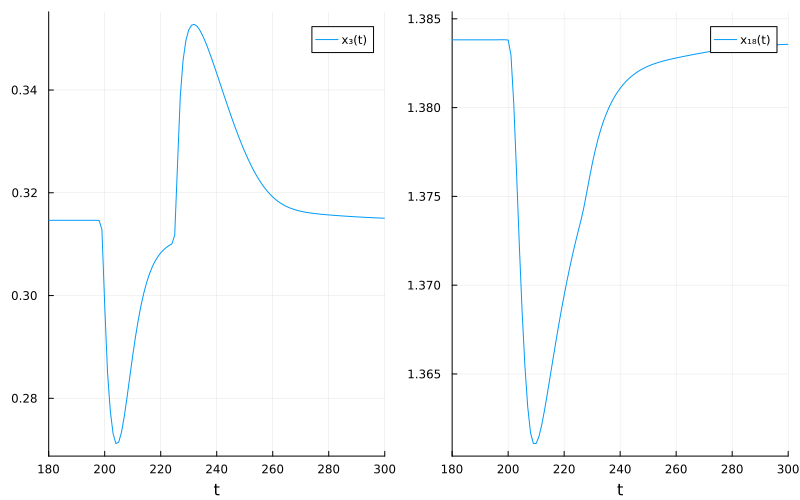

In [ ]:
# plot the results: change indexes in vars=[...] to select other variables for plot
upscale = 2 #8x upscaling in resolution
default(size=(400*upscale,250*upscale))
gr()

plot(sol_r23, tspan = (180.0, 300.0),vars=[3,18],layout=2)

In [ ]:
# mapping of vars idxs to names and bigg-nomenclature (where available)

# 1	 - 	 K_x_n	 - 	 u_k_m_n	 - 	 Potassium ion in neuronal mito. matrix
# 2	 - 	 Mg_x_n	 - 	 u_mg2_m_n	 - 	 Magnesium ion in neuronal mito. matrix
# 3	 - 	 NADHmito_n	 - 	 u_nadh_m_n	 - 	 NADH in neuronal mito.
# 4	 - 	 QH2mito_n	 - 	 u_q10h2_m_n	 - 	 Reduced ubiquinol in neuronal mito. matrix
# 5	 - 	 CytCredmito_n	 - 	 u_focytC_m_n	 - 	 Reduced cytochrome c in neuronal mito. matrix
# 6	 - 	 O2_n	 - 	 u_o2_c_n	 - 	 Oxygen in neuronal cytosol
# 7	 - 	 ATPmito_n	 - 	 u_atp_m_n	 - 	 Free ATP in neuronal mito. matrix
# 8	 - 	 ADPmito_n	 - 	 u_adp_m_n	 - 	 Free ADP in neuronal mito. matrix
# 9	 - 	 ATP_mx_n	 - 	 u_notBigg_ATP_mx_m_n	 - 	 Magnesium-bound ATP in neuronal mito. matrix
# 10	 - 	 ADP_mx_n	 - 	 u_notBigg_ADP_mx_m_n	 - 	 Magnesium-bound ADP in neuronal mito. matrix
# 11	 - 	 Pimito_n	 - 	 u_pi_m_n	 - 	 Phosphate in neuronal mito. matrix
# 12	 - 	 ATP_i_n	 - 	 u_atp_i_n	 - 	 Free ATP in neuronal mito. IMS
# 13	 - 	 ADP_i_n	 - 	 u_adp_i_n	 - 	 Free ADP in neuronal mito. IMS
# 14	 - 	 ATP_mi_n	 - 	 u_notBigg_ATP_mi_i_n	 - 	 Magnesium-bound ATP in neuronal mito. IMS
# 15	 - 	 ADP_mi_n	 - 	 u_notBigg_ADP_mi_i_n	 - 	 Magnesium-bound ADP in neuronal mito. IMS
# 16	 - 	 Pi_i_n	 - 	 u_pi_i_n	 - 	 Phosphate in neuronal mito. IMS
# 17	 - 	 MitoMembrPotent_n	 - 	 u_notBigg_MitoMembrPotent_m_n	 - 	 Neuronal mitochondrial membrane potential
# 18	 - 	 ATP_n	 - 	 u_atp_c_n	 - 	 ATP in neuronal cytosol
# 19	 - 	 FUMmito_n	 - 	 u_fum_m_n	 - 	 Fumarate in neuronal mito.
# 20	 - 	 MALmito_n	 - 	 u_mal_L_m_n	 - 	 L-Malate in neuronal mito.
# 21	 - 	 OXAmito_n	 - 	 u_oaa_m_n	 - 	 Oxaloacetate in neuronal mito.
# 22	 - 	 SUCmito_n	 - 	 u_succ_m_n	 - 	 Succinate in neuronal mito.
# 23	 - 	 SUCCOAmito_n	 - 	 u_succoa_m_n	 - 	 Succinyl-CoA in neuronal mito.
# 24	 - 	 CoAmito_n	 - 	 u_coa_m_n	 - 	 Coenzyme A in neuronal mito.
# 25	 - 	 AKGmito_n	 - 	 u_akg_m_n	 - 	 Alpha-ketoglutarate in neuronal mito.
# 26	 - 	 ISOCITmito_n	 - 	 u_icit_m_n	 - 	 Isocitrate in neuronal mito.
# 27	 - 	 CITmito_n	 - 	 u_cit_m_n	 - 	 Citrate in neuronal mito.
# 28	 - 	 AcCoAmito_n	 - 	 u_accoa_m_n	 - 	 Acetyl-CoA in neuronal mito.
# 29	 - 	 AcAc_n	 - 	 u_acac_c_n	 - 	 Acetoacetate in neuron (only mito., no cytosolic AcAc in the model)
# 30	 - 	 AcAcCoA_n	 - 	 u_aacoa_m_n	 - 	 Acetoacetyl-CoA in neuronal mito.
# 31	 - 	 PYRmito_n	 - 	 u_pyr_m_n	 - 	 Pyruvate in neuronal mito.
# 32	 - 	 bHB_n	 - 	 u_bhb_c_n	 - 	 beta-Hydroxybutyrate in neuronal cytosol
# 33	 - 	 bHB_ecs	 - 	 u_bhb_e_e	 - 	 beta-Hydroxybutyrate in extracellular space
# 34	 - 	 bHB_b	 - 	 u_bhb_b_b	 - 	 beta-Hydroxybutyrate in capillaries
# 35	 - 	 GLUmito_n	 - 	 u_glu_L_m_n	 - 	 L-Glutamate in neuronal mito.
# 36	 - 	 GLU_n	 - 	 u_glu_L_c_n	 - 	 L-Glutamate in neuronal cytosol
# 37	 - 	 NADH_n	 - 	 u_nadh_c_n	 - 	 NADH in neuronal cytosol
# 38	 - 	 K_x_a	 - 	 u_k_m_a	 - 	 Potassium ion in astrocytic mito. matrix
# 39	 - 	 Mg_x_a	 - 	 u_mg2_m_a	 - 	 Magnesium ion in astrocytic mito. matrix
# 40	 - 	 NADHmito_a	 - 	 u_nadh_m_a	 - 	 NADH in astrocytic mito.
# 41	 - 	 QH2mito_a	 - 	 u_q10h2_m_a	 - 	 Reduced ubiquinol in astrocytic mito. matrix
# 42	 - 	 CytCredmito_a	 - 	 u_focytC_m_a	 - 	 Reduced cytochrome c in astrocytic mito. matrix
# 43	 - 	 O2_a	 - 	 u_o2_c_a	 - 	 Oxygen in astrocytic cytosol
# 44	 - 	 ATPmito_a	 - 	 u_atp_m_a	 - 	 Free ATP in astrocytic mito. matrix
# 45	 - 	 ADPmito_a	 - 	 u_adp_m_a	 - 	 Free ADP in astrocytic mito. matrix
# 46	 - 	 ATP_mx_a	 - 	 u_notBigg_ATP_mx_m_a	 - 	 Magnesium-bound ATP in astrocytic mito. matrix
# 47	 - 	 ADP_mx_a	 - 	 u_notBigg_ADP_mx_m_a	 - 	 Magnesium-bound ADP in astrocytic mito. matrix
# 48	 - 	 Pimito_a	 - 	 u_pi_m_a	 - 	 Phosphate in astrocytic mito. matrix
# 49	 - 	 ATP_i_a	 - 	 u_atp_i_a	 - 	 Free ATP in astrocytic mito. IMS
# 50	 - 	 ADP_i_a	 - 	 u_adp_i_a	 - 	 Free ADP in astrocytic mito. IMS
# 51	 - 	 ATP_mi_a	 - 	 u_notBigg_ATP_mi_i_a	 - 	 Magnesium-bound ATP in astrocytic mito. IMS
# 52	 - 	 ADP_mi_a	 - 	 u_notBigg_ADP_mi_i_a	 - 	 Magnesium-bound ADP in astrocytic mito. IMS
# 53	 - 	 Pi_i_a	 - 	 u_pi_i_a	 - 	 Phosphate in astrocytic mito. IMS
# 54	 - 	 MitoMembrPotent_a	 - 	 u_notBigg_MitoMembrPotent_m_a	 - 	 Astrocytic mitochondrial membrane potential
# 55	 - 	 ATP_a	 - 	 u_atp_c_a	 - 	 ATP in astrocytic cytosol
# 56	 - 	 FUMmito_a	 - 	 u_fum_m_a	 - 	 Fumarate in astrocytic mito.
# 57	 - 	 MALmito_a	 - 	 u_mal_L_m_a	 - 	 L-Malate in astrocytic mito.
# 58	 - 	 OXAmito_a	 - 	 u_oaa_m_a	 - 	 Oxaloacetate in astrocytic mito.
# 59	 - 	 SUCmito_a	 - 	 u_succ_m_a	 - 	 Succinate in astrocytic mito.
# 60	 - 	 SUCCOAmito_a	 - 	 u_succoa_m_a	 - 	 Succinyl-CoA in astrocytic mito.
# 61	 - 	 CoAmito_a	 - 	 u_coa_m_a	 - 	 Coenzyme A in astrocytic mito.
# 62	 - 	 AKGmito_a	 - 	 u_akg_m_a	 - 	 Alpha-ketoglutarate in astrocytic mito.
# 63	 - 	 ISOCITmito_a	 - 	 u_icit_m_a	 - 	 Isocitrate in astrocytic mito.
# 64	 - 	 CITmito_a	 - 	 u_cit_m_a	 - 	 Citrate in astrocytic mito.
# 65	 - 	 AcCoAmito_a	 - 	 u_accoa_m_a	 - 	 Acetyl-CoA in astrocytic mito.
# 66	 - 	 PYRmito_a	 - 	 u_pyr_m_a	 - 	 Pyruvate in astrocytic mito.
# 67	 - 	 GLN_n	 - 	 u_gln_L_c_n	 - 	 Glutamine in neuron
# 68	 - 	 GLN_out	 - 	 u_gln_L_e_e	 - 	 Glutamine in extracellular space
# 69	 - 	 GLN_a	 - 	 u_gln_L_c_a	 - 	 Glutamine in astrocytic cytosol
# 70	 - 	 GLUT_a	 - 	 u_glu_L_c_a	 - 	 Glutamate in astrocytic cytosol
# 71	 - 	 Va	 - 	 u_notBigg_Va_c_a	 - 	 Astrocytic membrane potential
# 72	 - 	 Na_a	 - 	 u_na1_c_a	 - 	 Sodium ion in astrocytic cytosol
# 73	 - 	 K_a	 - 	 u_k_c_a	 - 	 Potassium ion in astrocytic cytosol
# 74	 - 	 K_out	 - 	 u_k_e_e	 - 	 Potassium ion in extracellular space
# 75	 - 	 GLUT_syn	 - 	 u_glu_L_syn_syn	 - 	 Synaptic glutamate
# 76	 - 	 VNeu	 - 	 u_notBigg_VNeu_c_n	 - 	 Neuronal membrane potential
# 77	 - 	 Na_n	 - 	 u_na1_c_n	 - 	 Sodium ion in neuronal cytosol
# 78	 - 	 h	 - 	 u_notBigg_hgate_c_n	 - 	 Gating variable h of Hodgkin-Huxley model in neuron
# 79	 - 	 n	 - 	 u_notBigg_ngate_c_n	 - 	 Gating variable n of Hodgkin-Huxley model in neuron
# 80	 - 	 Ca_n	 - 	 u_ca2_c_n	 - 	 Calcium in neuronal cytosol
# 81	 - 	 pgate	 - 	 u_notBigg_pgate_c_n	 - 	 Gating variable of M-current in neuron
# 82	 - 	 nBK_a	 - 	 u_notBigg_nBK_c_a	 - 	 Gating variable of BK channels in astrocyte
# 83	 - 	 mGluRboundRatio_a	 - 	 u_notBigg_mGluRboundRatio_c_a	 - 	 Ratio of bound metabotropic glutamate receptors in astrocyte
# 84	 - 	 IP3_a	 - 	 u_notBigg_IP3_c_a	 - 	 IP3 in astrocytic cytosol
# 85	 - 	 hIP3Ca_a	 - 	 u_notBigg_hIP3Ca_c_a	 - 	 Gating variable of IP3-dependent  calcium flow in astrocytic cytosol
# 86	 - 	 Ca_a	 - 	 u_ca2_c_a	 - 	 Calcium in astrocytic cytosol
# 87	 - 	 sTRP_a	 - 	 u_notBigg_sTRP_c_a	 - 	 Astrocytic TRPV4 channel open probability
# 88	 - 	 vV	 - 	 u_notBigg_vV_b_b	 - 	 Venous volume
# 89	 - 	 EET_a	 - 	 u_notBigg_EET_c_a	 - 	 Epoxyeicosatrienoic acid
# 90	 - 	 ddHb	 - 	 u_notBigg_ddHb_b_b	 - 	 Deoxyhemoglobin
# 91	 - 	 O2cap	 - 	 u_o2_b_b	 - 	 Oxygen in capillaries
# 92	 - 	 Glc_b	 - 	 u_glc_D_b_b	 - 	 D-Glucose in capillaries
# 93	 - 	 Glc_t_t	 - 	 u_glc_D_ecsEndothelium_ecsEndothelium	 - 	 D-Glucose in endothelium
# 94	 - 	 Glc_ecsBA	 - 	 u_glc_D_ecsBA_ecsBA	 - 	 D-Glucose in basal lamina
# 95	 - 	 Glc_a	 - 	 u_glc_D_c_a	 - 	 D-Glucose in astrocytic cytosol
# 96	 - 	 Glc_ecsAN	 - 	 u_glc_D_ecsAN_ecsAN	 - 	 D-Glucose in interstitial space
# 97	 - 	 Glc_n	 - 	 u_glc_D_c_n	 - 	 D-Glucose in neuronal cytosol
# 98	 - 	 G6P_n	 - 	 u_g6p_c_n	 - 	 D-Glucose 6-phosphate in neuronal cytosol
# 99	 - 	 G6P_a	 - 	 u_g6p_c_a	 - 	 D-Glucose 6-phosphate in astrocytic cytosol
# 100	 - 	 F6P_n	 - 	 u_f6p_c_n	 - 	 D-Fructose 6-phosphate in neuronal cytosol
# 101	 - 	 F6P_a	 - 	 u_f6p_c_a	 - 	 D-Fructose 6-phosphate in astrocytic cytosol
# 102	 - 	 FBP_n	 - 	 u_fdp_c_n	 - 	 D-Fructose 1,6-bisphosphate in neuronal cytosol
# 103	 - 	 FBP_a	 - 	 u_fdp_c_a	 - 	 D-Fructose 1,6-bisphosphate in astrocytic cytosol
# 104	 - 	 f26bp_a	 - 	 u_f26bp_c_a	 - 	 D-Fructose 2,6-bisphosphate in astrocytic cytosol
# 105	 - 	 GLY_a	 - 	 u_glycogen_c_a	 - 	 Glycogen in astrocytic cytosol
# 106	 - 	 G1P_a	 - 	 u_g1p_c_a	 - 	 D-Glucose 1-phosphate in astrocytic cytosol
# 107	 - 	 GAP_n	 - 	 u_g3p_c_n	 - 	 Glyceraldehyde 3-phosphate in neuronal cytosol
# 108	 - 	 GAP_a	 - 	 u_g3p_c_a	 - 	 Glyceraldehyde 3-phosphate in astrocytic cytosol
# 109	 - 	 DHAP_n	 - 	 u_dhap_c_n	 - 	 Dihydroxyacetone phosphate in neuronal cytosol
# 110	 - 	 DHAP_a	 - 	 u_dhap_c_a	 - 	 Dihydroxyacetone phosphate in astrocytic cytosol
# 111	 - 	 BPG13_n	 - 	 u_13dpg_c_n	 - 	 3-Phospho-D-glyceroyl phosphate in neuronal cytosol
# 112	 - 	 BPG13_a	 - 	 u_13dpg_c_a	 - 	 3-Phospho-D-glyceroyl phosphate in astrocytic cytosol
# 113	 - 	 NADH_a	 - 	 u_nadh_c_a	 - 	 NADH in astrocytic cytosol
# 114	 - 	 PG3_n	 - 	 u_3pg_c_n	 - 	 3-Phospho-D-glycerate in neuronal cytosol
# 115	 - 	 PG3_a	 - 	 u_3pg_c_a	 - 	 3-Phospho-D-glycerate in astrocytic cytosol
# 116	 - 	 PG2_n	 - 	 u_2pg_c_n	 - 	 D-Glycerate 2-phosphate in neuronal cytosol
# 117	 - 	 PG2_a	 - 	 u_2pg_c_a	 - 	 D-Glycerate 2-phosphate in astrocytic cytosol
# 118	 - 	 PEP_n	 - 	 u_pep_c_n	 - 	 Phosphoenolpyruvate in neuronal cytosol
# 119	 - 	 PEP_a	 - 	 u_pep_c_a	 - 	 Phosphoenolpyruvate in astrocytic cytosol
# 120	 - 	 Pyr_n	 - 	 u_pyr_c_n	 - 	 Pyruvate in neuronal cytosol
# 121	 - 	 Pyr_a	 - 	 u_pyr_c_a	 - 	 Pyruvate in astrocytic cytosol
# 122	 - 	 Lac_b	 - 	 u_lac_L_b_b	 - 	 L-Lactate in capillaries
# 123	 - 	 Lac_ecs	 - 	 u_lac_L_e_e	 - 	 L-Lactate in extracellular space
# 124	 - 	 Lac_a	 - 	 u_lac_L_c_a	 - 	 L-Lactate in astrocytic cytosol
# 125	 - 	 Lac_n	 - 	 u_lac_L_c_n	 - 	 L-Lactate in neuronal cytosol
# 126	 - 	 NADPH_n	 - 	 u_nadph_c_n	 - 	 NADPH in neuronal cytosol
# 127	 - 	 NADPH_a	 - 	 u_nadph_c_a	 - 	 NADPH in astrocytic cytosol
# 128	 - 	 GL6P_n	 - 	 u_6pgl_c_n	 - 	 6-phospho-D-glucono-1,5-lactone in neuronal cytosol
# 129	 - 	 GL6P_a	 - 	 u_6pgl_c_a	 - 	 6-phospho-D-glucono-1,5-lactone in astrocytic cytosol
# 130	 - 	 GO6P_n	 - 	 u_6pgc_c_n	 - 	 6-Phospho-D-gluconate in neuronal cytosol
# 131	 - 	 GO6P_a	 - 	 u_6pgc_c_a	 - 	 6-Phospho-D-gluconate in astrocytic cytosol
# 132	 - 	 RU5P_n	 - 	 u_ru5p_D_c_n	 - 	 D-Ribulose 5-phosphate in neuronal cytosol
# 133	 - 	 RU5P_a	 - 	 u_ru5p_D_c_a	 - 	 D-Ribulose 5-phosphate in astrocytic cytosol
# 134	 - 	 R5P_n	 - 	 u_r5p_c_n	 - 	 D-Ribose 5-phosphate in neuronal cytosol
# 135	 - 	 R5P_a	 - 	 u_r5p_c_a	 - 	 D-Ribose 5-phosphate in astrocytic cytosol
# 136	 - 	 X5P_n	 - 	 u_xu5p_D_c_n	 - 	 D-Xylulose 5-phosphate in neuronal cytosol
# 137	 - 	 X5P_a	 - 	 u_xu5p_D_c_a	 - 	 D-Xylulose 5-phosphate in astrocytic cytosol
# 138	 - 	 S7P_n	 - 	 u_s7p_c_n	 - 	 Sedoheptulose 7-phosphate in neuronal cytosol
# 139	 - 	 S7P_a	 - 	 u_s7p_c_a	 - 	 Sedoheptulose 7-phosphate in astrocytic cytosol
# 140	 - 	 E4P_n	 - 	 u_e4p_c_n	 - 	 D-Erythrose 4-phosphate in neuronal cytosol
# 141	 - 	 E4P_a	 - 	 u_e4p_c_a	 - 	 D-Erythrose 4-phosphate in astrocytic cytosol
# 142	 - 	 GSH_n	 - 	 u_gthrd_c_n	 - 	 Reduced glutathione in neuronal cytosol
# 143	 - 	 GSH_a	 - 	 u_gthrd_c_a	 - 	 Reduced glutathione in astrocytic cytosol
# 144	 - 	 GSSG_n	 - 	 u_gthox_c_n	 - 	 Oxidized glutathione in neuronal cytosol
# 145	 - 	 GSSG_a	 - 	 u_gthox_c_a	 - 	 Oxidized glutathione in astrocytic cytosol
# 146	 - 	 PCr_n	 - 	 u_pcreat_c_n	 - 	 Phosphocreatine in neuronal cytosol
# 147	 - 	 PCr_a	 - 	 u_pcreat_c_a	 - 	 Phosphocreatine in astrocytic cytosol
# 148	 - 	 cAMP_a	 - 	 u_camp_c_a	 - 	 Cyclic AMP in astrocytic cytosol
# 149	 - 	 NE_neuromod	 - 	 u_nrpphr_e_e	 - 	 Norepinephrine in extracellular space
# 150	 - 	 GPa_a	 - 	 u_notBigg_GPa_c_a	 - 	 Active glycogen phosphorylase in astrocytic cytosol
# 151	 - 	 GPb_a	 - 	 u_notBigg_GPb_c_a	 - 	 Inactive glycogen phosphorylase in astrocytic cytosol

In [ ]:
# selection to plot

vars2plot1 = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87]

length(vars2plot1)

85

In [ ]:
# selection to plot

vars2plot2 = [88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151]

length(vars2plot2)

64

In [ ]:
upscale = 2 #8x upscaling in resolution
default(size=(1200*upscale,500*upscale))
gr()

plot(sol_r23, tspan = (180.0, 300.0),vars = vars2plot1,
layout=length(vars2plot1),linewidth = 2,xtickfontsize=6,ytickfontsize=6,xguidefontsize=6,yguidefontsize=6)


In [ ]:
upscale = 2 #8x upscaling in resolution
default(size=(1200*upscale,500*upscale))
gr()

plot(sol_r23, tspan = (180.0, 300.0),vars = vars2plot2,
layout=length(vars2plot2),linewidth = 2,xtickfontsize=6,ytickfontsize=6,xguidefontsize=6,yguidefontsize=6)